In [1]:
from tabulate import tabulate
import pandas as pd
import json
import numpy as np
from glob import glob
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rc('pdf', fonttype=42)
import os
sns.set(font_scale=1.2)
rdir = '../results_sym_data/'
figdir = '../../paper/figs/' + rdir.replace('..','')

print('figdir:',figdir)
def save(h=None,name='tmp'):
    name = name.strip().replace(' ','-').replace('%','pct')
    if h == None:
        h = plt.gcf()
    h.tight_layout()
    print('saving',name+'.pdf')
    if not os.path.exists(figdir):
        os.makedirs(figdir)
    plt.savefig(figdir+'/'+name+'.pdf', bbox_inches='tight')
    

figdir: ../../paper/figs//results_sym_data/


# load data from json

In [2]:
frames = []
excluded_datasets = [
    'feynman_test_10',
    'feynman_I_26_2',
    'feynman_I_30_5'
]
excluded_cols = [
    'params'
]
# comparison_cols = [
#     'dataset',
#     'algorithm',
#     'random_state',
#     'time_time',
#     'model_size',
#     'symbolic_model',
#     'r2_test',
#     'mse_test',
#     'mae_test',
#     'target_noise',
#     'feature_noise'
#     'symbolic_model',
# ]
fails = []
bad_bsr = []
updated = 0
import pdb
for f in tqdm(glob(rdir + '/*/*.json')
#               +glob(rdir + '/strogatz*/*.json')
             ):
    if os.path.exists(f+'.updated'):
        f += '.updated'
        updated += 1
    if 'cv_results' in f: 
        continue
    if 'EHC' in f:
        continue
    if any([ed in f for ed in excluded_datasets]):
        continue
    try: 
        r = json.load(open(f,'r'))
        if isinstance(r['symbolic_model'],list):
            print('WARNING: list returned for model:',f)
            bad_bsr.append(f)
            sm = ['B'+str(i)+'*'+ri for i, ri in enumerate(r['symbolic_model'])]
            sm = '+'.join(sm)
            r['symbolic_model'] = sm
            
        sub_r = {k:v for k,v in r.items() if k not in excluded_cols}
    #     df = pd.DataFrame(sub_r)
        frames.append(sub_r) 
    #     print(f)
    #     print(r.keys())
    except Exception as e:
        fails.append([f,e])
        pass
    
print(len(frames),'results files loaded, {} ({:.1f}%) of which are updated'.format(
        updated, updated/len(frames)*100))
print(len(fails),'fails:')
for f in fails: print(f[0])
print('bad bsr:',bad_bsr)
# df_results = pd.concat(frames)
df_results = pd.DataFrame.from_records(frames)
# cleanup
df_results = df_results.rename(columns={'time_time':'training time (s)'})
df_results.loc[:,'training time (hr)'] = df_results['training time (s)']/3600
# add modified R2 with 0 floor
df_results['r2_zero_test'] = df_results['r2_test'].apply(lambda x: max(x,0))
# fill simplified models with unsimplified if not present
# df_results.loc[:,'simplified_symbolic_model'] = df_results['simplified_symbolic_model'].fillna(
#                                                     df_results['symbolic_model'])
for col in ['symbolic_error_is_zero', 'symbolic_error_is_constant', 'symbolic_fraction_is_constant']:
    df_results.loc[:,col] = df_results[col].fillna(False)
print(','.join(df_results.algorithm.unique()))
# remove 'Regressor' from names
df_results['algorithm'] = df_results['algorithm'].apply(lambda x: x.replace('Regressor','')) 
df_results['algorithm'] = df_results['algorithm'].apply(lambda x: x.replace('tuned.','')) 
df_results['algorithm'] = df_results['algorithm'].apply(lambda x: x.replace('sembackpropgp','SBP')) 
# rename FE_AFP to AFP_FE
df_results['algorithm'] = df_results['algorithm'].apply(lambda x: x.replace('FE_AFP','AFP_FE'))
# rename GPGOMEA to GP-GOMEA
df_results['algorithm'] = df_results['algorithm'].apply(lambda x: x.replace('GPGOMEA','GP-GOMEA'))
# indicator of strogatz or feynman
df_results['data_group'] = df_results['dataset'].apply(lambda x: 'Feynman' if 'feynman' in x else 'Strogatz') 
# save so we don't have to load again
# df_results.to_feather(rdir.replace('.','').replace('/','')+'.feather')

 73%|███████▎  | 31533/43391 [00:07<00:02, 4209.87it/s]

100%|██████████| 43391/43391 [00:09<00:00, 4432.14it/s]


43231 results files loaded, 39543 (91.5%) of which are updated
1 fails:
../results_sym_data/feynman_II_27_18/feynman_II_27_18_tuned.DSRRegressor_23654_target-noise0.01.json
bad bsr: ['../results_sym_data/feynman_I_50_26/feynman_I_50_26_tuned.BSRRegressor_23654.json.updated']
tuned.AFPRegressor,tuned.DSRRegressor,tuned.EPLEXRegressor,tuned.FFXRegressor,tuned.GPGOMEARegressor,tuned.BSRRegressor,tuned.ITEARegressor,tuned.FEATRegressor,tuned.OperonRegressor,tuned.AIFeynman,tuned.FE_AFPRegressor,tuned.gplearn,tuned.MRGPRegressor,tuned.sembackpropgp


In [3]:
df_results.groupby('random_state').count().sort_values(by='dataset')


dataset  algorithm  process_time  training time (s)  \
random_state                                                        
21962             877        877           877                877   
4426              948        948           948                948   
5390             4359       4359          4359               4359   
860              5128       5128          5128               5128   
28020            5240       5240          5240               5240   
14423            5265       5265          5265               5265   
15795            5288       5288          5288               5288   
29910            5359       5359          5359               5359   
16850            5379       5379          5379               5379   
23654            5388       5388          5388               5388   

              target_noise  feature_noise  true_model  model_size  \
random_state                                                        
21962                  877            877         877         877   
4426                   948            948         948         948   
5390                  4359           4359        4359        4359   
860                   5128           5128        5128        5128   
28020                 5240           5240        5240        5240   
14423                 5265           5265        5265        5265   
15795                 5288           5288        5281        5288   
29910                 5359           5359        5359        5359   
16850                 5379           5379        5379        5379   
23654                 5388           5388        5329        5388   

              symbolic_model  mse_train  ...  simplified_complexity  \
random_state                             ...                          
21962                    877        877  ...                    864   
4426                     948        948  ...                    931   
5390                    4359       4359  ...                   3979   
860                     5128       5128  ...                   3575   
28020                   5240       5240  ...                   4879   
14423                   5265       5265  ...                   4704   
15795                   5288       5288  ...                   4919   
29910                   5359       5359  ...                   5011   
16850                   5379       5379  ...                   4990   
23654                   5388       5388  ...                   4980   

              symbolic_error  symbolic_fraction  symbolic_error_is_zero  \
random_state                                                              
21962                    760                760                     877   
4426                     795                795                     948   
5390                    3671               3671                    4359   
860                     3227               3227                    5128   
28020                   4067               4067                    5240   
14423                   3945               3945                    5265   
15795                   4437               4437                    5288   
29910                   4133               4133                    5359   
16850                   4093               4093                    5379   
23654                   4114               4114                    5388   

              symbolic_error_is_constant  symbolic_fraction_is_constant  \
random_state                                                              
21962                                877                            877   
4426                                 948                            948   
5390                                4359                           4359   
860                                 5128                           5128   
28020                               5240                           5240   
14423                               5265                           5265   
15

# compute symbolic solutions

In [4]:
df_results.loc[:,'symbolic_solution'] = df_results[['symbolic_error_is_zero',
                                                    'symbolic_error_is_constant',
                                                    'symbolic_fraction_is_constant']
                                                   ].apply(any,raw=True, axis=1)
# df_results.loc[:,'symbolic_solution'] = df_results['symbolic_solution'] & df_results['r2_test'] > 0.999
df_results.loc[:,'symbolic_solution'] = df_results['symbolic_solution'] & ~df_results['simplified_symbolic_model'].isna() 
df_results.loc[:,'symbolic_solution'] = df_results['symbolic_solution'] & ~(df_results['simplified_symbolic_model'] == '0')
df_results.loc[:,'symbolic_solution'] = df_results['symbolic_solution'] & ~(df_results['simplified_symbolic_model'] == 'nan')

In [5]:
# save results for detailed tabulating

In [6]:
df_results.to_feather(rdir.replace('.','').replace('/','')+'_solns.feather')

# view symbolic models

In [7]:
# df_solns = df_results.loc[df_results.symbolic_solution==True]
# df_solns = df_results
df_solns = df_results # .loc[df_results.algorithm=='Operon'].loc[df_results.target_noise==0.001]
for (dataset,noise), dfg in df_solns.groupby(['dataset','target_noise']):
    print(80*'=')
    print(dataset,noise)
    print('True Model:',dfg['true_model'].dropna().apply(lambda x: x.strip()).unique())
    df_solns = dfg.loc[dfg.symbolic_solution==True]
    if len(df_solns)>0:
        print('Solutions',60*'=')
        for alg, dfga in df_solns.groupby('algorithm'):
            print('  ',alg,'model:',dfga['simplified_symbolic_model'].mode().values)
    df_notsolns = dfg.loc[dfg.symbolic_solution==False]
    print('Non-solutions',56*'=')
    for alg, dfga in df_notsolns.groupby('algorithm'):
        guess = dfga['simplified_symbolic_model'].mode().values
        not_updated=False
        if len(guess) == 0:
            guess = dfga['symbolic_model'].mode().values
            not_updated = True
            
        acc = dfga['r2_test'].median()
        
#         print('guesses:',len(guess))
        print('  ',alg,'[no upate]' if not_updated else '','models (',len(guess),',',round(acc,3),'):')
        for g in guess:
            print('\t',g[:80],'...' if len(g)>80 else '')
#             print('\t',g)
    

feynman_III_10_19 0.0
True Model: ['mom*sqrt(Bx**2 + By**2 + Bz**2)' 'mom*sqrt(Bx**2+By**2+Bz**2)']
Solutions ============================================================
   AFP_FE model: ['mom*sqrt(Bx**2 + By**2 + Bz**2)']
   AIFeynman model: ['mom*sqrt(Bx**2 + By**2 + Bz**2)']
Non-solutions ========================================================
   AFP  models ( 8 , 0.989 ):
	 2.76*mom*sqrt(0.76*Bx + 0.76*By - exp(1.49*mom/(sqrt(0.525*Bz + 1)*(0.351*Bz + 1 ...
	 Bx + (0.417*mom + 0.274)*(By + Bz + log(mom**3)) - exp(cos(mom)) - sin(Bx) - cos ...
	 exp(sqrt(mom) + 0.704*(-0.90995*Bz*log(Bx*sqrt(exp(By)*cos(0.6832*Bx))) + sin(By ...
	 log(exp(Bx + By - (sin(0.796*Bz - 1.49) + sin(sin(By)))*log(-By - 0.494) + exp(B ...
	 mom*(0.092*Bx**2 + 2.68*sqrt(0.656*By + 0.656*Bz + 1)) 
	 mom*(0.604*Bx + 0.604*By + 0.602*Bz) 
	 mom*(Bx + log(By**2*Bz**2)/sqrt(Bx)) + cos(log(By)*cos(log(0.198*(Bz - sqrt(By*e ...
	 mom*(By + sqrt(Bz*(Bx - sqrt(Bz)*(1.29*sqrt(By) - sqrt(Bz))))) 
   AFP_FE  models ( 

   GP-GOMEA  models ( 1 , 1.0 ):
	 0 
   ITEA  models ( 8 , 0.984 ):
	 (75.0*E_n*d*k - 95.0*E_n*k - 0.14*h)/h 
	 (75.2*E_n*d*k - 95.2*E_n*k - 1.91*h)/h 
	 (75.3*E_n*d*k - 95.4*E_n*k - 1.68*h)/h 
	 (75.59*E_n*d*k - 97.476*E_n*k + 1.3143*h)/h 
	 (75.7*E_n*d*k - 98.8*E_n*k + 3.67*h)/h 
	 (75.8*E_n*d*k - 96.6*E_n*k - 1.96*h)/h 
	 (75.8*E_n*d*k - 97.1*E_n*k - 1.04*h)/h 
	 (75.9*E_n*d*k - 98.0*E_n*k + 0.999*h)/h 
   MRGP  models ( 8 , 1.0 ):
	 (0.06*d**3*(E_n - d*sqrt(-d**3*(d - (-3*d**2 + d + 2*sin(log(d))**2)**2)*(E_n*sq ...
	 (E_n**2*(1.2*E_n**3*(E_n*(E_n - 2*d**2*k) - d - h*log(E_n)/2) - 1.15*E_n*d*(E_n* ...
	 0.074*E_n**2/h + 0.129*E_n**2/h**2 + 7.38*E_n + 8.93*d + 12.5*h 
	 0.14*E_n*d**2*k/h + 9.26*E_n*k + 11.8*E_n + 9.23*d**4 + 0.14*d**2*h**4*k*exp(d)  ...
	 14.7*E_n + 8.93*d**2*k*(2*E_n + h) + 3.28*d**2*k*(2*E_n + h)/h + 0.034*d + 0.44* ...
	 6.62*E_n + 3.97*d + 0.015*sqrt(k) + 12.4*sqrt(log(E_n)) 
	 9.75*E_n + 2.29*d + 12.5*h 
	 9.8788*E_n**2 + 0.09012*E_n*d**2/h + 0.0022702*E_n*(d*

   AIFeynman  models ( 7 , -0.997 ):
	 -asin(-0.023*I_0**3*T + 0.046*I_0**3*Volt - 0.024*I_0**3*kb + 0.024*I_0**3*q - 0 ...
	 -asin(-0.025*I_0**3*T + 0.069*I_0**3*Volt - 0.047*I_0**3*kb + 0.047*I_0**3*q - 0 ...
	 -asin(-0.047*I_0**3*T + 0.047*I_0**3*Volt - 0.069*I_0**3*kb + 0.047*I_0**3*q + 0 ...
	 -asin(0.00598*I_0**4 - 0.043*I_0**3*T + 0.045*I_0**3*Volt - 0.066*I_0**3*kb + 0. ...
	 -asin(0.00598*I_0**4 - 0.046*I_0**3*T + 0.046*I_0**3*Volt - 0.048*I_0**3*kb + 0. ...
	 -asin(0.022*I_0**3*Volt + 0.046*I_0**3*q - 0.094*I_0**3 + 0.058*I_0**2*T**2*kb** ...
	 asin(0.011*I_0**4 + 0.00101*I_0**3*T - 0.068*I_0**3*Volt + 0.046*I_0**3*kb - 0.1 ...
   BSR  models ( 7 , 0.423 ):
	 -4.11*T**2*q + 8.08*Volt + kb**3*(0.0174*I_0 - 0.00335)*exp(q) - 9.98*kb + 0.013 ...
	 -6.45*I_0 + 5.38*T + 1.37*Volt**3 - 0.885*Volt + 19.1*cos(T) + 1.39*cos(q**3) -  ...
	 -7.48*Volt*cos(q) - 1.17*kb**3 + q + 0.788*(0.278*I_0 + 1)**3 + 2.04*(Volt + 0.3 ...
	 0 
	 0.003*I_0**3*sin(cos(q**3))**3 + 0.487*Volt**3 + 1.615*V

True Model: ['0.013*h**2/(E_n*d**2)' '(h/(2*pi))**2/(2*E_n*d**2)'
 '0.0126651479560162*h**2/(E_n*d**2)']
Solutions ============================================================
   AFP model: ['-0.01215*h**2/(E_n*d**2)' '0.012*h**2/(E_n*d**2)'
 '0.013*h**2/(E_n*d**2)']
   AFP_FE model: ['0.012*h**2/(E_n*d**2)' '0.013*h**2/(E_n*d**2)']
   AIFeynman model: ['0.013*h**2/(E_n*d**2)']
   GP-GOMEA model: ['0.01267*h**2/(E_n*d**2)' '0.013*h**2/(E_n*d**2)']
Non-solutions ========================================================
   AFP  models ( 5 , 0.996 ):
	 -(0.592*sqrt(E_n) - h)/(d**3*(sqrt(E_n - 0.302/(0.32 + 0.032*(log(h**2) - 0.627) ...
	 -sin(0.034*h**2/((E_n + cos(sqrt(exp(-3*sqrt(exp(E_n)))*log(h**2)**3)))**(3/2)*( ...
	 0.013*h**2/(d**2*(E_n + 0.049)) 
	 0.868*log(exp(sqrt((h - 1.4)*exp(-d))))**2/(0.932*E_n + sqrt(0.868*sin(log(E_n*e ...
	 h*exp(-3*sqrt(d))/E_n 
   AFP_FE  models ( 4 , 0.997 ):
	 0.00999*(h + 0.963)*(h + (log(h) - 0.531)**6/64)/(E_n*d**2) 
	 0.014*h**2/(E_n*(d + 0.058/d

	 -0.049*sqrt(-1/d + 0.118*d/alpha) - 0.017*sin(n*sin(d*n)) - 0.017*sin(d/(alpha*l ...
	 0.00403*alpha**2*sin(n)*sin(d - n**2)/d**2 + 0.28*alpha/(d*sin(0.044*n)) + 0.004 ...
	 0.00806 + 0.032*(195.0*alpha/d + log(-alpha + n) - sin(9.69/n) - sin(alpha*n - 2 ...
	 0.024*alpha*sqrt(-n + cos(n))/(log(19.2*alpha/d) + cos(d/(n*(alpha - n)))) + 6.3 ...
	 zoo*alpha/(d*n) + 0.027 - 0.015*n/alpha 
   ITEA  models ( 7 , 1.0 ):
	 6.18*alpha/(d*n) - 0.159*cos(alpha/(d*n)) + 0.179 
	 6.27*alpha/(d*n) + 0.017*sin(d) + 0.00201 
	 6.279*alpha/(d*n) - 0.016*cos(alpha*d/n) - 0.002 
	 6.28*alpha/(d*n) + 0.00806*sin(d*n) - 0.00403 
	 6.28*alpha/(d*n) + 0.012*sin(alpha*d/n) - 0.00101 
	 6.29*alpha/(d*n) - 0.014*sin(d*n) - 0.005 
	 6.29*alpha/(d*n) - 0.656*tanh(alpha*d) + 0.661 
   MRGP [no upate] models ( 5 , 0.195 ):
	 -4.79587784964171E-5*mylog( 0.0*div( 0.0*div( 0.0*div( 0.0*div( -2.0770277049580 ...
	 0.0*div( 0.0*cube( 0.0*+( 1.3532659330470368E-5*X1 6.072046871336497*div( 0.0*cu ...
	 0.0*div( 0.0*div

   AFP  models ( 8 , 0.976 ):
	 -(0.005 + m/epsilon)/((n - log(1.61*log(sqrt(n)) + 1.61*cos(log(1.21/epsilon)) - ...
	 -0.542*m*q**3/(epsilon**2*h**2*n**2) 
	 -0.955*m*(0.535*q + sin(q/(epsilon + 2.2)))**2*(0.558*q - sin((epsilon + 0.097)/ ...
	 -3.25*(q - 0.943)**3/(h*n*(epsilon*(n + 2.01*(-0.061*epsilon - h)**(1/4))*sqrt(( ...
	 -3.43*exp(-epsilon + q)*log(m)/(h**2*n**2) 
	 -log(q/(0.736 + exp(-2.28/h)))**2*log(m + log(-q/(epsilon**2*(sqrt(h) - log(q) + ...
	 -q**2*sqrt(sqrt(n) - sqrt(epsilon + log(0.43231*sqrt(-log(n - sqrt(h - q) + 3.10 ...
	 6.28*q*(0.419*q - sin(sqrt(n) + cos(0.095*h)) + 0.312/h)*log(log(sin(sin(log(q)) ...
   AFP_FE  models ( 9 , 0.997 ):
	 (q - log(log(h) + 0.0189))*(sqrt(m*q) - cos(0.424*h - 0.424*q))*(h - 2*q + cos(s ...
	 (sqrt(m**(-1.82)*exp(1.82*(-q - cos(log(cos(n))*sqrt(sin(sqrt((-h + q**2 - sin(( ...
	 -0.102/h - 0.307*sin(log(q))**3/(epsilon*(-h*n*sin(sqrt(epsilon) - 0.333)*cos(lo ...
	 -0.125*m*q**3*(q - 0.00806)/(epsilon**2*h**2*n**2) 
	 -0.269*m*((s

   gplearn model: ['-A_vec*q*rho_c_0/m - 0.469']
Non-solutions ========================================================
   AFP  models ( 6 , 0.996 ):
	 -(rho_c_0*log(q)/m + 1.72*sqrt(-0.337*A_vec*rho_c_0 + 0.337*log(A_vec - m + rho_ ...
	 -0.343*(rho_c_0 + cos(log(m/log(log(exp(2.11*q/rho_c_0) + 1.39)))) - 0.807 + q/m ...
	 -0.996*A_vec*q*rho_c_0/(m + 0.005) 
	 -q*rho_c_0*(A_vec + 0.123)/(m + 0.048*exp(cos(1.35*(0.906*rho_c_0 + 1)**3))*cos( ...
	 -rho_c_0*(0.98*A_vec*q + 1.95*q*exp(-rho_c_0*(1.67*q - log(-0.336*rho_c_0*(A_vec ...
	 -rho_c_0*(q*(0.979*A_vec - 0.069*sqrt(log(m))) + 0.084)/m 
   AFP_FE  models ( 10 , 0.997 ):
	 (-m*(q*rho_c_0 + 0.34) + (-A_vec + m)*(q*rho_c_0 - sin(-A_vec + sqrt(q) + q*rho_ ...
	 (m*log(log(-1/sqrt(A_vec)) - 0.214)**3 - 0.269*log(A_vec)*log((-0.311*q*rho_c_0* ...
	 -0.983*A_vec*q*(rho_c_0 + 0.159)/sqrt(m**2) + sin(rho_c_0 + cos(1.21*A_vec*q/sqr ...
	 -A_vec*q*(rho_c_0 + 0.063)/m 
	 -A_vec*q*rho_c_0/m + cos(exp(exp(cos(q*rho_c_0/m)))) 
	 -A_vec*rho_c_0*(q 

   gplearn  models ( 8 , 0.997 ):
	 T*kb - (h*omega + 0.97)**(1/8) + sin(sqrt(2)*(h*omega)**(1/4)) 
	 T*kb - 0.182*h - 0.15 
	 T*kb - 0.235*omega 
	 T*kb - 0.609 
	 T*kb - log(T**(1/8)/omega**(3/2) + h - h/sqrt(omega) + 1 - (T**(1/8)/omega**(3/2 ...
	 T*kb - omega/(T + sin(T) + sin(h) + sin(T + sin(T)) + (T + 2*sin(T) + (T + omega ...
	 T*kb - sin(0.256*h) 
	 T*kb - sin(sin(log(h))) 
feynman_III_4_33 0.001
True Model: ['0.159*h*omega/(exp(0.159*h*omega/(T*kb)) - 1)'
 '(h/(2*3.1415926535))*omega/(exp((h/(2*3.1415926535))*omega/(kb*T))-1)'
 '0.159154943096444*h*omega/(exp(0.159154943096444*h*omega/(T*kb)) - 1)'
 '(h/(2*pi))*omega/(exp((h/(2*pi))*omega/(kb*T))-1)']
Non-solutions ========================================================
   AFP  models ( 7 , 1.0 ):
	 0.994*T*kb - 0.067*h*omega 
	 1.0*T*kb - 0.069*h*omega - 0.068*log(kb) 
	 T*kb - 0.225*omega 
	 T*kb - 0.241*h + 0.241*sin(omega) 
	 T*kb - sin(0.34*log(h*omega/log(sin(h) + 13.6))**2) - 0.251 
	 T*kb - sqrt(exp(-sin(omega))*cos

   MRGP [no upate] models ( 7 , -2.051 ):
	 -0.2001259771301615*mul( -13.966619440752648*div( 6.5818996085661405*cube( 0.0*m ...
	 -15.862239438301543*add( 0.3886524295308457*sqrt( -0.4790506798395701*square( 0. ...
	 0.0*add( 31.40324594041001*mul( 0.0*mylog( 0.0*mul( 0.0*mul( 0.0*div( 0.0*mul( 0 ...
	 0.0*div( -5.93733035356327*cube( 0.0*div( -5.850251362691924E-5*mylog( 0.0*mul(  ...
	 0.0*div( 0.0*div( -5.232253966739075*mylog( 0.0*quart( -34.0775833954276*sin( 28 ...
	 0.11638704588260448*div( 0.0012746782948281686*add( 1.9485022529640028*square( 0 ...
	 2.4407583011662344*div( 0.0*sin( -7.149063494488999*div( 0.0*sin( -0.24822653680 ...
   Operon  models ( 10 , 0.973 ):
	 -0.00299*mom*(cos(730.0*h)**2 + cos(731.0*h) - 3.05*(3.48*B + cos(731.0*h))/h)*( ...
	 -0.303 - 0.0649*(4.6*B - 0.205*mom + cos(10.9*B + 1.35*h) + cos(988.0*B**2 - 16. ...
	 -0.807*B*(1.11*B + cos(8.55*B)) + 4.83*B + 12.9*B*mom/h + 0.995*h*cos(28.1*mom)  ...
	 -1.52*B*sin(1.96*B)*sin(6.74*B) - 0.027*B*mom*(9.29*

	 16.8*log(Ef*omega*p_d/(h*omega_0)) + 22.6*cos(omega/omega_0) - 3.8 
	 16.9*log(Ef*omega*p_d/(h*omega_0)) + 22.3*cos(omega/omega_0) - 3.65 
	 16.9*log(Ef*omega_0*p_d/(h*omega)) + 22.4*cos(omega_0/omega) - 3.78 
	 16.914*log(Ef*omega_0*p_d/(h*omega)) + 22.177*cos(omega_0/omega) - 3.648 
	 17.0*log(Ef*omega*p_d/(h*omega_0)) + 22.4*cos(omega/omega_0) - 3.86 
   MRGP  models ( 1 , 0.986 ):
	 3.58*sqrt(Ef) + 0.031*Ef**2*sqrt(omega)*p_d*t**5*sqrt(t*(Ef*p_d*t/h + sqrt(omega ...
   Operon  models ( 9 , 0.978 ):
	 -0.000977*Ef*p_d*t*(928.0*omega_0 + 1.23e+3*t - 1.19e+4)/h - 0.123*p_d + 0.047 
	 -0.161 + 5.35*(0.116*Ef*p_d + t)**2*(0.728*sqrt(Ef) - 0.138*Ef + 0.736*sqrt(p_d) ...
	 -0.187 
	 0.325*Ef*(28.6*p_d + exp(-0.811*t))*((1.42*t + sin(1.75*omega - 1.74*omega_0 + 1 ...
	 0.356 
	 0.645 
	 0.93 + 7.46e+4*t*(1.59*Ef*sin(0.512*omega_0) - 8.28*omega + 3.93*omega_0 + 0.981 ...
	 1.14 
	 3.41 - 1.56*t 
   SBP  models ( 7 , 0.99 ):
	 -0.005*Ef*(35.4*h*t - 119.0)*(-h + p_d + sin(t)) + 0.00201*Ef*(

Non-solutions ========================================================
   AFP  models ( 7 , 0.993 ):
	 0.124*Ef*sqrt(n_rho**3/T**3)*(1.19*(p_d - 0.917*sqrt(-kb + sin(kb + 0.479)))**2  ...
	 0.336*Ef*n_rho*(p_d - 0.00702)**2/(kb*(T + 0.00702)) 
	 0.804*p_d**2*sqrt((Ef**2 + (Ef - 0.255)**2*(n_rho - 2.18))/T**2)/kb 
	 1.14*sqrt(-Ef**2*n_rho*p_d**3*(p_d + 0.037)*sin(0.085*n_rho)/(T**2*kb**2)) 
	 4.22*(Ef*(p_d - sin(n_rho))*sin(cos(1.36/n_rho)) - sin(exp(n_rho)**(1/4) - cos(l ...
	 Ef*n_rho*p_d*log(p_d)/(T*kb) 
	 n_rho*p_d*exp(-cos(sqrt(Ef)))/(kb*(T/p_d)**(3/2)*sqrt((T + p_d + exp((log(p_d) - ...
   AFP_FE  models ( 8 , 1.0 ):
	 -0.333*Ef*n_rho*p_d*sqrt(p_d**2/T**2)/kb 
	 0.156*Ef*(sqrt(Ef*p_d**3/T**(3/2)) + 0.3*p_d*sqrt((n_rho*(p_d + 0.867) + cos(cos ...
	 0.223*(4.02*Ef*p_d**2*log(n_rho + 0.093)/kb + p_d**2*(Ef + sin(kb))**2*exp(-2*n_ ...
	 0.333*Ef*n_rho*p_d*(p_d + 0.00101)/(T*kb) 
	 0.683*Ef*n_rho*p_d*sqrt(-p_d + (0.292 - p_d)**(3/2) + 0.7)/(T*kb) 
	 1.64*Ef*n_rho*((0.653*p_d + 0.14 - 1

	 Ef*(alpha*(epsilon*n - sin(1.54*sin(alpha*n)**2)*cos(exp(sqrt(n)))) - exp(-exp(e ...
	 Ef*alpha*epsilon*n*sqrt(alpha + n) 
	 Ef*alpha*epsilon*n/cos(alpha*n*sin(Ef)) 
	 Ef*n*(alpha*n + epsilon)*sin(alpha) 
	 alpha*(Ef*epsilon*n + alpha**2*(n - 0.299)**6 + alpha*n*sin(Ef*alpha*n)) 
	 alpha*epsilon*n*(1.041*Ef + 0.511*alpha*n) 
	 alpha*epsilon*n*(Ef + 0.584*sqrt(Ef*alpha*n*(alpha + n**3) + 0.459*alpha + 0.459 ...
	 alpha*n*(log(epsilon) + sin(sqrt(alpha*(-alpha**2*cos(epsilon)**2 + n))) - 0.114 ...
   AIFeynman  models ( 5 , -0.087 ):
	 0.867 
	 0.869 
	 0.870 
	 0.873 
	 0.888 
   BSR  models ( 6 , 0.868 ):
	 -0.671*Ef + alpha**2 + 1.235*exp(alpha) + 4.032*sin(cos(Ef)) - 5.103*cos(Ef) - 0 ...
	 -1.11*Ef + 2.86*alpha**3*n**5 - 0.41*sin(alpha**2)**3 - 1.19*cos(n) + 2.51*cos(e ...
	 0.023*Ef**4 + 0.056*Ef + 2.79*alpha*n - 0.89*n + exp(alpha) + 0.712*exp(n) - 0.5 ...
	 0.059*Ef**3 + 0.269*alpha - 1.16*n**2 + 1.26*n + 1.98*exp(alpha*n**2) - 0.688*co ...
	 0.952*Ef + 0.077*exp(2*n) - 2.533*e

Non-solutions ========================================================
   AFP  models ( 7 , 0.996 ):
	 -Ef*(0.071*(sin(sin(omega_0))**3 + 0.203)**6 - 0.222*q/m)/(0.699*omega_0 - sin(2 ...
	 -Ef*sin(0.241*q*log(log(omega_0 + log(-omega + 0.637*omega_0 - log(cos(sin(sqrt( ...
	 0.896*sqrt(omega*q*sin(0.938*sqrt(Ef**4*q/(omega_0**4*log(-sin(2.02*sqrt(q)/(ome ...
	 2.33*Ef*q*sqrt(-1/sqrt(-0.905*omega_0**6 + q*sqrt(omega_0*cos(omega_0))*(-omega_ ...
	 2.42*sqrt(-q*exp(-omega_0 - exp(-3*(log(sin(0.183*sqrt(omega*q*exp(Ef - m))) + 0 ...
	 q*(Ef/(omega_0 + sin(sin(0.631*omega)**2)/(omega - omega_0))**2 + 0.00299*exp(-c ...
	 sin(sin(exp(cos(omega_0*log(sqrt(m/(Ef + q - 1.07)) + sin(exp((sin(0.757*sqrt(1/ ...
   AFP_FE  models ( 9 , 0.993 ):
	 -0.306*Ef/(m*log(sin(cos(0.56535*sqrt(1/q)*log(omega_0)**(3/2))**9))) 
	 0.185*Ef*q/(m*(0.232*omega_0**10*exp(-3*omega_0) - omega_0)) 
	 0.331*sqrt(-Ef**2*exp(3*omega)**(1/4)*sin(0.008*omega - q + cos(0.409 + 1.189/q* ...
	 0.332*Ef*exp(-0.585*omega_0 + e

   AIFeynman model: ['rho_c_0/sqrt(1 - v**2/c**2)']
Non-solutions ========================================================
   AFP  models ( 8 , 1.0 ):
	 rho_c_0 + (v - 0.815)*((rho_c_0 - log(log(2.28*log(log(c))**(1/4))))**2/(exp(sqr ...
	 rho_c_0 + 0.564*(rho_c_0 + sin(log((v - 0.503)**2)))*exp(v)/(sqrt(c)*sqrt(c**2)* ...
	 rho_c_0 + rho_c_0/c**2 
	 rho_c_0 + sin((v + (rho_c_0 + v - 4.18/v)*log(rho_c_0/sqrt(cos(cos(1.94*v/sqrt(c ...
	 rho_c_0 + v**2*(sqrt(rho_c_0 + sqrt(v) + sin(v/(c - v))) - 0.90658)**2/c**2 
	 rho_c_0 - v*(-rho_c_0 + sin(v**2)/(v - 1.52*log(log(rho_c_0))) + rho_c_0*(1.7*rh ...
	 rho_c_0*exp(v/(c + exp(-2*v)*log(c)/log(sqrt(sin(sin(exp(0.715*exp(0.944*v)**(1/ ...
	 rho_c_0/cos(v/(-c + log(1.64*cos(cos(v/(c**(1/4)*log(0.198*cos(1.0*sin((0.036 -  ...
   AFP_FE  models ( 10 , 1.0 ):
	 0.999*rho_c_0/cos(v/(c - 0.104*v)) 
	 2.48*sqrt(-0.162*rho_c_0*(rho_c_0 + 0.00299) + (0.017 - rho_c_0**2)*cos(sqrt(-si ...
	 rho_c_0 + (1.36*rho_c_0 + 8.26*(v - 1.25)*(rho_c_0 + 0.576*v**2

True Model: ['rho_c_0*v/sqrt(1 - v**2/c**2)' 'rho_c_0*v/sqrt(1-v**2/c**2)']
Non-solutions ========================================================
   AFP  models ( 8 , 0.988 ):
	 (rho_c_0 + rho_c_0/c)*(v/cos(v*exp(-1.29*rho_c_0)/cos(v*exp(-cos(cos(exp(0.164*( ...
	 0.042*rho_c_0**(3/2)*v*sin(0.419/sin(log(sin((rho_c_0 + 0.3)*(v**3)**(1/4))**3)* ...
	 rho_c_0*(0.998*v + exp(-c + v)) 
	 rho_c_0*v + (rho_c_0 - log(log(sin(exp(v)))))*exp((-c + rho_c_0)/v)*log(v)**3 
	 rho_c_0*v + 0.217*log(rho_c_0*sqrt(-rho_c_0 + v**3) - v) + 0.217*log(0.667/sin(v ...
	 rho_c_0*v + 0.784*sin(sin(v/c - log(exp(exp(2*exp(-2*rho_c_0 + 2*v))))*log(log(1 ...
	 rho_c_0*v/cos((rho_c_0/(2*c - cos(0.804*v**3)))**(3/2)) 
	 v*(rho_c_0 + 0.137) 
   AFP_FE  models ( 9 , 0.981 ):
	 (rho_c_0*v + 0.195)/sqrt(cos(0.038*v*(rho_c_0 - cos(exp(sqrt(v**4))))/(1.48*sqrt ...
	 (rho_c_0*v + 0.866*(cos(c/cos(c + rho_c_0 + log(log(rho_c_0 - cos(exp(6.79*sqrt( ...
	 -rho_c_0*(2.998*v*(sqrt(cos(rho_c_0*v + 0.542*sin(exp(c*(sqrt(log(lo

	 0.00903*p_d*theta + 8.23*theta**2 + 3.57*theta + 6.18*exp(0.143*Ef)*cos(0.945*th ...
	 0.364*Ef - 0.598*p_d + 0.00201*(0.525*Ef - p_d)**2*(0.012*Ef*p_d + theta + 0.004 ...
   FFX  models ( 8 , 0.986 ):
	 0.00403*Ef**2 + 0.444*Ef*p_d - 0.323*Ef*Max(0, 1.8 - theta) - 1.13*Ef*Max(0, 2.3 ...
	 0.005*Ef**2 + 0.477*Ef*p_d - 0.898*Ef*Max(0, 2.33 - theta) - 1.45*Ef*Max(0, 2.87 ...
	 0.00702*Ef**2 - 1.35*Ef*Max(0, 2.33 - theta) - 1.49*Ef*Max(0, 2.87 - theta) - 0. ...
	 0.017*Ef**2 + 0.449*Ef*p_d - 1.83*Ef*Max(0, 2.33 - theta) - 0.54*Ef*Max(0, 2.87  ...
	 0.021*Ef**2 + 0.444*Ef*p_d - 1.46*Ef*Max(0, 2.33 - theta) - 1.41*Ef*Max(0, 2.87  ...
	 0.025*Ef**2 + 0.433*Ef*p_d - 1.23*Ef*Max(0, 2.33 - theta) - 1.52*Ef*Max(0, 2.87  ...
	 0.443*Ef*p_d + 0.069*Ef*log(p_d) - 0.224*Ef*Max(0, 1.8 - theta) - 1.19*Ef*Max(0, ...
	 0.449*Ef*p_d - 0.319*Ef*Max(0, 1.8 - theta) - 1.11*Ef*Max(0, 2.33 - theta) - 1.5 ...
   ITEA  models ( 8 , 0.804 ):
	 0.435*Ef*p_d - 8.92*cos(theta) - 3.88 
	 0.442*Ef*p_d - 9.04*cos(th

Non-solutions ========================================================
   AFP  models ( 8 , 1.0 ):
	 (omega - log(-1.32*c - log(-0.791*sin(1.2*log(d))**3)**2)/(d - sin(sqrt(log(cos( ...
	 (omega - sin(exp(cos(d - log(c))))**2)/c 
	 -(c/(d*omega) + 0.63)**2/(d + sin(cos(c/((0.298*c - 0.298*omega)*log(d))))) + om ...
	 -sqrt(log(exp(0.637*sqrt(omega**(3/16)/d**3) - 0.637*omega/c)*log(omega**2) - 0. ...
	 log(log(1.24*(d*(log(d + sin(log(log(1.21*(d*(log(d) + (sqrt(d) + 0.869)/c))**(1 ...
	 log(sin(sqrt(cos(log(d + log(-log(cos(log(log(sin(sqrt(cos(log(d**2 + sin(sqrt(d ...
	 omega*sin(log(omega*sin(log(d/sin(log(omega*sin(0.293*sin(sin(0.414*omega/c)**(- ...
	 sqrt(exp(exp(-0.553*sin(0.944*exp(3.64/(d + exp(0.045*sqrt(-sqrt(sin(d))))))))*s ...
   AFP_FE  models ( 10 , 1.0 ):
	 -(-0.498*exp(sin(d)*cos(cos(0.17*d**2*log(log(-d - 0.047))**2 - d)))/(0.135*exp( ...
	 -0.024 - (sqrt(c) - 0.236)**2*exp(-1.27*sqrt(cos(0.994*d + sqrt(omega) + sin(0.0 ...
	 -0.195 + omega/c 
	 -0.459/((-d + (d - l

Solutions ============================================================
   AFP model: ['Ef**2*c*epsilon']
   AFP_FE model: ['Ef**2*c*epsilon']
   EPLEX model: ['Ef**2*c*epsilon' 'Ef**2*c*epsilon - 0.074']
   gplearn model: ['Ef**2*c*epsilon']
Non-solutions ========================================================
   AFP  models ( 4 , 0.999 ):
	 6.48*Ef*c*(log(exp(sqrt(Ef*epsilon))/log(log(log(log(Ef**2*c**2 + sin(0.288*Ef*s ...
	 Ef**2*c*epsilon - Ef/(epsilon + sin(sin(exp(1.19*log(log((c - epsilon)**(1/4)))* ...
	 c*sqrt(-(Ef*epsilon + Ef - epsilon + 0.201)**3) 
	 sqrt(Ef**4*c**2*epsilon**2) 
   AFP_FE  models ( 8 , 0.999 ):
	 (c + 0.036)*(Ef**3*epsilon + sin(epsilon*sqrt(log(sin(c)) - cos(sqrt(log(cos(exp ...
	 -Ef**2*epsilon*(c - 0.161) + exp(sqrt((Ef - sqrt(log(sqrt(sin(exp(0.896*sqrt(sqr ...
	 0.36742*epsilon*(0.2963*Ef*(2*c + cos(0.76*Ef/(epsilon + cos(c**3)) - 0.495*epsi ...
	 1.12*Ef**1.92*c*epsilon - sin(38.7*epsilon**3) 
	 Ef**2*c*epsilon + log(c*epsilon - 2.6*cos(cos((Ef + 0.6

feynman_II_2_42 0.001
True Model: ['A*kappa*(-T1 + T2)/d' 'kappa*(T2-T1)*A/d']
Solutions ============================================================
   AFP model: ['A*kappa*(-T1 + T2)/d']
   AFP_FE model: ['A*kappa*(-T1 + T2)/d']
   AIFeynman model: ['1.001*A*kappa*(-T1 + T2)/d']
   DSR model: ['A*kappa*(-T1 + T2)/d']
   EPLEX model: ['A*kappa*(-T1 + T2)/d']
   ITEA model: ['1.0*A*kappa*(-T1 + T2)/d']
   gplearn model: ['A*kappa*(-T1 + T2)/d']
Non-solutions ========================================================
   AFP  models ( 2 , 0.999 ):
	 -(T1 - T2)*(A*kappa/d - 0.00101) 
	 -0.267*(T1 - T2)*exp(sqrt((A + 0.193)/log(exp(sin(sqrt(exp(-2.98*log(A)**3)*sin( ...
   AFP_FE  models ( 5 , 0.999 ):
	 -(T1 - T2)*(kappa*log(A) + exp(sqrt(A))*log(kappa + 0.75*sqrt(exp(-kappa**3))))/ ...
	 -0.177*A*(T1 - T2)*(kappa - 0.257 + (kappa + sin(sqrt((d - 0.939)**2)) - 0.303)/ ...
	 -0.998*A*kappa*(T1 - T2)/(d - 0.00101) 
	 -1.31*(T1 - T2)*(kappa + 6.7*(1 - 0.814/kappa)**2*log(A)**2)/d 
	 sqrt(A*(A 

	 0.0*mul( 0.0*cos( 0.4147442877409734*mul( 0.16040191448861202*div( -0.4276756217 ...
	 0.0*mul( 0.0*div( 0.0*mul( 0.0*mul( 0.08930894015965163*div( 0.0*square( 0.12313 ...
	 0.09568298718626789*mul( 0.0*mul( 0.0*mul( 0.0*div( 0.0*X3 -0.0710699026859814*X ...
   Operon  models ( 10 , 0.983 ):
	 -0.001*B*((2.109*g_ - 1.389*m)/sin(22.266*g_ - 10.133*m) - 33.333*(5.106*g_ - 0. ...
	 -0.00101*B*(125.0*g_ - 246.0*m + 1.91e+3*q + 781.0)*(-2.26e+3*B - 2.09e+4*g_ + 9 ...
	 -0.00702*B*(1.45*m + 13.6*q - 49.8)*exp(-sin(3.55*B)) + 0.12*B + 0.013*g_*(78.7* ...
	 -0.056*g_*(1.55*B*(188.0*q*sin(114.0*q) - 3.83e+3*q + (-0.316*g_ + sin(69.0*q) + ...
	 -0.23*q + 0.409*q*sin(2.0e+4/sqrt(q**2/(m**2 + 0.109)))/sqrt(m**2 + 0.417) - 1.0 ...
	 0.00101*B*g_*(-15.9*B + 33.0*m + 33.9*q*(0.692*B - 0.585*m + exp(exp(cos(0.482*g ...
	 0.013*B*g_*(0.0811*g_ + 2.32*q)*(-cos((81.4*B - 497.0*q)*(0.98*g_ + 8.15*q)) - c ...
	 0.055 - 0.994*(-1.05*B + 2.31*g_ + 0.128*q*(1.83*B - 17.7*g_) + (-0.347*B + 0.29 ...
	 0.505*B

	 q*log(h)/(4*m) 
   EPLEX  models ( 5 , 1.0 ):
	 -0.08*h*q*exp(-m*sin(0.474/(q**6*(m*q/sin(430.0*q**6/h**3))**(9/2)))/(h*q**2))/m 
	 0.024*sqrt((h + cos(log(h) - 0.539))**3/log(exp(sqrt(m**3/(m + q))/(q + (h/(h +  ...
	 0.105*sqrt(sqrt(h)*sqrt(sqrt(h**6*q**2)*(0.3 - q)*log(q + 0.736))*sqrt(q - 0.458 ...
	 0.142*sqrt(1/(m**2*(0.042*cos((0.55 - 0.227/q)/q)**3 + cos(0.644*log(q)))**2*sin ...
	 sqrt(log(sqrt(exp(-0.013*h**2*q**2/m**2)))) 
   FEAT  models ( 7 , 0.996 ):
	 0.001*h*exp(1.14*m + 0.277*q) - 0.004*h + 0.034*sqrt(m) - 0.007*m*exp(1.14*m + 0 ...
	 0.00101*h**2 + 0.1*h + 0.0649*m**2 - 0.023*m*q + 0.764*m - 0.055*q + 0.00101*(0. ...
	 0.00299*h**2 + 0.00999*h*q - 0.054*m**3 + 0.00806*q - 0.17*exp(-0.202*h + 0.1*m) ...
	 0.00903*h*q + 0.067*h*cos(0.954*cos(0.791*m)) - 0.185*m + 0.111*q + 0.00702*(0.5 ...
	 0.00999*h + 0.276*q*exp(-0.368*h + 0.135*m) + 0.26*exp(-0.368*h + 0.135*m) + 0.0 ...
	 0.014*h**2 + 0.018*h - 0.02*m + 0.00201*q**3 + 0.082*q - 0.00201*(h + 0.125*q)** ...
	 0.021

   ITEA model: ['0.159*q*v/r']
   Operon model: ['0.159*q*v/r']
   SBP model: ['0.159*q*v/r - 0.207' '0.15916034893604*q*v/r']
Non-solutions ========================================================
   AFP  models ( 3 , 1.0 ):
	 0.159*q*sqrt(v**2/r**2) 
	 0.159*v*sqrt(q**2)/r 
	 0.525*q*(sqrt(v) - 0.787)/r 
   AFP_FE  models ( 6 , 1.0 ):
	 0.159/sqrt(r**2/(q**2*v**2)) 
	 0.15926*sqrt(q**2*v**2/r**2) 
	 0.16*q*v/log(exp(r)) 
	 0.16*v*(q - 0.00702)/r 
	 0.328*sqrt(-q**2*(0.0359*v**3 + log(v))/r**2) 
	 v/(r*log(2.243*exp(0.962*sqrt(exp(0.01*sin(log(q**2))**2)/sin(0.246*q + 0.068)** ...
   AIFeynman  models ( 1 , 1.0 ):
	 log(exp(0.318*q*v/r))/2 
   BSR  models ( 7 , 0.959 ):
	 -0.00403*q**2/v**2 - 0.018*q*r*v + 0.175*q*v + 0.33*q + r + v + 0.21*sin(0.01*co ...
	 -0.014*q*r*v + q*v**2 + 0.067*q + r + 0.00299*exp(q*sin(r)) - 0.79*sin(exp(-q))  ...
	 0.00903*q*v*exp(exp(cos(r))) + 9.44*r - 0.054*v*sin(q) + 3.1 - 2.77*exp(-q*r) -  ...
	 0.064*q*v - 0.194*q + 0.00201*v - 0.000977*exp(exp(sin(v*

True Model: ['n_0/(exp(B*mom/(T*kb)) + exp(-B*mom/(T*kb)))'
 'n_0/(exp(mom*B/(kb*T))+exp(-mom*B/(kb*T)))']
Non-solutions ========================================================
   AFP  models ( 8 , 0.91 ):
	 (n_0 + (T - mom)*sqrt(log(B)))*(0.661*cos(sqrt(-(0.212 + 0.063/sqrt(n_0**(3/2))  ...
	 (sqrt(n_0*log(-0.936/(T + 1.21) - 0.222*(mom - sin(exp(-3*cos(log(kb - sin(mom)  ...
	 0.341*sqrt(n_0*(T + 2.41*kb*log(exp(n_0))/(exp(B) + sqrt(mom)/sqrt(T)) - mom/(ex ...
	 0.441*n_0*sin(1.65*kb/(B + 1.39))/(B*mom**2/T**2)**(1/4) 
	 0.699*(n_0 + cos(mom))/sqrt(exp(B)) + 0.699*log(0.316*T + 0.316*kb) 
	 T*n_0*cos(0.212*log((B*mom/kb + cos(1.0*sqrt(sqrt(B*T**3*mom) - 1.0*log(-8.065*n ...
	 log(n_0 + 0.566)*sin(2.14*sqrt(mom*exp(sin(2.33*(mom + 0.395*(0.442*kb + T/B)**3 ...
	 sqrt((n_0 + cos(mom))/sqrt(-exp(sqrt(n_0*cos(sin((n_0 + 0.616)/(B/mom)**(1/4)))  ...
   AFP_FE  models ( 10 , 0.954 ):
	 (0.338*n_0 + 0.338*sqrt(log(T + kb)))*sin(0.484*sqrt(-T*kb*n_0*cos(0.998*B*cos(c ...
	 0.256*n_0/(sqrt((

   MRGP  models ( 8 , 1.0 ):
	 (0.99*T*alpha*kb + 2.71*T*c + 0.00201*alpha*kb)/c 
	 0.00598*T*c**2 + 2.62*T*(H*M*alpha*(H*mom/(T*kb) - M*alpha*mom*exp(-c)/(T*c**2*e ...
	 0.035*H**2*M*c**2*(H*M**2*c**2/(alpha**2*(M*mom/(T*c*epsilon*kb) + c)**2) + sqrt ...
	 0.993*H*epsilon + 0.00806*c*kb + 4.54*c + 1.02*kb + 2.17*mom + 1.18*exp(c) + 8.9 ...
	 2.38*H**(3/2)*M*mom*(H + alpha)*log(T*c**2)/(c*epsilon*kb**2*log(sqrt(T))) + 2.8 ...
	 2.44*H + 8.21*M/c + 0.991*M/c**(3/2) + 2.19*T*kb + 0.994*c + 2.64*kb + 2.88*sqrt ...
	 5.74*H + 1.49*H*mom/T + 3.89*M*alpha/c + 3.82*M + 3.7*M*alpha*mom/(T*c**2*epsilo ...
	 9.08*c + 1.37*epsilon + 1.0*kb + 3.7*mom/(T*kb**2*(M + c*kb)) 
   Operon  models ( 1 , 0.997 ):
	 0 
   SBP  models ( 5 , 0.99 ):
	 -0.026*(6.63*log(-3.11*H + M*c - 3.11*M - 3.67*T*kb + 7.87*mom - 7.43) - 21.9)*( ...
	 -0.083*M*(1.97*T + 1.97*c + 1.97*kb - 1.97*mom - 8.58)*sin(c/mom + kb)/T + 0.178 ...
	 0.00598*H*(M - c) - 1.29*(0.191 + 0.079*(M - epsilon)/H)*(mom*(0.253 + (T - 8.46 ...
	 0

   GP-GOMEA  models ( 8 , 0.986 ):
	 -0.375*B*mom*(2*chi + sqrt(-B/chi - cos(B) + cos(B*chi)))*(sin(B + mom) - 24.9)/ ...
	 -1.4*B*(0.681*chi + 15.3)*(sqrt(mom) + log(mom))*log(-2.28*chi)/(mom - 13.6) - 1 ...
	 0.963*B*mom*(chi + 1.55) - 0.386*mom - 0.963*(sin((B + 14.9)*log(mom)) + sqrt(co ...
	 1.02*(chi - cos(9.57/chi)/(B*chi*log(B) - cos(chi) + 0.708))*(B*(mom + mom/chi)  ...
	 1.05*B*mom*(chi + 0.855) - 1.58*log(cos(chi/B) + cos(B*chi)) - 1.58*sin(2*B*(chi ...
	 1.055*(chi + 0.636)*(B*mom - 1.201 + log(sqrt(mom))/(chi*mom - 1.385)) + 1.055*l ...
	 1.17*B*chi*mom - 1.18*chi + 1.18*mom + 1.18*log(B + chi - mom + 1.23) + 1.18*log ...
	 1.22*B*(chi*mom - cos(sqrt(mom)) + 1) - 1.22*chi - 1.22*(0.215*B**2 - sin(B + mo ...
   ITEA  models ( 8 , 0.998 ):
	 0.979*B*chi*mom + 1.04*B*mom - 0.55 
	 0.996*B*chi*mom + 0.927*B*mom + 0.587 
	 1.0*B*chi*mom + 1.03*B*mom - 0.777 
	 1.06*B*chi*mom + 0.882*B*mom - 0.923 
	 1.08*B*chi*mom + 6.27*log(B*mom) - 5.6 
	 1.135*B*chi*mom + 5.311*sqrt(B*mom/c

   gplearn model: ['A*Y*x/d']
Non-solutions ========================================================
   AFP  models ( 2 , 1.0 ):
	 1.23*A*Y/(d*cos(sqrt(log(x) + 0.172))) 
	 A*(Y*x - 0.04*sin(A**3) + 0.076*cos(1.03*x*sqrt(0.381 - sqrt(log(cos(A) + (x - 1 ...
   AFP_FE  models ( 5 , 1.0 ):
	 A*Y*(0.00201 + x/d) 
	 A*Y*x/d - sin(0.053*A/(sqrt(Y) + sin(cos(sin(0.053*A/(sqrt(Y) + 0.457)**3)))**2* ...
	 Y*x*(A + sin(log(sin(cos(cos(sqrt(sin(A) - cos(0.417*x**2*exp(-2*sqrt(d))*log(Y* ...
	 sqrt(A)*Y*x*sqrt(A/d**2) 
	 x*sqrt(-A**2*Y**2/d**2 - exp(0.022/Y) + 0.996) 
   AIFeynman  models ( 7 , -1.172 ):
	 -asin(0.188*sin(A*x + Y/sin(0.101*d))) 
	 asin(0.57*sin(A*Y*x/d)) 
	 asin(0.579*sin(A*Y*x/d)) 
	 asin(0.582*sin(Y*x*(A - 0.043*cos(x))/d)) 
	 asin(0.583*sin(A*Y*x/d)) 
	 asin(0.587*sin(A*Y*x/d)) 
	 asin(0.597*sin(A*Y*x/d)) 
   BSR  models ( 7 , 0.681 ):
	 0.00101*A**6 + 0.097*Y**3 + d - 0.174*sin(4.76*d - 2.97) + 0.301*sin(exp(x**2))  ...
	 0.012*A**3 + 3.253*A - 0.049*Y**2*d**2 + 0.3*Y*(0.397*

True Model: ['0.08*q/(epsilon*r)' 'q/(4*3.1415926535*epsilon*r)']
Solutions ============================================================
   AFP model: ['0.08*(q - 0.00403/epsilon)/(epsilon*r)' '0.0811*q/(epsilon*r)']
   AFP_FE model: ['0.08*q/(epsilon*r)']
   AIFeynman model: ['0.08*q/(epsilon*r)']
   DSR model: ['q/(12*epsilon*r)']
   EPLEX model: ['0.136*q*exp(-cos(1))/(epsilon*r)']
   ITEA model: ['0.08*q/(epsilon*r)']
   Operon model: ['(0.0824342855336289*q - 7.7883973391255e-5*r)/(epsilon*r)'
 '0.019012451171875*q/(epsilon*(0.239*r - 0.00101))'
 '0.0619*q/(epsilon*r)']
   gplearn model: ['0.079*q/(epsilon*r)']
Non-solutions ========================================================
   AFP  models ( 6 , 0.999 ):
	 0.078*q**2*sqrt(q**(-2))/(epsilon*r) 
	 0.157*q*(0.0769*sqrt(q*sqrt(0.909*q - 1)*exp(-epsilon - r - sin(0.804*epsilon))) ...
	 log(exp(sin(0.08*q)))/(epsilon*r) 
	 q*sin(0.08/epsilon)/r 
	 sin(0.08*q/(epsilon*r)) 
	 sin(0.082*sqrt((0.017 + q**2/epsilon)/epsilon))/r 
   AFP

	 p_d*r**13*sin(cos(1.21*sqrt(-theta - 0.14)))/((r**6*(-exp(r) + cos(epsilon)) + 0 ...
	 sin(0.075/log(exp(sqrt((-0.609*sqrt(-exp(sin(p_d) - cos(1.9916*sqrt(log(0.000820 ...
   AIFeynman  models ( 2 , -0.255 ):
	 0.00201*sqrt((r - theta)*exp(-exp(theta))) 
	 0.00299*sqrt((epsilon - p_d)*exp(epsilon - p_d - exp(r))) 
   BSR  models ( 5 , 0.127 ):
	 -0.003*epsilon**2*theta + 0.004*exp(epsilon) + 0.007*sin(cos(1/r)) - 0.017*cos(s ...
	 -0.004*epsilon**2 + 0.031*epsilon*cos(cos(0.721*r + 0.176)) + epsilon - 0.006*p_ ...
	 0 
	 0.00201*r**2 + 0.013*r*exp(-p_d)/theta - 0.019 + 0.00201*exp(p_d**3)/theta 
	 r - 0.000977*exp(0.471*p_d + 0.471*r) + 0.02*sin(theta) - 0.017 - 0.000977/r 
   DSR  models ( 1 , 0.838 ):
	 exp(-epsilon - r)*cos(theta) 
   EPLEX  models ( 5 , 0.976 ):
	 -0.278*r*cos(theta)*cos(exp(cos(sqrt(sin(cos(epsilon + 0.565))))))/(r + cos(sqrt ...
	 0.045*p_d*cos(theta)/r**2 
	 cos(theta)*cos(sqrt(sqrt(r)*((epsilon + 0.727/(r**3/epsilon**3)**(1/4))*sqrt(exp ...
	 cos(theta)/((eps

True Model: ['0.239*p_d*sin(theta)*cos(theta)/(epsilon*r**3)'
 'p_d/(4*pi*epsilon)*3*cos(theta)*sin(theta)/r**3'
 '0.238732414644666*p_d*sin(theta)*cos(theta)/(epsilon*r**3)'
 'p_d/(4*3.1415926535*epsilon)*3*cos(theta)*sin(theta)/r**3']
Non-solutions ========================================================
   AFP  models ( 6 , 0.961 ):
	 (0.113*sin((r*cos(log(cos(log(p_d)))) + 0.648*exp(exp(-3*epsilon + 3*log(p_d**2  ...
	 -0.184*p_d*(sin(0.69354*sqrt(-theta**3) - 0.99875) - 0.344)/(epsilon*r**3) 
	 -0.223*((p_d - 0.959)*sin(0.209*log(log(log(p_d**3)) + 1.94)*log(cos(log(-log(th ...
	 -sin(0.153*p_d*(theta - 1.52)/((0.721 - r)**(3/2)*sqrt((epsilon + theta)**3)))*c ...
	 0.141*exp(sqrt(p_d) - r)*sin(2*theta)/((sqrt(epsilon) + epsilon)*(r - 0.488)) 
	 cos(theta)/(r**3*log(cos(sin(0.574*p_d)**3)**3/sin(sin(sin(sin(sin(sin(theta))/e ...
   AFP_FE  models ( 9 , 0.996 ):
	 (sin(0.801/r) - 0.18/p_d)**3*sin(theta*exp(0.569*(sqrt(1 - 0.404*p_d) - 0.69)**3 ...
	 (sqrt(theta) - 2.01)*(sqrt(theta)

   gplearn model: ['0.047*q**2/(d*epsilon)']
Non-solutions ========================================================
   AFP  models ( 7 , 0.998 ):
	 (0.0121*(0.408*log(q) + 1)**9 + 0.073)/(d*epsilon) 
	 0.05*q**2*sqrt(-1/sqrt(d**4))*sin(log(0.057*(1 + 0.636/(0.975 + 0.156*exp(-2*cos ...
	 0.14*q*sqrt(q*exp(-d))/epsilon 
	 q*exp(-cos(0.723*log(q)))/log(exp(3*d*epsilon)) 
	 sqrt((q*sin(0.107*q)**2)**(3/2))/(d*epsilon) 
	 sqrt(-q + sqrt(q*sin(exp(2*(sqrt(cos(q**(-0.095))**3) + 0.423)**2))))*sin(0.122* ...
	 sqrt(log(q - sqrt(cos(q)))/epsilon**2)*log(q)/(2*d) 
   AFP_FE  models ( 4 , 1.0 ):
	 0.046*(q + 0.053*log(q - 0.00598/(cos(q) - 0.281)) - 0.00806/(epsilon - 0.303))* ...
	 0.048*q*(q**4/(d**4*cos(0.145*sin(log(exp(2*sin(0.069*epsilon**6*q**2*log(sin(q) ...
	 0.06842*q**2*sin(cos(sin(log(exp(exp(2.9791*exp(exp(cos(sin(log(exp(-0.16*exp(ep ...
	 q*(0.077*q + 0.00101)*cos(cos(exp(-231.0*cos(0.477*(d + 0.94)**2*exp(-2*q))**3/( ...
   AIFeynman  models ( 2 , -0.788 ):
	 0 
	 0.00201*sqrt(si

   FEAT  models ( 8 , 1.0 ):
	 0.03*y1**2 + 0.429*y1*y2 + 0.363*y1*y3 + 12.9*y1 + 3.46*y2 + 3.45*y3 + 27.0 
	 0.06*y1**2 + 0.232*y1*y2 + 0.43*y1*y3 + 13.9*y1 + 3.48*y2 + 3.48*y3 + 27.0 
	 0.09*y1**2 + 0.556*y1*y2 + 0.021*y1*y3 + 13.9*y1 + 3.46*y2 + 3.48*y3 + 27.1 
	 0.093*y1**2 + 0.037*y1*y2 + 0.029*y1*y3 + 1.59*y1 + 0.39*y2 + 0.4*y3 
	 0.13*y1**2 + 0.286*y1*y2 + 0.158*y1*y3 + 13.8*y1 + 3.49*y2 + 3.49*y3 + 27.0 
	 0.146*y1**2 + 0.51*y1*y2 + 0.163*y1*y3 + 13.8*y1 + 3.45*y2 + 3.51*y3 + 26.9 
	 0.397*y1**2 + 0.178*y1*y2 + 0.032*y1*y3 + 13.9*y1 + 5.13*y2 + 0.321*y3 + 27.0 
	 0.623*y1**2 + 0.482*y1*y2 + 0.453*y1*y3 + 13.2*y1 + 3.48*y2 + 3.46*y3 + 26.9 
   FFX  models ( 8 , 0.996 ):
	 0.866*y1**2 + 0.936*y1*y2 + 0.909*y1*y3 + 0.463*y1*log(y1) + 0.176*y1*log(y3) +  ...
	 0.902*y1**2 + 0.937*y1*y2 + 0.94*y1*y3 + 0.244*y1*log(y1) + 1.68 
	 0.931*y1**2 + 0.931*y1*y2 + 0.931*y1*y3 + 1.86 
	 0.934*y1**2 + 0.934*y1*y2 + 0.933*y1*y3 + 1.8 
	 0.938*y1**2 + 0.937*y1*y2 + 0.939*y1*y3 + 1.67 
	 0.938*y1

   AFP model: ['q*(B*v*sin(theta) + Ef)']
   AFP_FE model: ['q*(B*v*sin(theta) + Ef)']
   AIFeynman model: ['q*(B*v*sin(theta) + Ef)']
   DSR model: ['q*(B*v*sin(theta) + Ef)']
   GP-GOMEA model: ['1.0*q*(B*v*sin(theta) + Ef)']
   gplearn model: ['q*(B*v*sin(theta) + Ef)']
Non-solutions ========================================================
   AFP  models ( 6 , 0.984 ):
	 0.00101*Ef**2*q**4 + Ef + q + 10.4*sqrt(-0.00903*theta + (0.21*B*log(v) + 0.21*B ...
	 1.02*B*q*sin(theta)/sqrt(sqrt(sqrt(sqrt(sqrt(sqrt(-1/v)/v)/v)/v)/v)/v) + Ef*q 
	 Ef*q + 0.883*(0.375*v + log(B*log(q)) + 0.886)**3*sin(theta) - sin(theta + exp(s ...
	 Ef*q - 0.155*q + 56.2*(0.133*B + 0.133*v + 0.211 - 1/q)**2*sin(theta) + 1.56*sin ...
	 q*(Ef - 0.036) + log(-(2.65*q**3 - v - sqrt(exp(sqrt(exp(q)))) + exp(2.18*exp(si ...
	 sqrt(q)*v*sqrt(B*q*log(-0.3*cos(sqrt(B)) - 0.5))*log(1.44*exp(2*sin(theta))) + ( ...
   AFP_FE  models ( 5 , 1.0 ):
	 Ef*q + (B*q*v + 0.00101)*sin(theta) 
	 Ef*q + sqrt((B - sin(exp(1.3*exp(-14.

   SBP  models ( 6 , 1.0 ):
	 -0.000977*q1*(0.364*epsilon*q2/r**2 - 0.578)*cos(q1 + q2)/r**2 - 0.00299*(0.24*l ...
	 -0.000977*q2 + 0.00806*(0.485 - 1.82*q2/(epsilon*r))*(14.0*sin(0.082*q1/r - 22.4 ...
	 -0.000977*r*log(log(epsilon)) + 0.121*(0.43 - 0.865*q1*q2/(epsilon*r))/(r + r/si ...
	 -0.00702 + 0.046*(0.019*q2*(2.89 + 85.3*q1/(epsilon*r)) - 0.247)/r 
	 0.000557361328125*sin(q2*(epsilon - sin(q1)) + r)*cos(sin((q1 + r)*(q2 + 2.54))) ...
	 5.036 - 1.752*log(7.303 + 0.079*q2*(-101.016 + 1.078*(94.871 + 5.884*cos(r)/(q1  ...
   gplearn  models ( 6 , 0.782 ):
	 0.023*q1*(q2 + 0.1)/r**2 
	 0.21*sqrt(q1**2/(epsilon**2*r**2))/r 
	 0.243*q1/(epsilon*r**2) 
	 0.298/(epsilon*r) 
	 0.3/(epsilon*r) 
	 sin(log(q1))/(epsilon*r**2) 
feynman_I_12_2 0.01
True Model: ['0.08*q1*q2/(epsilon*r**2)' 'q1*q2*r/(4*pi*epsilon*r**3)'
 'q1*q2*r/(4*3.1415926535*epsilon*r**3)']
Solutions ============================================================
   AFP model: ['0.079*q1*q2/(epsilon*r**2)']
   AFP_FE model: [

   gplearn model: ['Ef*q2']
Non-solutions ========================================================
   AFP  models ( 6 , 1.0 ):
	 Ef*(q2 - 0.00903/sqrt(Ef*(q2 - 1.64)*(q2 - 0.00903/sqrt(q2*(q2 + zoo))))) 
	 Ef*(q2 - 0.033/(q2**2*(Ef + sin(sin(cos(q2))))*sqrt(sin(q2 + 1.077 - 0.015/q2))) ...
	 Ef*q2 - 0.05*sin(Ef*(0.975*q2 + 0.862))**4 
	 Ef*q2 - log(cos(log(-sin(0.408/cos(cos(q2)))) + cos(sin(log(cos(exp(cos(log(-sin ...
	 Ef*q2 - sin(0.175*sqrt(-1/sqrt(1/(1.11*sqrt(Ef + log(log((Ef**3 - log(exp(3*Ef)) ...
	 q2*(Ef - 0.00598) 
   AFP_FE  models ( 5 , 1.0 ):
	 Ef*q2 - 0.039*cos(Ef**2*(Ef - 2.43)*(sin(Ef) - 0.192)) 
	 Ef*q2 - 0.18/q2**3 
	 q2*(Ef + 0.011*sin(sqrt(q2))) 
	 q2*(Ef + sqrt(exp(3*cos(q2**2)))*log(cos((sqrt(log(cos(cos(Ef - sin(cos(cos(-16. ...
	 q2*(Ef - 0.00403) + 0.11*q2*(1.01*Ef/(Ef - 0.102) - 0.565)*sin(Ef)*sin(exp(Ef) - ...
   AIFeynman  models ( 8 , -3.172 ):
	 -asin(0.81*sin(Ef*q2 + 3)) 
	 asin(0.805*sin(log(exp(Ef*q2) - 1.77))) 
	 asin(0.809*sin(Ef*q2 - 0.043)) 
	 asin

	 -0.00500 
	 -0.031 + 0.089*(sin(336.0*G) + sin(771.0*m2) - sin(1.3e+3*m2) + 2*sin(2.46e+5*m2 ...
	 -0.120 
	 -0.171*m2 - 1.0*(0.005*m1 - 0.00702*r2)/sin(4.2*r2) + 1.0*(0.022*m1 - 0.00299)*( ...
	 -1.0*(0.017*G/(0.389*r1 + 1.68*r2 - 1.0) - 1.46*G*(0.00101*r1 - 0.005)/r1)*(0.72 ...
	 0.00598*G*(3.13*G - 1.46*m1 + 20.1*m2)*(0.078*m1 + 1.82*r2 - exp(1.08*sqrt(r2))) ...
	 0.02 - 0.e-3*(4.128*G - cos(0.638*G + 1.268*m1 - 17.393*r2 - 7.193))*(5.158*m2 + ...
	 0.0920 
	 0.094*m1 - 0.000977*m1*(sin(40.9*m1 + 2.94*r1 - 47.8*r2) - 4.02*(0.14*m1 + 7.25* ...
	 0.177*m1*m2*(0.435*m2 - 1.93)*sin(0.115*r1 + log(0.401*G**2)**2)*cos(log(3.77e+9 ...
   SBP  models ( 6 , 0.986 ):
	 -0.00299*G + 0.005*G*(m1 + m2)*(19.0*m1 + 19.0*r2 + log(sin(r1)))*(1.72*log(2.8  ...
	 -0.015*G - 0.233*m2*(G + 5.26)/(m1 - r1) - 0.084*(G + m2)*(0.352*G + 0.352*m2 -  ...
	 -399.0*G*(0.37*sin(r2) - 0.011) + 0.022*m1*(3.5*G - 43.6) + 0.131142563330662103 ...
	 0.005*G*(m2*(G*cos(m2)/r1 + m1)*(4.46*r1 + 103.0*r1/r2 - 82.9)/r1 

   Operon  models ( 8 , 1.0 ):
	 (0.009033203125*g + 0.220001220703125*z - 0.5980224609375)*sin(-2.65*g + 450.0*m ...
	 (0.011*z*(-91.9*g + 1.32*m + 0.359*z + (-1.79*g + 1.08*z)*(sin(2.68*g) - sin(32. ...
	 -0.00299 
	 -0.00299*g*(9.42*g*sin(2.51*g)*sin(8.36*m) - 1.64*m*z*(0.323*m - 1.1*sin(3.27*m) ...
	 -0.00598*g*(0.019*g - 0.023*m + 6.07)*(2.02*g - 0.969*m*(0.77*g + 29.3*z) + 3.68 ...
	 0.00299*g/(26.8*g + 3.9*m - 16.2*z - 2.11) - 0.039*m + 0.00299*z*(0.131*g + 12.3 ...
	 0.047*z*(0.386*m*(55.2*g - cos(1.88*m)*cos(7.1*z) + cos(2.97*m) + 0.648) + sin(1 ...
	 0.11*m + 0.098*z*(-0.043*g + 5.31*m*(1.91*g - 0.013*m) + 0.156*z*(0.669*z + cos( ...
   SBP  models ( 5 , 0.999 ):
	 ((22.3*g - 106.0)*(1.0*g*m*z - (0.0474*z + 0.0227)*sin(5.79*g*m*(g + m)) + (0.04 ...
	 -0.019*m*z*sin(m)*sin(7.8*g/log(g - z)) + 0.136*z*sin(m)*sin(7.8*z + 161.0)*cos( ...
	 -0.105*m*sin(z)*sin(g*m)/(z*cos(z)) - 0.047*(0.00403*g*m*z + zoo)*(3.14*sin(-g + ...
	 -1.0*g*m*z - 1.21*g/(g - 0.947) - 0.00101*m - 0.00903*(

	 -1.0*m_0*(c*(0.00201*c + 87.3*v*(log(v) - 0.14)**2*sin(-cos(0.243/c) + exp(-0.00 ...
	 0.00201*m_0*((0.664*c - 21.9*v)*(0.022*v - exp((-3.01*c + 22.6*v)/(4.75*c + 1.03 ...
	 0.00201*m_0*(-0.284*c + 552.0*v + (290.0*v - 136.0)/sqrt(exp(1.24*c)) + (7.3e+3* ...
	 0.021*m_0*v*(0.00201*v + exp(3.03*(0.195 + v/c)**2) + 43.5 - 1.36*v/c + 17.5*v** ...
	 0.444*m_0*v*(13.8*c - 13.1*v + (0.015*c + 0.749*v)*(5.17*c + 171.0*v + 1.61)/(15 ...
	 0.58*m_0*v + 0.019*m_0*(0.034*c - 0.012) + 0.077*(1.89*m_0*v + (0.108*c - 0.363) ...
	 17.0*m_0*sqrt(exp(0.123*v)) - 17.0*m_0 + 1.0*exp(-6.07*v) + 0.387*m_0*v**2*exp(- ...
	 2.044921875*m_0*(0.389*v + sin(exp(-1.34/sqrt(0.32*v**2 + 1)))) 
   SBP  models ( 6 , 1.0 ):
	 (c**9*v*(1.14*m_0*v - 0.818) + c**7*v*(0.0737*c**2 - 0.32*v**2)*(0.029*c - 2*m_0 ...
	 -21.3*m_0/(4.18*v/(2.31*v/log(v) - 2.04) - 0.264*sin(v) + 0.00299*cos(c) - 71.7  ...
	 0.056*m_0*v*(-0.00101*(0.347*log(152.0 - 127.0*cos(v/c)) - 2.42)*(-0.17295222656 ...
	 0.290 
	 0.994*m_0*v - 0.00201*(5

Non-solutions ========================================================
   AFP  models ( 8 , 0.997 ):
	 -t - u + x + sqrt(cos(sin(0.475*sqrt((t*u - 0.726)**2))**3)**4) 
	 -t*(u + 0.025) + x - 0.803/(-c + u + 0.084*x) 
	 -t*u + x + 1.21*(sqrt(sqrt(-0.778*u + 0.778*x + sqrt(-cos(log(-cos(sin(t/(u*sqrt ...
	 -t*u + x + cos(1.17*(x*sqrt(t*u**3)/c)**(1/4) + 0.987)**8 
	 -t/cos(sqrt(cos(0.601*(cos(u) + 0.962)**2)**2)) + x 
	 -u + x - 0.132*sqrt(-c*t**2*(u - 0.778)) + cos(1.06*t) - 0.132*cos(0.067*t + log ...
	 -u*(t + sin(sin(log(sqrt(c)*sqrt(log(c))) + 4.58))**3)*cos(0.827*sin(0.114*t - 0 ...
	 -u/cos(cos((0.501*exp(u/c) - 0.024)/(t - 0.542))) + x + sin(sin(cos(t) + cos(cos ...
   AFP_FE  models ( 10 , 1.0 ):
	 (x - sqrt(log(c)) + 1.7/((t**3 + t*u)*log(log(0.359*c**3)/(2.06*u - 2.06*sqrt(c* ...
	 -1.07*t*u + log(c + exp(x) - log(log(log(sin(log(c - 1.61))))**3/log(t**3)**3))  ...
	 -t*u + x + 0.00201 + 2.14*(u**4*x**3/(c**4*(c*(u - 2.2)*(t*(t - 0.184*u**2*exp(- ...
	 -t*u + x + 0.431*u*(0.02

   SBP  models ( 4 , 0.999 ):
	 0.00299*c*log(sin(v)) + 0.261*v + 0.107*(sin(log(u)) - 4.52 + 0.913/log(c))*(-c* ...
	 0.015*c*(2.528*(c - v)*sin(18.596 - (c + 2*u + 0.949)/c)/(sin(u) - sin(sin(u)))  ...
	 0.093*c*u + 0.063*c*v - 0.063*u*v + 0.015*u*((c - u)*sin(v) + 0.441*sin(v)) - 0. ...
	 0.158*c*v + 0.00101*c*(7.03 - 12.1*sin(v)/(u*v - v)) + 0.00101*u*(c - v)*(353.0* ...
   gplearn  models ( 7 , 0.928 ):
	 0.954*c 
	 c + log(cos(log(sqrt(u*v)/c))) + log(cos(log(cos(log((u*v + 0.774)**(1/4)/c))))) 
	 c + log(sin(sqrt(c))) + log(sin(sqrt(c + log(sin(sqrt(c)))))) 
	 c - 0.138 
	 c - log((-2*c + u + v + log((-2*c + u + v)**(1/4)))**(1/4)) 
	 c*(-0.396*log(c/v)*cos(u/(0.655*c + 0.396*sin(c + 0.605*sin(sin(c))))) + 1) 
	 c*cos(0.464*c/(u*v)) 
feynman_I_16_6 0.01
True Model: ['(u + v)/(1 + u*v/c**2)' '(u+v)/(1+u*v/c**2)']
Non-solutions ========================================================
   AFP  models ( 8 , 0.947 ):
	 (c - 0.049)*exp((-c + u)/(exp(0.719*u) + exp(0.359*v**2))) 
	 2.3*

   ITEA  models ( 8 , 0.951 ):
	 -0.641*m*r*theta*v + 1.99*m*r*v + 0.053 
	 -0.644*m*r*theta*v + 1.98*m*r*v + 0.358 
	 -0.646*m*r*theta*v + 2.0*m*r*v - 0.067 
	 -0.648*m*r*theta*v + 2.01*m*r*v + 0.00101 
	 -0.649*m*r*theta*v + 2.01*m*r*v - 0.035 
	 -0.649*m*r*theta*v + 2.01*m*r*v - 0.0861 
	 -0.649*m*r*theta*v + 2.02*m*r*v - 0.135 
	 -0.652*m*r*theta*v + 2.02*m*r*v + 0.0861 
   MRGP  models ( 8 , 1.0 ):
	 (r**2*(2.46*m**2 + 0.00101*m*theta*(m**2*theta + v*sin(theta))*(m*(m*theta + v*s ...
	 0.00201*m*r*sin(theta) + 1.08*m*r + 0.172*m*v**(3/2) + 7.34*m - 0.164*theta*v*(m ...
	 0.034*m**2 + 4.83*m**2/r + 1.25*m**2/(r**2*v) + 7.87*m*r*(m/(r*sin(theta)) + v)* ...
	 0.056*m**3*r**5*theta**6*v**10*(theta - v**3*(theta + v)*(m*r*sin(theta) - log(t ...
	 0.993*m + 3.91*r 
	 12.0*m**2*r**2*v**2*(sqrt(3)*sqrt(r) + 3*r)*exp(-4*m + 4*r)*exp(r - v)*log(theta ...
	 2.12*m*r*v**(1/4) + 2.11*m*r + 1.08*r + 1.58*theta + 6.76*v**(1/4) + 0.995*v 
	 7.05*m**3*r**(17/8)*theta**2*v**(97/16)*sqrt(m*r*v/sin(s

	 sqrt(r1*(r2 + log(r2*((m2 + sin(m1))/(0.846*m2 + r1 + 0.846*exp(0.489*r1) - sin( ...
	 sqrt(r1*r2 + sqrt(2)*sqrt(m2*log(m1**3)**3/log(exp(-0.939*m1**3/sqrt(r2**3)))**3 ...
	 sqrt(r2*(r1 + 0.117*(m1 - r2)**2 + 0.026*exp(sqrt(exp(2*sin(exp(m1))))) - 0.255* ...
	 sqrt(r2*(r1 + 0.19*cos(log(sin(sin(sin(cos(log(-r1*r2*(sqrt(-m1 - m2 + 0.652) +  ...
   AIFeynman  models ( 4 , -5.071 ):
	 1.093 
	 tan(-0.012*r1*r2*(m1 - m2) + 0.037*r1*(m1 - m2) + 0.088*r2 + 0.457*(0.001*r1*(m1 ...
	 tan(0.005*m1**4 + 0.005*m1**3*r2 + 0.00806*m1**3*(m2 - r1) - 0.082*m1**3 + 0.004 ...
	 tan(0.00598*m1**4 + 0.00598*m1**3*m2 - 0.00598*m1**3*r1 + 0.00598*m1**3*r2 - 0.1 ...
   BSR  models ( 5 , -5.23 ):
	 -0.019*m1 + 0.078*m2*r2 + 0.083*r1**2 + 0.002*r2**2*sin(exp(r1**2)) - 0.209*cos( ...
	 -0.752 
	 0 
	 0.054*m2/r1 + 0.552*r2 + 0.00903*exp(r1) + 0.292*sin(exp(-m1)) + 0.042*sin(cos(1 ...
	 r2**2 - 1/m2 
   DSR  models ( 1 , 0.892 ):
	 r2 + (r1 - r2)/m2 
   EPLEX  models ( 1 , 0.877 ):
	 sqrt(r1*r2) 
   FEAT  mod

True Model: ['q/C']
Solutions ============================================================
   AFP model: ['q/C']
   AFP_FE model: ['q/C']
   gplearn model: ['q/C']
Non-solutions ========================================================
   AFP  models ( 4 , 1.0 ):
	 (q + sin(sin(0.00999/(q + 0.177*(C**(3/2) + 0.529)*sin((C + 0.899)**3)**3))))/(C ...
	 1.0*q*cos(0.23/(q + cos(0.247*C/(q*(q + cos(0.09*C/(q*log(exp(sqrt(cos(q)))))))* ...
	 log(cos(sin(cos((log(q)**3 - 0.277)*cos(log(cos(sin(sin(cos(sin(cos((1.58*(0.736 ...
	 q*exp(sin(sin(0.168/sqrt(cos(cos(cos(exp(0.893*sqrt(-C/q**3))))**(3/2))))**3))** ...
   AFP_FE  models ( 7 , 1.0 ):
	 (q + q/(log(-0.069*log(cos(sin(sin(log(C**3*(C + log(-0.084*log(cos(sin(sin(log( ...
	 (q - log(cos(sin(cos(log(log(sin(sin(0.138*cos(C**2)**2))**3)/2)**2) + 0.066)**1 ...
	 -q*sin(0.00101*sin(q*(C + 0.669))) + q/C 
	 -sin(0.00806*cos(q - cos(log(C**2) - 1.87*log(exp(sqrt(-(0.406*(C**2)**(1/4) - l ...
	 0.005*cos(q**3*exp(sqrt(exp(q))) + q) + q/C + 0.057

   EPLEX  models ( 8 , 0.954 ):
	 0.358*sqrt(d1)*d2/sqrt(n*log(d2*(n + cos(sin(0.623*n))))) 
	 0.57*sqrt(d1*d2/n) - sin(sin(0.015*(d1 + cos(sin(n)) + 0.2)**2)) 
	 0.683*sqrt(d2/(n*sqrt(exp(sin(d1))))) + 0.268/n**2 
	 1.04*d2/(n + (d2 + 0.172/n)/d1) 
	 sqrt(-d2/n + 0.308) + (d2/n - 0.242)*sin((0.118 - log(d2)/d1)/d2) 
	 sqrt(d1*cos(1.662/(d2/n + 1.31))**6) 
	 sqrt(d2*sin(log(d1) + 0.279)/n) - 0.179 
	 sqrt(d2/n) - sin(0.664/d1) 
   FEAT  models ( 8 , 0.876 ):
	 -0.024*d1**2 + 0.21*d2 - 0.23*n + 0.762 
	 0.1*d1 + 0.2*d2 - 0.22*n + 0.776 
	 0.11*d1 + 0.2*d2 - 0.23*n + 0.763 
	 0.11*d1 + 0.22*d2 - 0.23*n + 0.756 
	 0.11*d1 + 0.22*d2 - 0.23*n + 0.768 
	 0.12*d1 + 0.21*d2 - 0.24*n + 0.76574 
	 0.21*d2 - 0.23*n + 0.787 
	 0.22*d2 + 0.075*sqrt(n) - 0.23*n + 0.761 
   FFX  models ( 8 , 0.959 ):
	 0.00299*d1**2 + 0.00101*d1 - 0.00201*d2*Max(0, 1.8 - d1) + 0.012*d2*Max(0, 2.33  ...
	 0.00403*d1**2 - 0.03*d2*Max(0, 2.33 - d1) + 0.05*d2*Max(0, 3.93 - n) + 0.038*d2  ...
	 0.00702*d2**2 + 0.022*d2*lo

   AFP model: ['omega/c']
   AFP_FE model: ['omega/c']
   EPLEX model: ['omega/c']
   gplearn model: ['omega/c']
Non-solutions ========================================================
   AFP  models ( 4 , 1.0 ):
	 (omega + 0.011*log((log(omega*exp(sin(sin(c)))*cos(omega - 0.256)) + 0.853)**3)) ...
	 log(exp(omega/(c - 3*log(cos(0.375*cos(exp(3*cos(0.268*cos(exp(3*exp(3*cos(sin(s ...
	 omega*cos(0.017/(cos(sin(c)**2 - 0.09) - 0.242)**2)/c 
	 omega*cos(sin(sqrt(sin(c)**2*sin(sqrt(log(cos(log(log(cos(log(1.01/c)**3)))))**3 ...
   AFP_FE  models ( 5 , 1.0 ):
	 -cos(0.012*c) + 0.994 + omega/c 
	 log(exp(omega/c)) 
	 omega*cos(log(log(exp(sqrt(cos(0.06*exp(-3*sin(exp(exp(cos(0.06*exp(-3*sin(exp(e ...
	 omega*exp(-0.00999*log(exp(cos(sqrt(cos(exp(cos(cos(omega) - cos(0.26*sqrt(-sin( ...
	 omega/(c*sqrt(cos(0.022*omega*sin(c)**3/(c*sqrt(cos(0.093*sqrt(cos(sqrt(c**3*sin ...
   AIFeynman  models ( 2 , -0.749 ):
	 asin(0.726*sqrt(omega/c)) 
	 asin(0.731*sqrt(omega/c)) 
   BSR  models ( 7 , 1.0 ):

   ITEA  models ( 8 , 0.722 ):
	 0.137*exp(Int_0/theta) - 2.32*cos(n*theta) + 1.69 
	 0.154*exp(Int_0/theta) - 2.39*cos(n*theta) + 1.73 
	 0.157*exp(Int_0/theta) - 2.34*cos(n*theta) + 1.58 
	 0.158*exp(Int_0/theta) - 2.33*cos(n*theta) + 1.58 
	 0.16*exp(Int_0/theta) - 2.28*cos(n*theta) + 1.55 
	 1.69*Int_0/theta - 2.2*cos(n*theta) + 0.386 
	 1.78*Int_0/theta - 2.17*cos(n*theta) + 0.316 
	 1.786*Int_0/theta - 2.19*cos(n*theta) + 0.209 
   MRGP [no upate] models ( 6 , -0.13 ):
	 -0.011517216236562482*div( -0.0014450693628955463*mul( 0.0*+( 0.2959899300498751 ...
	 0.0*+( 0.0*div( 0.0*cube( 0.0*div( -0.2478216440620579*sin( -1.085010263562501*X ...
	 0.0*add( -0.045790920617978*sin( 7.109769528092177E-9*mylog( 0.0*cube( -1.562997 ...
	 0.0*mul( 0.0*mul( 0.22008501213795745*mul( 0.0*cube( 0.0*div( -4.863411686343866 ...
	 0.0*mul( 0.0*sub( 0.0*sqrt( 0.0*cos( 0.0*mul( 0.0*div( 0.0*cos( 0.0*mul( 0.0*sub ...
	 0.0*sub( 0.0*mul( 0.0*mul( 0.0*sin( -9.612790658592657E-5*cos( -0.40239061649422 ..

True Model: ['0.053*a**2*q**2/(c**3*epsilon)' 'q**2*a**2/(6*pi*epsilon*c**3)'
 'q**2*a**2/(6*3.1415926535*epsilon*c**3)']
Non-solutions ========================================================
   AFP  models ( 7 , 0.998 ):
	 (sqrt((-a*q + 0.714*a/sqrt(epsilon) + q)**3*exp(-2*epsilon)) + exp(sqrt(q)*log(- ...
	 0.029*a**3*q**2/(c*epsilon*(sqrt(a) - 0.00403)*(c**2 - 0.088)*sqrt(log(a))) 
	 0.052*a**2*q**2/(c**3*log(exp(epsilon))) 
	 0.0545*q*sqrt(q*(q - 0.054)/epsilon)*log(exp(a**2))/(c**3*sqrt(epsilon)) 
	 0.064*a*q*sqrt(a*sqrt(-q/(sqrt(log(-sin(((a - sin(log(exp(cos(sqrt(-sin(0.716*c  ...
	 a**2*q**2*exp(-2*exp(exp(-0.943*c)))/(c**4*epsilon) 
	 q**2*log(a)**2/(epsilon*(c + 0.059)**2*log(exp(2*c))) 
   AFP_FE  models ( 10 , 0.995 ):
	 (0.316*a*log(a) + 0.0275*c)*(q + log(-log(a*q)) - cos(sin(sqrt(cos(sqrt(log(q**2 ...
	 (a*c**(3/2) - 0.898*c**2*log(epsilon + sin((a + c*(cos(epsilon)**3 - 0.329))/c)) ...
	 -0.448*q**2*(a + 0.87*sqrt(q/sqrt(0.573*a - epsilon))*exp(-c*exp(epsilon**2/q**2 .

	 0.005*omega_0*(81.5*v + 2.92*v/sqrt(v**2/(v**2 + 0.00101)) - 0.835)/sqrt(c**2) + ...
	 0.013*omega_0**2*(0.119*c - 3.85*sqrt(v))/(v*(0.118*omega_0 + 0.061*omega_0/c))  ...
	 0.0699*c + 0.856*omega_0 + 1.0*(0.00403*c + 0.026)*(-1.12*c + 2.25*omega_0 + 10. ...
	 0.98*omega_0 - 0.255*((0.044*c - 1.03)*(0.35*v - 0.017) - 0.369*exp(-1.48*c)*exp ...
	 1.0*omega_0 + 0.152*omega_0*(2.76*v + 0.045)/(0.966*c - 0.038) + 0.594*omega_0*( ...
	 1.0*omega_0 + 0.272*v + 1.51*(-0.422*c + 1.49*omega_0 + 0.282*v)*(-0.00903*v + 0 ...
	 omega_0*(((-0.0275803804397583*c - 6.34044408798218e-5*omega_0 + 0.2358160018920 ...
	 omega_0*(0.06*c + 1.0*(0.00101*exp(4.55*v/c) + 0.038)*(c*(exp((1.41*c - 0.0033*o ...
   SBP  models ( 8 , 1.0 ):
	 -0.027*omega_0*(0.518 + 125.0/(3.17 - 3.19*v/c))*(0.00101*v**2 + 0.00806*v - 0.0 ...
	 -0.047*omega_0*(((0.00403*cos(v/(c - v)) - 0.029)*(-(2.01e-5*c - 7.25e-5)*cos(16 ...
	 -9.03e+3*omega_0*sin(0.971*sin(cos(0.175*cos(v/c) + 1.36)/(0.18*cos(c/v) + 16.6) ...
	 0.01922586794

   ITEA  models ( 8 , 0.998 ):
	 0.152*h*omega + 0.755*tanh(h) - 0.655 
	 0.155*h*omega + 0.024*sin(h*omega) + 0.022 
	 0.156*h*omega + 0.049*cos(h) + 0.038 
	 0.156*h*omega - 0.198*tanh(h/omega) + 0.146 
	 0.158*h*omega + 0.112*cos(h) + 0.041 
	 0.159*h*omega + 0.037*sin(h*omega) - 0.019 
	 0.16*h*omega + 0.27*tanh(h) - 0.279 
	 0.164*h*omega + 0.069*cos(h) + 0.026 
   MRGP [no upate] models ( 5 , -2.254 ):
	 -0.0061777288533887325*mul( 0.0*mul( 0.0*div( 0.0*cos( -1.3495791745281706E-5*mu ...
	 0.0*exp( 0.0*sub( 0.10703899732083473*sin( 5.584502120100751E-4*mul( 0.0*mul( 0. ...
	 0.0*sub( 0.10263058217446959*mul( 0.035806084561538026*cos( 5.100441464683912E-6 ...
	 0.06619594673162923*add( 0.0*div( 0.0*mul( 0.0*add( 9.104038198868288E-4*div( 0. ...
	 0.1191648368071986*div( -0.6112100470589562*mul( 3.4601322066838735E-6*sin( 0.13 ...
   Operon  models ( 10 , 0.958 ):
	 (omega*(0.157*h*omega + (0.00974*omega - 0.127)*sin(13.46*h*omega**2) + (0.0594* ...
	 -0.025*h + 0.656*omega - 1.0*(

	 I1 + I2 + (I1 + I2)*cos(delta) 
	 I1 + I2 + (I1 + exp(cos(I1/I2)))*cos(delta) + cos(delta) 
	 I1 + I2*cos(delta) + I2 + (I1 + cos(delta))*cos(delta) + exp(cos(delta)) + cos(I ...
	 I1*cos(1/I1)*cos(delta) + I1 + I2*cos(delta) + I2 
	 I1*cos(delta) + I1 + I2*cos(delta) + I2 + cos(delta)**2/I1 
	 I1*cos(delta) + I1 + I2*exp(cos(delta)) + cos(delta) + cos(delta)**2/I2 
	 I1*exp(cos(delta)) + I2*cos(delta) + I2 + cos(delta) 
   EPLEX  models ( 7 , 0.997 ):
	 (log((exp(cos(delta)) + cos(cos(delta)) + 0.032)*log((I1 + I2)**2)) - 0.602)**4  ...
	 (log(-cos(cos(cos(log(exp(cos(delta))))))/(log(exp(cos(delta))) - 0.842)) + 1.24 ...
	 (sqrt(log(I1 + I2) + log(sin(sin(delta)**2 + cos(cos(sin(log(I1*I2 + exp(cos(cos ...
	 I1 + (I1 + I2 - 0.254*(I1 - I2)*log(I1/I2))*cos(delta) - log(exp(-sqrt(I2**2) +  ...
	 I1 + I2 + (sqrt(I1)*I2 - sin(0.241*I1) + sin(I2))*cos(delta) + sin(sin(0.137*I1* ...
	 I1*cos(delta) + I1 + I2*cos(delta) + I2 + exp(-sqrt(exp(exp(3*cos(delta)) - cos( ...
	 sqrt((cos(delta) 

True Model: ['3*V*pr/2' '3/2*pr*V']
Solutions ============================================================
   AFP model: ['1.5*V*pr']
   AFP_FE model: ['1.5*V*pr']
   AIFeynman model: ['1.5*V*pr']
   EPLEX model: ['1.5*V*pr']
   GP-GOMEA model: ['1.5*V*pr']
   ITEA model: ['1.5*V*pr']
   Operon model: ['1.5*V*pr']
   SBP model: ['1.5*V*pr']
   gplearn model: ['1.5*V*pr']
Non-solutions ========================================================
   AFP  models ( 2 , 1.0 ):
	 0.677*V*(sin(0.402*pr) + 1.0) + 0.677*pr 
	 1.5*pr*(V**4)**(1/4) 
   AFP_FE  models ( 2 , 1.0 ):
	 1.5*sqrt(V**2*pr**2) 
	 log(-exp(3*V*pr) + cos(V))/2 
   BSR  models ( 8 , 1.0 ):
	 0.1*V**3 + 0.125*exp(pr) + 0.189*sin(V*pr**2) + 9.66 - 0.000977/cos(pr) - 9.66/V 
	 1.5*V*pr + 0.265*pr + 0.786 
	 1.5*V*pr + 1.0*V + pr 
	 1.5*V*pr + 1.0*pr - 0.429 
	 1.5*V*pr + 2.5*pr**3 + 0.00101 
	 1.5*V*pr + V + 0.027*(0.338*V - 1)**3 + exp(pr) + 0.00201*cos(pr**2) + 0.005 - 0 ...
	 1.5*V*pr - 0.419*pr + 0.016*exp(pr) + 1.0*sin(1/pr) 

	 -0.098*V*gamma*pr - 0.492*V*gamma - 0.893*V - 0.167*gamma**3 + gamma**2*(0.0779* ...
	 -0.747*V*gamma + 1.09*V*pr + 1.15*V*exp(0.298*gamma) - 577.0*V + 0.105*gamma*pr* ...
	 0.396*V*exp(0.603*gamma - 0.927*pr)*cos(0.585*pr) + 0.86*V - 0.000977*pr**2 + 0. ...
	 0.46*V*pr - 15.24*V*(-0.015*pr + 0.001*exp(0.45*gamma - 0.583*pr) + 0.015*cos(0. ...
   FFX  models ( 7 , 0.993 ):
	 -0.293*V*gamma + 0.41*V*pr + 1.04*V*Max(0, 2.6 - gamma) + 0.223*V*Max(0, 3.0 - g ...
	 -0.294*V*gamma + 0.398*V*pr + 0.89*V*Max(0, 2.6 - gamma) + 0.141*V*Max(0, 3.0 -  ...
	 0.00201*V**2 + 0.409*V*pr - 1.81*V*log(gamma) + 1.19*V*Max(0, 2.6 - gamma) + 0.2 ...
	 0.003*V**2 - 0.242*V*gamma + 0.46*V*pr + 0.859*V*Max(0, 2.6 - gamma) + 0.218*V*M ...
	 0.00806*V**2 - 0.128*V*gamma + 0.459*V*pr + 0.813*V*Max(0, 2.6 - gamma) + 0.224* ...
	 0.00903*V**2 - 0.233*V*gamma + 0.41*V*pr + 0.899*V*Max(0, 2.6 - gamma) + 0.073*V ...
	 0.263*V*pr - 0.842*V*log(gamma) + 1.22*V*Max(0, 2.6 - gamma) + 0.199*V*Max(0, 3. ...
   GP-GOMEA  

   gplearn  models ( 1 , 0.967 ):
	 (T*(sqrt(T)*kb*(0.321*T*n - 0.653) - V))**(1/4)*(-1.5*V + 0.752*kb + 1.1*n + 0.7 ...
feynman_I_40_1 0.0
True Model: ['n_0*exp(-g*m*x/(T*kb))' 'n_0*exp(-m*g*x/(kb*T))']
Solutions ============================================================
   AIFeynman model: ['1.0*n_0*exp(-g*m*x/(T*kb))']
   EPLEX model: ['n_0*exp(-g*m*x/(T*kb))']
Non-solutions ========================================================
   AFP  models ( 8 , 0.908 ):
	 0.172*kb*n_0*exp(sqrt(T - log(x)))/((x + 1.04*sqrt(0.92*g*m - 1/T))*sqrt(g*m + c ...
	 0.508*n_0*sqrt(-(kb - sin(cos(2.13*sqrt((T*kb - m)*sin(sqrt(m) - sqrt(cos(log(g) ...
	 3.99*exp(-1.51*g**3*(m + (m + sqrt(exp(-g + (0.865*sqrt(x**(-2)) - 0.185)*(T - g ...
	 kb*n_0*sqrt(exp(sqrt(log(T)**3)))/((g*sqrt(-m + m*log(g*x)/(g*x + n_0)) + cos(si ...
	 kb/(0.465*g + sqrt(g*m**3*log(exp(x))/(n_0**3*sin((log(T)**2 + 0.115)*cos(log(lo ...
	 log(0.647*exp(1.47*T - 1.58*g*cos(sin(T*(cos(cos(m)) - 1))) + 1.52*kb - 1.47*m + ...
	 n_0*sq

   EPLEX  models ( 7 , 0.997 ):
	 -0.051 + 0.371*omega*sqrt(0.119*T**2*((omega - 0.594)/c)**(3/2)*(kb**3)**(3/4)/s ...
	 0.067*T**(3/2)*omega*sqrt(kb**(5/2)*omega*sqrt(omega + omega**(3/2)*(sqrt(T*omeg ...
	 0.167*kb*omega*sqrt(T**2)*log(0.09*kb*omega + omega + log(omega) + sqrt(c/log(kb ...
	 0.294*sqrt(T*(kb*omega/c)**(3/2)*(0.29*T*(omega - 0.886)*sqrt((kb*omega/c)**(3/2 ...
	 0.44*sqrt((-T*omega*(omega**2 + 1) - c*(log(kb)**2 + log(omega)/2))/(c**4*(0.249 ...
	 sqrt(-0.052*kb**2 + log(exp(0.057*sin(0.662*T)**2)))*(log(0.098 + omega**2*exp(0 ...
	 sqrt(sin(0.318*log(T)) + kb*log(kb)*log(omega)/c**2 + kb**2*omega**2*log(T)**2*l ...
   FEAT  models ( 7 , 0.955 ):
	 -0.123*T*c*(0.433*c - 0.602*omega + cos(0.367*omega))**3 - 0.157*T + 0.319*c - 0 ...
	 0.00702*sqrt(T) + 0.064*c*kb - 1.2*c*(0.568*T + 0.195*omega)*exp(0.282*c + 0.398 ...
	 0.038*T**3 + 0.019*T*kb - 0.378*T + 0.028*sqrt(c) + 0.369*c**2 - 0.464*c*(0.906* ...
	 0.054*T*omega + 0.283*T - 0.00201*sqrt(c) + 0.148*c + 0.00403*h +

   AIFeynman model: ['T*kb*mob']
   BSR model: ['1.0*T*kb*mob']
   DSR model: ['T*kb*mob']
   EPLEX model: ['1.0*T*kb*mob' 'T*kb*mob']
   GP-GOMEA model: ['1.0*T*kb*mob']
   ITEA model: ['1.0*T*kb*mob']
   Operon model: ['1.0*T*kb*mob']
   SBP model: ['1.0*T*kb*mob']
   gplearn model: ['T*kb*mob']
Non-solutions ========================================================
   AFP  models ( 2 , 0.998 ):
	 -0.485*T*exp(-0.356*kb - 0.356*mob) + 0.195*kb*mob/(0.449*sin(0.297/kb**2)*sin(k ...
	 T*log(exp(kb*mob)) 
   BSR  models ( 6 , 0.883 ):
	 -0.198*T*sin(mob) - 4.09*mob*sin(kb) + 0.077*(T + mob)**3 + 0.034*exp(kb) + 0.14 ...
	 0.605*T**2*mob + 0.099*T + kb - 0.00598*cos(T)**3 - 0.00101*cos(T**2) + 0.814 
	 0.804*T**2 - 0.148*kb**3 + 0.043*mob*exp(T) + 0.027*(kb**2 + mob**2)**2 - 9.22*s ...
	 1.0*T*kb*mob + 0.369*mob + sin(T + sin(T)) + 0.91 
	 9.03*T + 9.03*kb + 0.014*(cos(exp(kb)) + 0.977)**2 + 0.165*sin(kb) - 1.49*sin(kb ...
	 T*mob + 9.08*T + 0.758*kb*mob**2 - 0.583*mob - 0.791*(0.767*mob 

	 -0.019*gamma - 0.00999*kb + 0.00299*(2.07*A - 0.682*A/v)*(-0.019*A + 0.818*kb +  ...
	 -1.0*(0.00201*A + 0.011 + (0.269*gamma + 0.887*kb - 0.373)*(0.026*A - 0.024*gamm ...
	 -1.0*(0.00201*A + 0.434*kb*v/A)/((-0.005*A + (0.00403*kb - 0.00702*v)*sin(sin(7. ...
	 0.000977*v*(-1.36e+4*gamma + 4.73e+3*kb + 1.3e+4)/(A*gamma**3) 
	 0.001 + 0.254*(0.001*gamma + 0.016*v)*(-0.218*gamma + 0.025*kb + 0.022*v + 2.536 ...
	 0.00101 + 0.093*(16.3*kb*v + exp(sin(3.85*gamma + 14.6*kb*v - 8.67)) + sin(34.4* ...
	 0.00101*v*(-3.625*kb + 49.4*kb/(1.69e+3*gamma - 3.03e+3*kb) + 0.27*v + 0.38*kb*( ...
	 0.005*gamma - 0.00702*kb - 0.015 + 1.0*(-0.00903*A + 0.024*kb + 0.005*v + exp(-2 ...
	 1.0*(0.021*gamma - 0.075)*cos(4.26*gamma + 0.411*v) - 0.00101 - 0.00101*kb*v*(0. ...
   SBP  models ( 6 , 1.0 ):
	 -0.00584056624835645*(1.013 - 6.926*kb*v/(A*gamma))*cos(A)**2/log(gamma) - 0.011 ...
	 -0.012 - 0.0649*kb*(-0.196*gamma*(0.228*A + 0.228*gamma - 1.34)/kb + 0.00101*(3. ...
	 -0.258*(0.168 + 0.119*(0.373 + 0.7

	 0.624*sqrt((-0.959*pr*log(gamma)/(sqrt(-0.278*gamma/log(rho) + 0.278*rho**2 - 1) ...
	 cos(1.09/pr) + (sqrt(gamma) + log(gamma) - sin(pr) + 0.02 - 0.926*(gamma/pr + 1. ...
	 gamma/(0.209*gamma + 1.96) + 0.297*(pr - rho)*exp(-0.599*gamma - 0.346*rho + (ga ...
	 log(gamma**3/(rho - (log(pr) - 0.763)**6 + exp(sin(pr)))**3 + pr*(gamma/(rho - 0 ...
	 sqrt(gamma*exp(0.368*pr)/(rho + 0.525*sqrt(rho*(0.411*((log(-pr) - 0.644)**2)**( ...
   FEAT  models ( 7 , 1.0 ):
	 -0.00201*gamma*(0.145*pr + 0.00299*rho)*exp(-0.632*pr + 0.108*rho) - 0.00371*pr* ...
	 -0.05*gamma*rho*(0.099*rho - 0.398) + 0.016*gamma*(-0.228*gamma + 0.297*pr + 0.2 ...
	 -0.061*gamma*rho - 0.115*gamma - 0.153*pr - 0.057*rho**3 - 0.063*rho**2 + 0.28*r ...
	 -0.1*gamma*(0.178*pr + 0.126*rho) + 0.26*gamma*(0.00806*gamma - 0.108*pr*(0.0070 ...
	 -0.777*gamma - 0.107*rho**3*cos(0.241*gamma)*cos(0.11*gamma - 0.206*pr) + rho**2 ...
	 0.00101*gamma**2*pr**2 - 0.013*pr**2 - 0.02*pr*(0.029*gamma*pr + 0.044*gamma - 0 ...
	 0.015*gamma 

   MRGP  models ( 8 , 1.0 ):
	 0.005*c**2*m*(m + sqrt(v*log(v)))*(2*m + sqrt(c**(3/2)))/((log(c*v**4) + m*v**4/ ...
	 0.00702*c**2*m*v + 12.7*c**2*m - 3.26*c**2*sin(m*v) + 2.96*c**2 + 12.7*c + 0.195 ...
	 0.009*c**2*m - 0.004*c**2 + 15.4*c + 2.133*m*v**2 + 6.669*m + 0.21*v + 2.695*sqr ...
	 0.024*c*m**2*exp(v) + 0.989*c + 0.02*sqrt(m) + 0.207*m + 2.17*(log(c*m**2*exp(v) ...
	 1.41*c**3*m + 8.08*c**2*m + 1.4*c**2 + 5.07*c + 1.05*m**3*v**9 + 4.2*m + 8.47*v* ...
	 1.55*c**2*m**2 + 0.121*c**2/(m**4*v**4) + 0.673*c*m*log(c) + 11.6*c*m + 12.5*c - ...
	 2.99*c**2*m/(c - v) - 0.055*c**2*m/(c - v)**2 + 1.63*c*sqrt(m) + 0.021*c*sqrt(-m ...
	 8.3*c**10*m**2*v*(sqrt(c**6) - log(c)) + 9.35*c**8*m*v + 2.53*c**6*m**2*v**2 + 3 ...
   Operon  models ( 10 , 1.0 ):
	 0.00806*v**4*(-0.28*c + 0.032*m + v + 0.77*(8.17*m + 10.5)/c**2)**2 + 1.0*(2.01* ...
	 0.028*m*(0.639*v + 0.778)*(30.7*v - 42.6) + 0.849*(0.038*c*m*(0.055*c**2 + 30.0* ...
	 0.039*c*m*(25.6*c - 0.00999*m) + 1.0*(4.67*v + 4.1*v/c)*(0.00299*c*

   gplearn  models ( 1 , 0.913 ):
	 omega*(alpha*cos(omega*t) + 1)*cos(omega*t) 
feynman_I_6_2 0.0
True Model: ['exp(-(theta/sigma)**2/2)/(sqrt(2*3.1415926535)*sigma)'
 '0.399*exp(-theta**2/(2*sigma**2))/sigma'
 '0.398942280407134*exp(-theta**2/(2*sigma**2))/sigma'
 'exp(-(theta/sigma)**2/2)/(sqrt(2*pi)*sigma)']
Non-solutions ========================================================
   AFP  models ( 7 , 0.986 ):
	 -1.06*sin(theta - sin(log(-0.442*sigma - 1.29)))/sqrt(exp(sigma)/sqrt(-theta)) 
	 0.083*exp(cos(sin(3.13*sqrt(-(theta + 0.00702)/sigma))**3)**3)/(theta*cos(0.079* ...
	 0.233*sqrt(sin(log(theta/(exp(sigma) + sin(theta/(exp(0.00201*sqrt(sigma**6/(the ...
	 0.401*sigma/(sigma**2 + 0.212*theta**3 + (1.0*sqrt(0.022 + theta**2/sigma**2) +  ...
	 log(-sin(theta/(theta + 0.539*cos(theta*sin(0.282*(0.186*sigma - 1)**3)/(sigma/t ...
	 sigma**6*cos(sin(sin(log(theta**2/(sigma + sin(sin(log(theta**2/(sigma + (sqrt(s ...
	 sigma/(sigma - sigma/(sigma + log(theta/sin(sigma)) + sin(exp(1.17

True Model: ['0.399*exp(-(theta - theta1)**2/(2*sigma**2))/sigma'
 '0.398942280407134*exp(-(theta - theta1)**2/(2*sigma**2))/sigma'
 'exp(-((theta-theta1)/sigma)**2/2)/(sqrt(2*3.1415926535)*sigma)']
Non-solutions ========================================================
   AFP  models ( 8 , 0.925 ):
	 (0.04 + 0.342/sigma)*cos(cos(theta1 + (theta + 1.08*exp((-theta + 0.669*exp(0.84 ...
	 (0.469 - 0.113/theta1**3)*sin(0.877/(sigma + (theta1 + cos(sigma) - 0.444 + 1.0* ...
	 0.305*sqrt(-(log(-sigma) - 1.3)*exp(-0.158*sin(log(-sigma/sin(log(-sigma) - 1.38 ...
	 0.472*sin(cos((theta - 0.999*theta1)/(sigma*(sin(log(exp(sqrt(sin(sin(0.303/(sin ...
	 exp(-1.19*sqrt(sigma)) 
	 nan 
	 sqrt(-sin(0.163/((sigma - 0.841)**2 + (theta - theta1)**2/sin(exp(log(exp(cos(sq ...
	 sqrt(cos(sqrt((theta - theta1)*(sqrt(sin((theta - theta1)*(sqrt(sin(theta - thet ...
   AFP_FE  models ( 9 , 0.984 ):
	 -sin(sqrt(theta1) - log(sqrt(theta) - 0.622) + 3.044 - 0.647*cos((theta1 + 0.23) ...
	 0.187/log(sigma + 0.561

   Operon  models ( 9 , 0.995 ):
	 -0.00299*y1 + 1.0*(0.012*x1 + 0.316)*sin(-1.04*y1 + 1.01*y2 + 1.68)*sin(1.04*x1  ...
	 -0.00598*x1 + 0.00702*x2 + 0.00999*y1 + 0.00299*y2 + 1.0*sqrt(0.988*(x1 - x2)**2 ...
	 -0.021*y1 + 0.166*(x1 - x2)**2 + 1.73 + 0.205*(0.966*y1 - y2 + 0.059*sin(1.96*y1 ...
	 -0.37*x1 + 0.284*x1/x2 + 2.32*sqrt(x2) - 0.298*x2 - 1.0*sin(2.32*sqrt(x1/x2)) -  ...
	 -0.573*x1 - 0.165*x2 - 1.26*y1 + 0.564*y2 + 1.0*sqrt((x1 - 0.995*x2)**2 + 0.027* ...
	 -1.01*(0.025*x1 + tanh(-0.206*x2 + sin(-0.733*y1 + 0.736*y2 + 168.0) + 1.0 + (0. ...
	 0.003*y2 + (1.4949951171875 - 0.02398681640625*(0.968*y1 - y2)**2)*sin(0.729*x1  ...
	 0.245*x1**2 + 0.907*x1 + 0.013*x2*(8.97*x1**2 - 34.2*x1 + 3.11*x2) + 0.391*x2 +  ...
	 1.0*cos(1.17*y1 - 1.17*y2) + 7.73 - 1.0*(10.1*x1 - 10.2*x2 + 0.365*(10.4*x1 - 10 ...
   SBP  models ( 1 , 0.995 ):
	 nan 
   gplearn  models ( 7 , 0.808 ):
	 0.173 
	 0.423 
	 1.357*sqrt((-0.4*y1**(3/2) + y2 - 1.427*sqrt(cos(sin(sin(1))) - y2/y1))/y1) + 1. ...
	 nan 
	

   ITEA  models ( 8 , 0.881 ):
	 -45.8*sqrt(Z_1*Z_2*alpha*c*hbar/(E_n*theta)) + 26.9 + 19.4*Z_1*Z_2*alpha*c*hbar/ ...
	 -48.8*sqrt(Z_1*Z_2*alpha*c*hbar/(E_n*theta)) + 28.9 + 20.5*Z_1*Z_2*alpha*c*hbar/ ...
	 -50.1*sqrt(Z_1*Z_2*alpha*c*hbar/(E_n*theta)) + 29.9 + 20.9*Z_1*Z_2*alpha*c*hbar/ ...
	 -51.4*sqrt(Z_1*Z_2*alpha*c*hbar/(E_n*theta)) + 30.8 + 21.3*Z_1*Z_2*alpha*c*hbar/ ...
	 -53.0*sqrt(Z_1*Z_2*alpha*c*hbar/(E_n*theta)) + 32.0 + 21.8*Z_1*Z_2*alpha*c*hbar/ ...
	 -54.6*sqrt(Z_1*Z_2*alpha*c*hbar/(E_n*theta)) + 33.1 + 22.3*Z_1*Z_2*alpha*c*hbar/ ...
	 0.65*exp(Z_2*alpha*hbar/(E_n*theta)) - 7.7 + 4.69*Z_1*Z_2*alpha*c*hbar/(E_n*thet ...
	 11.5*exp(Z_2*alpha/(E_n*theta)) + 116.0*cos(Z_2*alpha/(E_n*Z_1*c*hbar*theta)) -  ...
   MRGP  models ( 8 , 0.999 ):
	 (0.777*Z_1*Z_2*alpha + 0.351*Z_1*alpha + theta*(0.031*alpha + 2.8*hbar + 1.43*th ...
	 (6.49*E_n**3*theta**2 + E_n**2*Z_2*theta**2*(1.03*E_n + 1.37*Z_2 + 2.36*alpha +  ...
	 0.014*E_n**2*theta**4/(Z_1**2*Z_2**2*c**2*(alpha + hbar)**4) + 14.

   MRGP [no upate] models ( 3 , -1.358 ):
	 0.0*add( -1.9338879410735414*div( 0.0*div( 0.0*sin( -0.9141723147498887*sqrt( 0. ...
	 0.0*div( 0.0*+( 0.0*div( 0.0*square( -1.901912773388263E-4*sin( 0.08322860489436 ...
	 0.0*div( 0.0012624892460835172*mul( 0.0*mul( -0.001186207239091462*X1 0.0*X4) -0 ...
   Operon  models ( 9 , 0.981 ):
	 -0.00403*I_0*(20.9*alpha + 42.2*n - (0.423*alpha + 2.44*n)*(4.93*alpha - 1.25*n  ...
	 -0.057*I_0*alpha*(-2.04*I_0 + 4.6*delta + n**2*(1.07*I_0 - 4.05*delta + 6.32)) + ...
	 -0.223*I_0 + (0.52294921875*I_0 + 0.89697265625*n - 1.8310546875)*cos(cos(0.175* ...
	 -0.401*I_0 + 0.356*alpha - 0.471*delta + (1.51708984375*I_0 - 0.987060546875*alp ...
	 -0.999*(0.025*I_0 - 0.004*alpha)*(1.362*alpha - 1.027*delta - 7.203*n + (0.984*a ...
	 0.076*I_0*n + 0.999*(0.387*n*(0.571*I_0 - 0.642*alpha + sin(1.5*delta)) + sin(lo ...
	 0.471*I_0 + 0.336*alpha + 0.622*(0.00598*alpha - 0.025)*(I_0 + 0.085*delta + 0.5 ...
	 0.914*I_0 + 1.0*(3.06*alpha - 18.9*n - exp(0.82*delta

   MRGP [no upate] models ( 6 , 0.904 ):
	 -6.13385513968902E-4*div( -7.42595900559174E-4*+( -8.544759457749805E-4*+( 0.0*s ...
	 0.0*mul( 0.0*div( 0.0*div( 0.0*mul( 0.0*mul( 0.0*div( 0.0*div( 0.0*mul( 0.0*cos( ...
	 0.0*mul( 0.0*div( 0.0*mul( 0.0*div( 0.0*mul( 0.0*div( 0.0*mul( 0.001551781164685 ...
	 0.0*mul( 0.0*mul( -1.4854849857143113E-4*square( -9.164124952658657E-5*mul( -3.2 ...
	 0.0*mul( 0.0*mul( 0.0*mul( 0.0*X4 0.0*X4) -1.389759710099159E-6*mul( 0.0*mul( 0. ...
	 0.0*sub( -2.549492885254057E-7*sub( 0.0*mul( 0.0*mylog( 0.0*quart( -8.3986942156 ...
   Operon  models ( 1 , 0.997 ):
	 0 
   SBP  models ( 5 , 0.993 ):
	 (-0.040069*epsilon - 0.00196*q*(0.089*r*cos(alpha) + 0.53)*(0.977*d + 0.977*epsi ...
	 -0.000977*log(r)*cos(epsilon) - 0.000977*cos(r + (log(alpha) + log(d))/epsilon)  ...
	 -0.00101*d - 0.00101*epsilon - 0.000977*r - 0.00101*(0.44*q - log(d*epsilon) + 0 ...
	 -0.00201*(sin(r) - 15.5/alpha)*(-0.00299*cos(cos(alpha)) + 0.00201 + 0.00299*cos ...
	 12.9*(0.022 + 0.001

   AIFeynman  models ( 1 , 0.997 ):
	 0.995*omega*exp(-v*cos(theta)/c) 
   BSR  models ( 8 , 0.972 ):
	 -0.097*omega*v*cos(theta) + 0.999*omega + 0.00903*exp(v*(0.148*c + 0.185)) - 0.0 ...
	 -0.185*omega*cos(theta) + 0.999*omega - 0.016*v**4*(0.312*theta - 1)**2 + exp(2* ...
	 0.048*c*cos(theta) + c + 0.00101*omega*v**2*sin(theta*v) + 0.025*omega*sin(sin(c ...
	 0.29*omega**2 + omega + 0.223*theta**2 - 0.008*theta*sin(v)**4 + 0.49*(0.069*ome ...
	 0.99*omega + theta*sin(theta) + 0.00299*(omega + v)**2*cos(theta)**6 - 0.309*sin ...
	 0.996*omega + v + 0.581*(exp(theta) + 0.085)**2 + 0.00299*exp(theta - v) - 0.098 ...
	 1.01*omega + 0.00403*theta*v*(-theta + 2.19*v + 1.17) - 0.028*v**2 - 0.55*cos(th ...
	 1.01*omega + 0.346*(exp(-1/v) + 1/theta)**3 - 0.013*cos(c)**2 + 5.66*cos(cos(c** ...
   DSR  models ( 1 , 0.964 ):
	 omega*(c - v*sin(v)*cos(theta))/c 
   EPLEX  models ( 8 , 0.997 ):
	 ((omega + cos(theta)*cos(exp(cos(v*(omega - omega*v/c)/c)))**2 - cos(theta))/cos ...
	 (omega*cos(sqr

   Operon  models ( 9 , 0.999 ):
	 ((-20.3510131835938*A_vec + 117.86799621582*c)*exp(9.009*(log(A_vec) - 2.5)/q) + ...
	 -0.516*A_vec + 5.42*Volt + 0.995*c**2*m + 0.333*c**2 - 2.03*c - 0.089*m + 0.057* ...
	 -3.88*A_vec + 2.46*c + 0.019*m*(34.2*A_vec + 20.6*q + 49.1*(c - 0.012*p)**2) - 2 ...
	 0.00201*c**2*m*(27.9*m - 11.9*q + 563.0) + 0.000766*c*q*(A_vec - 1)*(105.0*A_vec ...
	 0.209*A_vec + 1.35*Volt - 0.376*m + (-0.167*A_vec + 1.08*m)*(c + 0.084*q)**2 + 1 ...
	 0.445*A_vec + 0.014*c*(7.06*m + 2.17)*(-0.368*A_vec + 0.598*Volt + 9.33*c) + 0.4 ...
	 0.707*A_vec + 1.03*c**2*m + 0.00101*c*q*(1.77*A_vec + 0.228*c - 0.893*m)*(138.0* ...
	 1.0*(0.0909*A_vec + 0.233*c + 0.198*q - log(221.0*c))*(0.109*A_vec + 0.00403*c*( ...
	 c**2*(-0.196*A_vec + 1.1*m + 0.136*p) - 1.06*c*p + 0.741*c - 0.236*m + 1.96*p -  ...
   SBP  models ( 7 , 0.998 ):
	 -1.56*Volt/c + 1.56*c*m + 0.00101*c*(32.5 + 205.0*q*(A_vec - q)/(m*p)) - 0.0699* ...
	 0.000977*A_vec*q*((A_vec + q)*(26.9*A_vec - 155.0) - 114.0) + 0.2

	 (-G*(0.47*H_G*c*k_f/r + H_G*exp(-cos(log(H_G))) + c**6*(k_f + log(k_f + r/G))**3 ...
	 (log(exp(1.15*(log(c/r + exp((-(0.654 + log(k_f/G)/r)**3)**(1/4))) - 0.579)**2)  ...
	 0.607*(0.037*H_G**3/(sqrt(log((sqrt(r) + 0.942*sqrt(r/k_f + 0.22*exp(H_G)/c))**2 ...
	 c*sqrt(k_f + (H_G - sin(r))/c)*sin(0.237*H_G/(r*cos(log(sqrt(-c/(H_G*(-r + sin(0 ...
	 sqrt((H_G - sin(log(5.1*c**2)))*sqrt(exp(H_G))/(G*((G + 0.835*(H_G - log(-k_f**6 ...
	 sqrt(-exp(-G))*(-0.51*G + 0.439*H_G + 0.0707*c + 0.0707*(0.383*c + 0.383*k_f - r ...
	 sqrt(2)*sqrt(-H_G**4*c/(G*(3.04*H_G*r - c*(log(H_G) + 0.493))*(2*G + 1.69*cos(sq ...
   FEAT  models ( 6 , 0.95 ):
	 -0.000903*G*c - 0.107*G + 0.228*H_G + 0.185*c - 0.2*k_f*(0.013*c + 0.00806*r) +  ...
	 -0.02*G**2 + 0.029*G*(0.0699*k_f*(r - 0.606*exp(0.424*c))**3 - 0.744*r) + 0.056* ...
	 -0.031*G*H_G - 0.01*c - 0.00299*k_f + 0.107*r + (2.54e-5*c + 4.89e-6*k_f - 0.000 ...
	 -0.05*G - 0.000977*H_G*sin(0.957*cos(0.658*G)) + 0.026*k_f*exp(0.21*G + 0.407*k_ ...
	 -0.167*G*k_

   AFP_FE  models ( 10 , 0.956 ):
	 (c - 1.271)*(0.44*sqrt(alpha**3*exp(H_G) - alpha**3*c/(G*H_G)) + log(sin((-0.668 ...
	 -0.027*H_G*alpha*c**2*sqrt(H_G + log(0.623*alpha*r**2/(c*k_f*sqrt(-H_G))))*(-H_G ...
	 -0.402*c**2 - sin(G) + 1.2*alpha*c*sqrt(H_G**3*exp(-0.87*(G + log(k_f) + 3.04)/c ...
	 -0.461*c**2/r**2 + sin(0.067*c**2*exp(1.29/r)) + 0.11*alpha*c**2*log(0.759*r*exp ...
	 -0.82*log(c)**3 + (sqrt(H_G*alpha*sqrt(c + log(cos(sin(r + log(-G + log(sin(c*lo ...
	 -c*sqrt(c*sqrt(H_G/(G*(3.96*G/c**2 + log(k_f)/r)))/G)*(-H_G + cos(log(0.184*sqrt ...
	 -c/(k_f*(r - cos(r))) + sin(H_G - log(sqrt(G))) - sin(sin(alpha))**3 + 0.072*H_G ...
	 -k_f/r + alpha*sqrt(-(sqrt(H_G) - sqrt(exp(c)))*exp(H_G)*log(H_G)*log(sqrt(alpha ...
	 -log((-G + H_G + c)*(H_G - c*sqrt(log(log(G))) + (2.55*log(k_f)**3 + log(sqrt(r) ...
	 0.257*c*(0.39*H_G*alpha*sqrt(H_G*c)*exp(cos(sqrt(G))) - k_f)*(0.5*log((r - cos(0 ...
   AIFeynman  models ( 4 , -0.342 ):
	 -asin(0.005*G**3*H_G - 0.005*G**3*alpha - 0.001*G**3 + 0.

   AFP_FE  models ( 8 , 0.935 ):
	 (h + exp(-sin(alpha) + h/c)*log(exp(omega_0)*cos(log(cos(log(12.2*log(-5.23*h -  ...
	 (h*(log(alpha) + sin(c))*exp((omega - omega_0)/m))**1.25*exp(-omega - sin(2.68*s ...
	 (sqrt(-(sqrt(omega_0)*cos(sin(sin(c - h)))/log(sqrt(alpha)) - omega_0)*log(h/ome ...
	 -0.108 + (1.0*h - 1.48)*exp((0.929*sqrt(alpha)*exp(1.32*sin(sqrt(log(omega_0)))/ ...
	 0.317*log(alpha/sqrt(c*m/h))**3 + (sin(beta)**3 + sin(omega_0 - cos(omega - sin( ...
	 2.31*alpha**2*(0.035 + h*omega_0*exp(-omega)/c)**2/(m**2*sqrt(0.497*sqrt((sin(om ...
	 alpha*h**2*(omega_0 - 0.797)*(exp(0.213*omega_0) - log(c + 0.785*(omega**(-2))** ...
	 omega_0*(-0.015 + (h - sqrt(log(c*m)) + sin(m))/c)**(3/2)*(2.04*omega/(log(m) +  ...
   AIFeynman  models ( 7 , -0.008 ):
	 0.034*sqrt(0.5*m - omega_0 + 0.5*c*omega/alpha) 
	 0.796 
	 0.803 
	 0.896 
	 0.922 
	 asin(-0.00101*alpha**3 + 0.00403*alpha**2*beta*c - 0.00403*alpha**2*beta*h + 0.0 ...
	 asin(-0.00806*alpha**3*beta - 0.011*alpha**3*h + 0.00598*a

Non-solutions ========================================================
   AFP  models ( 7 , 0.977 ):
	 -log(log(cos(m/E_n)**3)) + cos(sqrt(exp(sqrt(-U + 0.44*r)/m) + sqrt(L - (m - 0.6 ...
	 -sin(0.634*(0.353 - 1/U)**3) + 1.32*sqrt(-E_n - log(r)*cos(cos(U + 0.844)**3)**2 ...
	 0.0489687864827691*r*sqrt(0.621*E_n/(L + 0.033) - sqrt(E_n/sqrt(E_n/m - U/m) - 0 ...
	 1.23*sqrt(-E_n*sqrt(log(exp(0.78*sqrt(-1/sqrt(log(exp(0.706*sqrt(-1/m)))/r)))))/ ...
	 cos(0.229/m)/sqrt(m/(0.268*E_n + sin(1.01*sin(1.94*sqrt(sin(sqrt(r - log(L)))**3 ...
	 exp(4.98*log(log(-E_n + U) + 0.319)/(m + 2.27)) 
	 sqrt((E_n - log(sqrt((2.31 - exp(U))*sqrt(L - cos(m) - cos(L - 0.19) - 0.0649))* ...
   AFP_FE  models ( 10 , 0.986 ):
	 (cos(U) - 0.664)*exp(-sqrt(r)) + log(sqrt(E_n))**2*log(9.84/m) + cos(0.222*L - 0 ...
	 0.836*sqrt(-(E_n - L*cos(sin(log(L) - 0.147)**2) - U - 0.652*exp(-L + sqrt(r)) + ...
	 1.09*sqrt(0.158*E_n + E_n/m + sin(U) + 0.842*sin(m + sin(0.782*U) - cos(U) + cos ...
	 1.26*sqrt(E_n/m - 0.948*U/sqr

	 (d - log(sin(log(G + log(m1)/2 + 0.265))))**2 + (d + 2*cos(sqrt(m1)))*cos(log(m2 ...
	 (sqrt(d) + 0.771*cos(m2 + 4.68)/sqrt(-0.105 + sin(log(-G - cos(d) + 0.797))/m1 + ...
	 1.01*d**2 + 1.01*d*cos(G - 0.103) + 1.01*d - m2 + 1.01*sqrt(log(-0.103*m1**3*cos ...
	 9.09*d/(G + sqrt(log(m2/log(log(log(cos(0.154*m1 + 0.154*cos(d))))/2))**2*cos(lo ...
	 d**2 + 2.21*sqrt(d**3/(G**2*m2)) 
	 d**2 + exp(-G*m1 + d) + 0.044 + 3.7*sqrt(-2*d + sqrt(m1) - log(d**2 - 0.64)/2)/( ...
	 d**2 + sqrt((d**2 - cos(28.3*exp(m2)))*log(exp(6.84*(0.814*sin(cos(sin(m2 - 0.83 ...
	 d**2*log(-(cos(log(m1)) + 2.543)*exp(2*exp(-1.494*sqrt(exp(-2.616*cos((exp(exp(2 ...
   AFP_FE  models ( 8 , 0.981 ):
	 (1.47*d**2 + 1.15*d + 1.47*sqrt(log(log(m2))) + 1.15*cos(m1))/sqrt(G) 
	 (d + (0.797*sqrt(-(d - (log(m1)**9 - sqrt(log((exp(sqrt(m2)) - log(exp(d) + 1.4) ...
	 (log(exp(d)/sqrt(G - cos(m2*exp(-sin(0.708*sqrt((G - cos(m2*exp(-sin(2.098*sqrt( ...
	 -(0.102*d*(m2 + log(m1 - cos(cos(m1)))) - d)/sin(sin(0.544*G/(G + d))) + 

   ITEA  models ( 8 , 0.999 ):
	 -0.168*alpha*c/d + 2.95*sqrt(G*rho) - 0.018 
	 -0.168*alpha*c/d + 2.95*sqrt(G*rho) - 0.019 
	 -0.168*alpha*c/d + 2.96*sqrt(G*rho) - 0.021 
	 -0.169*alpha*c/d + 2.96*sqrt(G*rho) - 0.02 
	 2.95*sqrt(G*rho) - 0.102*exp(c/d) + 0.018 
	 2.95*sqrt(G*rho) - 0.102*exp(c/d) + 0.019 
	 2.96*sqrt(G*rho) - 0.1*exp(c/d) + 0.014 
	 2.96*sqrt(G*rho) - 0.102*exp(c/d) + 0.016 
   MRGP  models ( 8 , 1.0 ):
	 0.00403*sqrt(G) + 1.26*G*c + 5.47*G + 0.00806*G*d**18*(G*rho)**(3/2)*sqrt(G**2*d ...
	 0.012*G*rho + 2.66*G*sqrt(G*rho) + 0.029*alpha*c/d + 0.182*alpha + 4.69*c + 14.5 ...
	 1.84*G*rho + 0.00101*alpha*c**2/d**2 + 0.005*alpha*c**2/(d**2*sqrt(G*rho)) + 11. ...
	 12.0*G*alpha*rho*log(G*rho/alpha) + 8.46*G*rho*log(G*rho/alpha) + 6.55*G*rho + 6 ...
	 2.78*G*rho + 0.00299*G + 0.00598*c**3/(d**3*log(G**4*rho**4*log(G*rho)**2/c)) +  ...
	 4.25*G**4*d**4*rho**4*sqrt(G/rho)*log((G**7*d**4*rho**7*log(G**3*rho**3)**2/c)** ...
	 7.21*G*rho + 2.38*G*exp(rho) + 8.7*G + 0.00299*alph

   MRGP [no upate] models ( 3 , -5.267 ):
	 0.0*add( 0.3359382368195372*mul( 0.2226397212717331*sub( 0.0*sqrt( -0.2995655858 ...
	 0.0*div( -0.011932421528207405*sin( -0.0726440130465123*div( 1.0507267199118138* ...
	 0.592833632280837*div( 0.0*+( 0.00846930653122256*mul( 5.3364484360084646E-5*sin ...
   Operon  models ( 8 , 0.922 ):
	 (0.00101*c + 0.5*(0.201*theta + exp(0.921*E_n))*(-0.138*E_n*c + 0.495*c + 0.104* ...
	 (1.19*E_n - 0.845*c + theta*(0.028*E_n*(1.81*c + 7.9*m) - 0.249*m + 0.998*(0.046 ...
	 -0.076*E_n*(-16.4*c - 0.846*m + 1.22*theta + exp(1.15*c) + sin(exp(1.33*c) + sin ...
	 -0.421*E_n*(0.196*E_n - 1.07*c - sin(0.814*m/sqrt(theta**2)) + 0.836)/sqrt(0.767 ...
	 -0.998*(0.00101*E_n - 0.00201*c + 0.00299*m - 0.00299*theta)/cos(1.05*E_n - 6.05 ...
	 0.229*E_n*(0.534*m - 1.15*theta) + 0.223*E_n*cos(sin(2.22*theta)) + 0.423*E_n +  ...
	 0.634*E_n + 0.569*c - 0.088*theta*((9.19e+3*E_n - 3.55e+5*c)/(3.71e+4*m - 2.45e+ ...
	 1.0*(-10.5*c + cos(4.4*c) + 50.2)*(0.024*E_n - 0.0040

   BSR  models ( 7 , 0.992 ):
	 -0.019*x**2 + 14.5*x - 0.164*y - 0.0909*sin(0.627*x - 0.479) - 0.731*cos(y/x) +  ...
	 -0.502*x - 0.195*y + 6.01*exp(2/y) - 0.269*sin(0.283*exp(sin(x)) - 0.257) + sin( ...
	 -0.537*x + 0.713*y + 14.9*(exp(sin(x + 1/y)) + 0.031)**4 + 0.788*sin(x)*cos(cos( ...
	 -0.575*x + 19.3*y - (0.048*y + 0.219)*cos(exp(2.97*(0.409*cos(sin(exp(cos(x))))  ...
	 -0.962*x*sin(0.024*x + 1.13) + 0.691*exp(cos(cos(sin(y)))) - 0.005*sin(sin(x)) + ...
	 0 
	 3.0*x + 0.191 
   DSR  models ( 1 , 0.868 ):
	 x*(sin(log(log(x)*log(-x*log(2*x + exp(y/x)) + 2*x + y + exp(y)))) + 1) 
   EPLEX  models ( 8 , 0.98 ):
	 (exp(sin(0.821*sqrt(-y + log(0.418*y**2*(0.969*sqrt(y) + exp(sin(0.911*sqrt(x))) ...
	 (sin(log(x) - 0.491) + sin(log(y - 2.27)))**2*(sin(log(x + sin(log(y)))) + cos(s ...
	 -log(log(-0.097*y - 0.097*cos(0.331*y/cos(cos(log(cos(log(x) - 1.65)))**3)))**4) ...
	 1.8*exp(exp(cos(exp(cos(sqrt(y) - 0.416)))**3))*cos(exp(cos(sqrt(y) - 0.425)))/( ...
	 2.12*sqrt(x/(y + y*cos(log(

   GP-GOMEA model: ['-1.0*sin(x) + 0.5*sin(x - y)']
   SBP model: ['-1.0*sin(x) + 0.5*sin(x - y)' '-1.0*sin(x) + 0.5*sin(x - y) + 0.025'
 '-1.0*sin(x) + 0.5*sin(x - y) - 0.00299']
Non-solutions ========================================================
   AFP  models ( 8 , 0.949 ):
	 -1.0*(sin(x) + 0.017)**3/(0.169*cos(y) + 1)**3 
	 -exp(sin(sqrt(y - cos(x)))*cos(cos(y + 0.46) + 1.07)**2)*sin(0.528*x)/(0.01*y -  ...
	 log(exp(sin(x + 0.0959)**2/sqrt(exp(cos(y)))))*cos(sin(sin(log(-exp(3*sin(log(x  ...
	 sin((log(-exp(-cos(y) + cos(cos(cos(y))))) + 0.847)*sin(cos(-x + 0.827*cos(sin(l ...
	 sin(sin(x + 0.316))**2/sqrt(log(exp(sqrt(cos(y) + cos(sin(0.297*sqrt((x - 0.435* ...
	 sin(sin(x))**4/cos(cos(sqrt(log(0.582*y + 0.582*sin(0.912*x - cos((y - 0.857)**3 ...
	 sin(x)**2*cos(log(0.023 - log(sin(x*exp(-0.434*(x*(x + cos(y)) + cos((sqrt(-sqrt ...
	 sqrt(exp(cos(y + 3.08))*sin(x)**6) 
   AFP_FE  models ( 9 , 0.987 ):
	 (cos(cos(y*log(cos(sqrt(x - 0.656*sqrt(exp(3*log(sin(y)*sin(log(-0.681*sqr

	 -0.00806*x*y + 0.057*x + 0.072*y*sin(0.695*x) - 4.95*exp(0.06*y + 0.369*exp(0.69 ...
	 -0.02*x*sqrt(y) + 0.546*x*y - 0.281*x*sin(0.77*y) + 0.37*x - 0.251*y**(1/4) + 0. ...
	 -0.085*x*log(-0.00299*y**2 - 0.005*y - (0.00394*y - 0.00336*exp(0.06*y))*exp(0.3 ...
	 -0.478*sqrt(y)*exp(0.163*x) - 4.13*sqrt(y) + 2.53*y - 0.14*exp(0.163*x) + 8.7*ex ...
	 0.00101*x*y**3 + 0.08*x - 0.114*sqrt(y) - 0.00101*sqrt(x**6*exp(0.523*x)) - (0.0 ...
	 0.184*x**3 + 0.00403*x**2 - 8.09*x + 1.06*y + 2.5*(x - 0.149*y)**3 + 0.17*(0.413 ...
	 0.478*x*log(y) - 0.539*x + 0.73*y + 0.153*(x + 0.108*y)**2 + 0.124*sqrt(y - 0.80 ...
   FFX  models ( 8 , 0.985 ):
	 -0.137*y*Max(0, 1.49 - y) + 0.164*y*Max(0, 2.35 - y) - 0.441*y*Max(0, 4.07 - y)  ...
	 -0.155*y*Max(0, 1.49 - y) + 0.201*y*Max(0, 2.35 - y) - 0.519*y*Max(0, 4.07 - y)  ...
	 -0.248*log(y) + 0.108*Max(0, 1.51 - y) + 0.901*Max(0, 2.37 - y) - 0.04*Max(0, 4. ...
	 0.101*Max(0, 2.35 - y)*Max(0, 3.21 - y) + 0.044*Max(0, 2.35 - y)*Max(0, 4.07 - y ...
	 0.588*log(y

   DSR  models ( 1 , 0.817 ):
	 log(-x + exp(x) + sin(x)) 
   EPLEX  models ( 6 , 0.971 ):
	 (x + 1.63*cos(sin(sin(y)))/x)*cos(1.27/(x - x*(cos(y + (cos(y) + cos(x + y - 1.1 ...
	 log(exp(x + cos(exp(cos(sin(sin(cos(y)))/x)) + sin(sin(cos(y)))) + cos(sin(cos(y ...
	 sqrt((x - log(cos(sqrt((x - log(sin(cos(sqrt(sqrt((x - log(exp(cos(exp(3*cos(y)) ...
	 sqrt(x*(x - sin(cos(y)))) - log(sin(1.16*sqrt(sqrt((x + sqrt((x - 0.648)**(1/4)  ...
	 x + cos(1.58*exp(0.049/cos(y)) + 1.58*sin(sin(cos(sin(y))**3/cos(y))))*cos(sin(y ...
	 x - sin(cos(y) + 0.568*exp(-sin(cos(y) + 0.031/x**2)*sin(log(x))) + (cos(0.896*e ...
   FEAT  models ( 8 , 0.885 ):
	 (-0.303*x*exp(1.72*x)*sin(0.964*log(exp(0.00598*x + 7.58*y)) - 6.65) + (2.06*x - ...
	 -0.014*x**2 + 0.132*x - 1.35*y - 0.35*sqrt(x*(0.159*x + 0.085*y)) + 0.00101*sqrt ...
	 -0.042*x**3*(0.224*y + 1)**3 + 0.075*x**2 - 0.022*x*sin(x*(0.0144*x - 0.0161*y)) ...
	 0.644*x**3 - 3.9*x - 3.79*y - 0.135*(x + 0.756*y)**3 - 0.00806*sqrt((0.671*x + y ...
	 0.774*

True Model: ['-x**2 - 2*x*y + 3*x' '3  \\cdot x - 2  \\cdot x \\cdot y - x^2$'
 '3  * x - 2  * x * y - x**2']
Non-solutions ========================================================
   AFP  models ( 8 , 0.808 ):
	 -0.515*x*y*(x + 0.9) + sqrt(-sin(0.349*x**2)) 
	 -x**2*(1.01 + (y - 1.66)*sin(0.024*sqrt(x) + cos(sin(cos(1.82*sin(cos(sin(cos(0. ...
	 -x**2/(x/(x + 2*y - 2.99) + 1/(19.6*y + exp(y + 2.06*y/x**2))) + sqrt(exp(-12*y) ...
	 -x*y*log(sqrt(y)*(x + sqrt(y) - 0.544)) + 0.00702 
	 -x*y*sqrt(y*(x**3*sin(sin(cos(x)))**3 + x)) + sin(x)*sin((y*(x + sin(y**3)**3*si ...
	 sqrt(-x*(0.592*(x + sqrt(x + y - exp(sin(x))) - 0.728)**2 + sin(1.87*(x - 0.159) ...
	 x*(x + cos(log(-sin(x**6*(x - sqrt(sin(cos(cos(x - exp(6*exp(exp(sqrt(sin(x))))) ...
	 x**2*y*(0.389 - 0.762*y)/(0.567*y + 0.926) 
   AFP_FE  models ( 9 , 0.448 ):
	 (-x*y + sin(x))*exp(sin(0.264*x*y)) 
	 -0.472*x**2*(y - 0.207)**2*sqrt(sin(x + y)) 
	 -0.478*x*(x + y) + sin(cos(x + y + sin(0.386*x*sqrt(sin(exp(x - cos(sin(exp(x -  ...


	 sqrt(x)*sqrt(x*(log((0.198*log(x*(-x + sin(y*cos(log(y))))/sin(2.14*(0.181*log(x ...
	 x*(2*sin(log(y))*cos(x + cos(log(x + cos(log(cos(log(y + log(log(x)))) + 0.681)) ...
   FEAT  models ( 8 , 0.997 ):
	 -0.066*x*y*exp(0.032*x - 0.188*sqrt(-0.206*x + y)) + 0.747*x*y + 85.6*x - 0.138* ...
	 -0.136*x**(3/2)*y + 0.028*x**2*y*(0.549*x + 0.334*y) + 0.00903*x**2 - 0.00598*x* ...
	 -0.513*x**3 + 0.069*x**2 + 0.022*y*sqrt(x**3) + 0.588*y + (0.0241*x - 0.117*y)*( ...
	 -0.539*x*y + 1.43*x + 0.17*y - 1.33*exp(0.482*x) + 2.53*sin(0.726*x) + 0.8*sin(0 ...
	 -7.13*x + 0.0909*y**2 + 0.964*sin(0.384*x) + 4.53*sin(0.274*x + 0.212*y) - 14.7* ...
	 0.00101*sqrt(x)*y - 6.33*x*y + 0.482*y*sin(0.649*x) - 1.68*y*cos(0.438*x) + 2.54 ...
	 0.103*x**3 + x**2*(-0.0143*y + 0.0122*sin(0.185*x*y)) + x**2*(-0.00144*sin(0.185 ...
	 x**2*(0.745*sqrt(x) - x)**2*(0.269*x - 0.0507) - 0.674*x*y - 0.31*x*(0.066*y + ( ...
   FFX  models ( 8 , 0.985 ):
	 -0.278*log(y)*Max(0, x - 1.94) - 0.108*log(y)*Max(0, x - 1.17) - 0.

   AFP_FE  models ( 9 , 0.982 ):
	 (-y + sqrt((x + sqrt(y) + sqrt(cos(log(y**2/(y + cos(x))**4))))*cos(sqrt(y) + sq ...
	 -(x - y + 0.524*(sin(y*exp(sin(sin(sin(x))))) + 1.07*exp(-cos(y*sqrt(x + 0.266)  ...
	 -0.027*(log(y) + cos(0.169*sqrt(y**3)))**3 - (y - exp(0.973*x + cos(0.264*y - 1. ...
	 -0.467*y + log(log((0.922*exp(x) + 1)**2) + 0.163) + log(log(-exp(2.35*sqrt(x**3 ...
	 -x**3*(y - cos(log(log(x)**3 - 0.073)))/y**3 + x + 0.00806*y**2*log(0.005*x) + s ...
	 0.053*log(2*x + y**4)**2*cos(0.216*y - 0.5*log(x)) 
	 x - 0.044*(0.921*y - sqrt(sin(x) - 0.024) + 0.921*sin(0.889*x + 0.487*log(x/y**3 ...
	 x - 0.064*y**2/(0.551*sqrt(-(y - exp(exp(cos(x))) - 0.501)**(1/4)) + 2**(3/4)*sq ...
	 x - 0.558*y + 0.945/(0.218*x + cos(sqrt(x + 0.131/log(cos(log(y)))))**2 + 0.218* ...
   AIFeynman  models ( 8 , 0.307 ):
	 -0.00903*x**4 - 0.012*x**3*y + 0.351*x**3 + 0.016*x**2*y**2 - 0.286*x**2*y - 0.6 ...
	 -0.042*x**4 + 0.014*x**3*y + 0.448*x**3 + 0.00999*x**2*y**2 - 0.289*x**2*y - 0.9 ...
	 -0.05

   Operon  models ( 9 , 1.0 ):
	 (0.45001220703125*cos(2.0*y) + 0.550048828125)*sin(1.0*x) 
	 -0.987*(cos(1.0*y)**2 + 0.112)*sin(1.0*x)*cos(E) 
	 -1.0*((0.015*exp(cos(3.5*y)) + 0.068)*cos(cos(2.93*y)) - 0.335)*(exp(cos(3.7*y)) ...
	 0.00101 + 1.0*(-(0.383*y**2 + 2.0)*sin(0.98*x)*sin(0.766*y**2) + sin(0.924*x) +  ...
	 0.271*(0.057*sin(0.00299*x)*sin(2.45*x) - 1.66)*(sin(2.0*y - 14.1) - 1)*sin(1.0* ...
	 0.45*(cos(2.0*y) + 1.22)*sin(1.0*x) 
	 0.451*(cos(2.0*y) + 1.22)*sin(1.0*x) 
	 1.0*(0.026*x + 0.023*y)*(-(-3.02*x + 0.897*y + 0.033)*sin(1.2*x) + sin(sin(sin(2 ...
	 1.0*(sin(1.0*x) - 0.00101)*(1.39*cos(cos(1.0*y - 1.97)) + 1.39*cos(cos(1.0*y - 1 ...
   SBP  models ( 7 , 1.0 ):
	 (0.642*cos(2*y) + 0.785)*sin(x) 
	 -(2.1807285036816e-15*y + 2.54917342983873e-15)*sin((x + 14.726)*cos(y))*sin(99. ...
	 -0.251534511451871*x + 0.583046175755017*y - 3.84707821429443*log(-44.1*x**2*y/( ...
	 -0.452*(0.01*cos(5.27*x*y/sin(y)) + 0.565)*(-0.843*sin(x) + sin(sin(x)) + 0.042) ...
	 0.00299*(364.0*c

   MRGP [no upate] models ( 8 , -1.736 ):
	 0.0*div( 8.427602048051943*sin( 1.316323517063056*quart( 0.29317276957553795*div ...
	 0.0*mul( 0.4730530381690295*add( 0.017919366546814832*mul( -2.6745867717346616*m ...
	 0.08485304092433951*sub( 7.747503478020492*div( 1.8666702415294702E-5*div( -3.14 ...
	 0.08831009070608807*div( -0.07496050750184009*mul( -0.1859091616438659*cos( 9.48 ...
	 1.9494808723709798*mul( 0.0*mul( -0.043846090031751155*mul( 3.9790628226007145*m ...
	 2.6477506803117627*mul( -2.941435233919884*div( 9.697651272568817E-4*div( 8.8964 ...
	 7.216832396499059*sub( 2.6261278695600233E-5*sin( 0.0*div( 1.0971966280910141*di ...
	 8.605628298031617*+( 2.8350356463277073*div( 0.0*sqrt( 0.09047635346694682*sin(  ...
   Operon  models ( 10 , 0.986 ):
	 -0.0040283203125*x*((15.0*x + 0.164)*(60.0*x + sin(10.1*x)) - 931.0) + 0.389*y*( ...
	 -0.064*x**2*(50.9*x - sin(11.9*x)) + 3.23*x + 9.95*y - 0.00299*y/sin(10.5*x) + 1 ...
	 -0.16*x**2*(20.7*x + (0.13*y + 0.022)/cos(10.1*y) + 

In [8]:
print(df_results.algorithm.nunique())
df_results.algorithm.unique()

14


array(['AFP', 'DSR', 'EPLEX', 'FFX', 'GP-GOMEA', 'BSR', 'ITEA', 'FEAT',
       'Operon', 'AIFeynman', 'AFP_FE', 'gplearn', 'MRGP', 'SBP'],
      dtype=object)

In [9]:
for col in ['algorithm','dataset','target_noise','random_state']:
    print(df_results[col].nunique())
    print(df_results[col].unique())

14
['AFP' 'DSR' 'EPLEX' 'FFX' 'GP-GOMEA' 'BSR' 'ITEA' 'FEAT' 'Operon'
 'AIFeynman' 'AFP_FE' 'gplearn' 'MRGP' 'SBP']
130
['feynman_III_10_19' 'feynman_III_12_43' 'feynman_III_13_18'
 'feynman_III_14_14' 'feynman_III_15_12' 'feynman_III_15_14'
 'feynman_III_15_27' 'feynman_III_17_37' 'feynman_III_19_51'
 'feynman_III_21_20' 'feynman_III_4_32' 'feynman_III_4_33'
 'feynman_III_7_38' 'feynman_III_8_54' 'feynman_III_9_52'
 'feynman_II_10_9' 'feynman_II_11_27' 'feynman_II_11_28' 'feynman_II_11_3'
 'feynman_II_13_17' 'feynman_II_13_23' 'feynman_II_13_34'
 'feynman_II_15_4' 'feynman_II_15_5' 'feynman_II_21_32' 'feynman_II_24_17'
 'feynman_II_27_16' 'feynman_II_27_18' 'feynman_II_2_42'
 'feynman_II_34_11' 'feynman_II_34_2' 'feynman_II_34_29a'
 'feynman_II_34_29b' 'feynman_II_35_18' 'feynman_II_35_21'
 'feynman_II_36_38' 'feynman_II_37_1' 'feynman_II_38_14' 'feynman_II_38_3'
 'feynman_II_3_24' 'feynman_II_4_23' 'feynman_II_6_11' 'feynman_II_6_15a'
 'feynman_II_6_15b' 'feynman_II_8_31' 'feynman_II

In [10]:
# df_results = pd.read_feather(rdir.replace('.','').replace('/','')+'.feather')
print(df_results['algorithm'].nunique(),'algorithms\n',
      df_results['dataset'].nunique(),'datasets\n',
      df_results['random_state'].nunique(),'random_states\n',
#       len(df_results.groupby(['dataset','target_noise']).nunique()),'dataset-noise combos\n',
#       len(df_results.groupby(['dataset','random_state']).nunique()),'dataset-seed combos\n',
#       len(df_results.groupby(['dataset','random_state','target_noise']).nunique()),'dataset-seed-noise combos\n'
     )

14 algorithms
 130 datasets
 10 random_states



In [11]:
df_results.groupby('algorithm').count().sort_values(by='dataset')


dataset  random_state  process_time  training time (s)  \
algorithm                                                           
MRGP          2694          2694          2694               2694   
AIFeynman     2757          2757          2757               2757   
FEAT          2934          2934          2934               2934   
SBP           2958          2958          2958               2958   
BSR           2960          2960          2960               2960   
gplearn       3011          3011          3011               3011   
EPLEX         3024          3024          3024               3024   
GP-GOMEA      3049          3049          3049               3049   
AFP           3051          3051          3051               3051   
DSR           3055          3055          3055               3055   
ITEA          3055          3055          3055               3055   
FFX           3059          3059          3059               3059   
AFP_FE        3789          3789          3789               3789   
Operon        3835          3835          3835               3835   

           target_noise  feature_noise  true_model  model_size  \
algorithm                                                        
MRGP               2694           2694        2678        2694   
AIFeynman          2757           2757        2757        2757   
FEAT               2934           2934        2934        2934   
SBP                2958           2958        2932        2958   
BSR                2960           2960        2960        2960   
gplearn            3011           3011        3009        3011   
EPLEX              3024           3024        3014        3024   
GP-GOMEA           3049           3049        3049        3049   
AFP                3051           3051        3045        3051   
DSR                3055           3055        3055        3055   
ITEA               3055           3055        3055        3055   
FFX                3059           3059        3059        3059   
AFP_FE             3789           3789        3784        3789   
Operon             3835           3835        3834        3835   

           symbolic_model  mse_train  ...  symbolic_error  symbolic_fraction  \
algorithm                             ...                                      
MRGP                 2694       2694  ...             779                779   
AIFeynman            2757       2757  ...            1638               1638   
FEAT                 2934       2934  ...            2543               2543   
SBP                  2958       2958  ...            1236               1236   
BSR                  2960       2960  ...            2206               2206   
gplearn              3011       3011  ...            2420               2420   
EPLEX                3024       3024  ...            2437               2437   
GP-GOMEA             3049       3049  ...            2786               2786   
AFP                  3051       3051  ...            2558               2558   
DSR                  3055       3055  ...            2669               2669   
ITEA                 3055       3055  ...            2769               2769   
FFX                  3059       3059  ...            2742               2742   
AFP_FE               3789       3789  ...            3051               3051   
Operon               3835       3835  ...            3408               3408   

           symbolic_error_is_zero  symbolic_error_is_constant  \
algorithm                                                       
MRGP                         2694                        2694   
AIFeynman                    2757                        2757   
FEAT                         2934                        2934   
SBP                          2958                        2958   
BSR                          2960                        2960   
gplearn                      3011                        3011   
EPLEX                        3024               

In [12]:
pd.set_option('display.max_rows', 399)
# pd.set_option('display.max_rowumns', None)
df_results.groupby(['dataset','target_noise','algorithm'])['algorithm'].count().unstack().fillna("None")
# df_tmp = df_tmp.fillna("None").reset_index()
# print(tabulate(df_results, headers='keys', tablefmt='github', showindex=False))

algorithm                         AFP  AFP_FE AIFeynman  BSR  DSR  EPLEX  \
dataset             target_noise                                           
feynman_III_10_19   0.000         8.0    10.0         9  8.0  8.0    8.0   
                    0.001         8.0    10.0         5  8.0  8.0    8.0   
                    0.010         7.0     9.0         4  7.0  7.0    7.0   
feynman_III_12_43   0.000         8.0    10.0        10  8.0  8.0    8.0   
                    0.001         8.0     9.0         7  7.0  8.0    7.0   
                    0.010         8.0    10.0         8  8.0  8.0    8.0   
feynman_III_13_18   0.000         8.0    10.0         8  8.0  8.0    8.0   
                    0.001         8.0    10.0         5  8.0  8.0    8.0   
                    0.010         8.0    10.0         4  8.0  8.0    8.0   
feynman_III_14_14   0.000         8.0    10.0        10  8.0  8.0    8.0   
                    0.001         8.0    10.0         8  8.0  8.0    8.0   
                    0.010         8.0    10.0         3  8.0  8.0    8.0   
feynman_III_15_12   0.000         8.0    10.0        10  8.0  8.0    8.0   
                    0.001         8.0    10.0         9  8.0  8.0    8.0   
                    0.010         8.0    10.0         2  8.0  8.0    8.0   
feynman_III_15_14   0.000         8.0    10.0        10  8.0  8.0    8.0   
                    0.001         8.0    10.0      None  8.0  8.0    8.0   
                    0.010         8.0    10.0         4  8.0  8.0    8.0   
feynman_III_15_27   0.000         8.0    10.0         9  8.0  8.0    8.0   
                    0.001         8.0    10.0         7  8.0  8.0    8.0   
                    0.010         7.0     9.0         4  7.0  7.0    7.0   
feynman_III_17_37   0.000         8.0    10.0        10  8.0  8.0    8.0   
                    0.001         8.0    10.0        10  8.0  8.0    8.0   
                    0.010         8.0    10.0         8  8.0  8.0    8.0   
feynman_III_19_51   0.000         8.0    10.0         8  8.0  8.0    8.0   
                    0.001         7.0     9.0         7  7.0  7.0    7.0   
                    0.010         8.0    10.0         8  8.0  8.0    8.0   
feynman_III_21_20   0.000         8.0    10.0        10  8.0  8.0    8.0   
                    0.001         8.0     9.0         3  7.0  8.0    7.0   
                    0.010         8.0    10.0         3  8.0  8.0    8.0   
feynman_III_4_32    0.000         8.0    10.0        10  8.0  8.0    8.0   
                    0.001         8.0     9.0         7  7.0  8.0    8.0   
                    0.010         8.0    10.0         4  8.0  8.0    8.0   
feynman_III_4_33    0.000         8.0    10.0         9  8.0  8.0    8.0   
                    0.001         8.0     9.0         7  7.0  8.0    8.0   
                    0.010         7.0     9.0         3  5.0  7.0    7.0   
feynman_III_7_38    0.000         8.0    10.0        10  8.0  8.0    8.0   
                    0.001         8.0    10.0         3  8.0  8.0    8.0   
                    0.010         8.0    10.0         3  8.0  8.0    8.0   
feynman_III_8_54    0.000         8.0    10.0      None  8.0  8.0    8.0   
                    0.001         8.0     9.0         7  7.0  8.0    7.0   
                    0.010         8.0    10.0         8  8.0  8.0    8.0   
feynman_III_9_52    0.000         8.0    10.0         4  8.0  8.0    8.0   
                    0.001         8.0    10.0         3  8.0  8.0    8.0   
                    0.010         8.0    10.0         2  8.0  8.0    8.0   
feynman_II_10_9     0.000         8.0    10.0        10  8.0  8.0    8.0   
                    0.001         8.0     9.0         7  7.0  8.0    8.0   
                    0.010         7.0     9.0         5  5.0  7.0    5.0   
feynman_II_11_20    0.000         8.0    10.0        10  8.0  8.0    8.0   
                    0.001         8.0    10.0         8  8.0  8.0    8.0   
                    0.010         8.0    10.0   

In [13]:
dframe = df_results.groupby(['algorithm','target_noise'])\
    .nunique().reset_index().sort_values(by='dataset',ascending=True)[['algorithm','target_noise','dataset']]
print(tabulate(dframe, headers='keys', tablefmt='github', showindex=False))

| algorithm   |   target_noise |   dataset |
|-------------|----------------|-----------|
| AIFeynman   |          0.01  |       125 |
| AIFeynman   |          0.001 |       127 |
| AIFeynman   |          0     |       128 |
| AFP         |          0     |       130 |
| GP-GOMEA    |          0     |       130 |
| GP-GOMEA    |          0.001 |       130 |
| GP-GOMEA    |          0.01  |       130 |
| ITEA        |          0     |       130 |
| ITEA        |          0.001 |       130 |
| ITEA        |          0.01  |       130 |
| MRGP        |          0     |       130 |
| MRGP        |          0.001 |       130 |
| Operon      |          0     |       130 |
| FFX         |          0.01  |       130 |
| Operon      |          0.001 |       130 |
| Operon      |          0.01  |       130 |
| SBP         |          0     |       130 |
| SBP         |          0.001 |       130 |
| SBP         |          0.01  |       130 |
| gplearn     |          0     |       130 |
| MRGP    

In [14]:
df_accounting = df_results.groupby(['dataset','target_noise','algorithm'])['algorithm'].count().unstack().fillna("None")
DataNones = df_accounting.apply(lambda x: round(np.sum(x=='None')/len(x),3), axis=1).sort_values(ascending=False)
print('most missing datasets')
display(DataNones[:10])

print('most missing algorithms')
AlgNones = df_accounting.apply(lambda x: round(np.sum(x=='None')/len(x),3), axis=0).sort_values(ascending=False)
display(AlgNones[:10])
# for col in df_accounting.columns:
#     print(len(df_accounting.loc[df_accounting[col]=='None']),'missing for',col)
# Nones = df_accounting.loc[df_accounting]

most missing datasets


dataset            target_noise
feynman_III_8_54   0.000           0.071
feynman_test_9     0.010           0.071
feynman_II_27_16   0.010           0.071
feynman_test_17    0.010           0.071
feynman_I_12_4     0.001           0.071
feynman_I_30_3     0.010           0.071
feynman_II_21_32   0.001           0.071
feynman_test_13    0.000           0.071
feynman_III_15_14  0.001           0.071
feynman_test_20    0.010           0.071
dtype: float64

most missing algorithms


algorithm
AIFeynman    0.026
gplearn      0.000
SBP          0.000
Operon       0.000
MRGP         0.000
ITEA         0.000
GP-GOMEA     0.000
FFX          0.000
FEAT         0.000
EPLEX        0.000
dtype: float64

In [15]:
df_results.columns

# for (dataset, alg), dfg in df_results.groupby(['dataset','algorithm']):
for dataset, dfg in df_results.groupby('dataset'):
    print(len(dfg),'results for',dataset)
for alg, dfg in df_results.groupby('algorithm'):
    print(len(dfg),'results for',alg)
    
    
df_results.describe()

325 results for feynman_III_10_19
344 results for feynman_III_12_43
332 results for feynman_III_13_18
342 results for feynman_III_14_14
344 results for feynman_III_15_12
335 results for feynman_III_15_14
324 results for feynman_III_15_27
348 results for feynman_III_17_37
334 results for feynman_III_19_51
330 results for feynman_III_21_20
340 results for feynman_III_4_32
316 results for feynman_III_4_33
338 results for feynman_III_7_38
331 results for feynman_III_8_54
332 results for feynman_III_9_52
317 results for feynman_II_10_9
345 results for feynman_II_11_20
317 results for feynman_II_11_27
323 results for feynman_II_11_28
324 results for feynman_II_11_3
325 results for feynman_II_13_17
315 results for feynman_II_13_23
336 results for feynman_II_13_34
344 results for feynman_II_15_4
316 results for feynman_II_15_5
306 results for feynman_II_21_32
318 results for feynman_II_24_17
310 results for feynman_II_27_16
336 results for feynman_II_27_18
346 results for feynman_II_2_42
330 r

random_state   process_time  training time (s)  target_noise  \
count  43231.000000   43231.000000       43231.000000  43231.000000   
mean   17025.261016    7907.339796       11056.207478      0.003479   
std     9505.095061   12976.759126       12556.143180      0.004434   
min      860.000000       0.008071           0.148475      0.000000   
25%    14423.000000     218.769487         950.293181      0.000000   
50%    16850.000000    1710.644174        3163.979961      0.001000   
75%    23654.000000   10454.840270       28800.168088      0.010000   
max    29910.000000  733483.789817      167886.292318      0.010000   

       feature_noise     model_size      mse_train     mae_train  \
count        43231.0   43231.000000   4.323100e+04  4.323100e+04   
mean             0.0    2960.737249  8.179898e+104  7.804029e+48   
std              0.0   15408.107618  1.700770e+107  1.622619e+51   
min              0.0       1.000000   6.068999e-34  1.503716e-17   
25%              0.0      19.000000   1.253806e-03  2.521398e-02   
50%              0.0      48.000000   1.661265e-01  2.991616e-01   
75%              0.0      92.000000   1.010341e+01  2.395148e+00   
max              0.0  211529.000000  3.536252e+109  3.373760e+53   

            r2_train      mse_test       mae_test       r2_test  \
count   4.323100e+04  4.323100e+04   4.323100e+04  4.323100e+04   
mean  -9.814676e+106           inf  4.158343e+301          -inf   
std    2.040674e+109           NaN            inf           NaN   
min   -4.242982e+111  8.280882e-34   1.410330e-17          -inf   
25%     3.453320e-01  1.659664e-04   7.702881e-03  9.057515e-01   
50%     9.478705e-01  1.791318e-02   8.040452e-02  9.890763e-01   
75%     9.929719e-01  7.962943e-01   5.149845e-01  9.997474e-01   
max     1.000000e+00           inf  1.797693e+306  1.000000e+00   

       simplified_complexity  training time (hr)  r2_zero_test  
count           38832.000000        43231.000000  43231.000000  
mean               72.587994            3.071169      0.859919  
std               169.324408            3.487818      0.281143  
min                 1.000000            0.000041      0.000000  
25%                13.000000            0.263970      0.905752  
50%                33.000000            0.878883      0.989076  
75%                69.000000            8.000047      0.999747  
max             14671.000000           46.635081      1.000000

## summarize results by dataset, including ranking

In [16]:
df_results2 = df_results.merge(df_results.groupby(['dataset','target_noise'])['algorithm'].nunique().reset_index(),
                              on=['dataset','target_noise'],suffixes=('','_count'))
# count repeat trials
df_results2 = df_results2.merge(
           df_results2.groupby(['algorithm','dataset','target_noise'])['random_state'].nunique().reset_index(),
           on=['algorithm','dataset','target_noise'],suffixes=('','_repeats'))

# accuracy-based exact solutions 
df_results2['accuracy_solution'] = df_results2['r2_test'].apply(lambda x: x > 0.999).astype(float)

# get mean solution rates for algs on datasets at specific noise levels, averaged over trials 
for soln in ['accuracy_solution','symbolic_solution']:
    df_results2 = df_results2.merge(
        df_results2.groupby(['algorithm','dataset','target_noise'])[soln].mean().reset_index(),
                                  on=['algorithm','dataset', 'target_noise'],suffixes=('','_rate'))
                                       
# # rankings
for col in [c for c in df_results2.columns if c.endswith('test') or c.endswith('size')]:
    ascending = 'r2' not in col
    df_results2[col+'_rank_per_trial']=df_results2.groupby(
                        ['dataset','target_noise','random_state'])[col].apply(
                                                                              lambda x: 
                                                                              round(x,3).rank(
                                                                              ascending=ascending).astype(int))
    
df_sum = df_results2.groupby(['algorithm','dataset','target_noise','data_group'],as_index=False).median()
# rankings and normalized scores per dataset
for col in [c for c in df_sum.columns if any([c.endswith(n) for n in ['test','size','rate']])]:
    ascending = 'r2' not in col and 'solution' not in col
    df_sum[col+'_rank']=df_sum.groupby(['dataset','target_noise'])[col].apply(
        lambda x:  round(x,3).rank(ascending=ascending).astype(int) )
    df_sum[col+'_norm'] = df_sum.groupby(['dataset','target_noise'])[col].apply(lambda x: (x-x.min())/(x.max()-x.min()))
# summarize solutions as mean since they are True/Falsej
# df_sum['success_rate'] = df_results2.groupby(['algorithm','dataset'])['solution'].mean().reset_index()
for soln in ['accuracy_solution','symbolic_solution']:
    df_sum[soln +'_rate_(%)'] = df_sum[soln+'_rate'].apply(lambda x: x*100)
df_sum['rmse_test'] = df_sum['mse_test'].apply(np.sqrt)
df_sum['log_mse_test'] = df_sum['mse_test'].apply(lambda x: np.log(1+x))
df_results = df_results2
df_sum

/home/bill/anaconda3/lib/python3.8/site-packages/pandas/core/series.py:2206: RuntimeWarning: overflow encountered in multiply
  result = self._values.round(decimals)


algorithm            dataset  target_noise data_group  random_state  \
0          AFP  feynman_III_10_19         0.000    Feynman       16322.5   
1          AFP  feynman_III_10_19         0.001    Feynman       16322.5   
2          AFP  feynman_III_10_19         0.010    Feynman       16850.0   
3          AFP  feynman_III_12_43         0.000    Feynman       16322.5   
4          AFP  feynman_III_12_43         0.001    Feynman       16322.5   
...        ...                ...           ...        ...           ...   
5445   gplearn      strogatz_vdp1         0.001   Strogatz       16322.5   
5446   gplearn      strogatz_vdp1         0.010   Strogatz       16322.5   
5447   gplearn      strogatz_vdp2         0.000   Strogatz       16322.5   
5448   gplearn      strogatz_vdp2         0.001   Strogatz       16322.5   
5449   gplearn      strogatz_vdp2         0.010   Strogatz       16322.5   

      process_time  training time (s)  feature_noise  model_size  \
0      3933.001081        3939.400296            0.0        56.5   
1      3865.785665        3872.398217            0.0        61.5   
2      3829.924519        3831.489779            0.0        48.0   
3       762.994263         764.613111            0.0        13.5   
4      2775.504834        2776.608563            0.0        17.5   
...            ...                ...            ...         ...   
5445   1070.258797        1070.743871            0.0        68.0   
5446   1052.572261        1053.023987            0.0        46.0   
5447    803.576279         804.068661            0.0         4.0   
5448    841.379157         841.758613            0.0         4.0   
5449    828.178053         828.680999            0.0         3.0   

         mse_train  ...  r2_zero_test_rank  r2_zero_test_norm  \
0     5.849199e-01  ...                 10           0.763299   
1     3.796661e+00  ...                  8           0.989865   
2     3.235238e+02  ...                  3           0.993836   
3     2.105290e-07  ...                  6           0.999991   
4     2.725528e-02  ...                  5           0.999994   
...            ...  ...                ...                ...   
5445  3.250535e-01  ...                 10           0.674422   
5446  2.232885e-01  ...                  8           0.909790   
5447  1.047183e-06  ...                  6           0.998957   
5448  3.574257e-06  ...                  5           0.999661   
5449  3.476765e-04  ...                  1           0.999995   

      accuracy_solution_rate_rank  accuracy_solution_rate_norm  \
0                              10                     0.000000   
1                               8                     0.000000   
2                               7                          NaN   
3                               5                     1.000000   
4                               4                     1.000000   
...                           ...                          ...   
5445                           10                     0.000000   
5446                           10                     0.000000   
5447                           10                     0.857143   
5448                           10                     0.857143   
5449                            3                     0.833333   

      symbolic_solution_rate_rank  symbolic_solution_rate_norm  \
0                               8                     0.000000   
1                               7                          NaN   
2                               7                          NaN   
3                               6                     0.500000   
4                               2                     0.803571   
...                           ...                          ...   
5445                            7                          NaN   
5446                            7                          NaN   
5447                            3                     1.000000   
5448                            1        

# save summary data
used for statistical comparisons

In [17]:
df_sum.to_csv('symbolic_dataset_results_sum.csv.gz',compression='gzip', index=False)

In [18]:
# solution counts by alg/dataset/noise

In [19]:
df_sum.loc[df_sum.data_group=='Strogatz',:].groupby(['dataset','target_noise','algorithm'])['accuracy_solution'].mean().unstack().reset_index()

algorithm              dataset  target_noise  AFP  AFP_FE  AIFeynman  BSR  \
0             strogatz_bacres1         0.000  0.0     0.0        0.0  0.0   
1             strogatz_bacres1         0.001  0.0     0.0        0.0  0.0   
2             strogatz_bacres1         0.010  0.0     0.0        0.0  0.0   
3             strogatz_bacres2         0.000  0.0     0.5        1.0  0.0   
4             strogatz_bacres2         0.001  0.0     0.0        1.0  0.0   
5             strogatz_bacres2         0.010  0.0     0.0        0.0  0.0   
6             strogatz_barmag1         0.000  0.0     0.0        0.0  0.0   
7             strogatz_barmag1         0.001  0.0     0.0        0.0  0.0   
8             strogatz_barmag1         0.010  0.0     0.0        0.0  0.0   
9             strogatz_barmag2         0.000  0.0     0.0        0.0  0.0   
10            strogatz_barmag2         0.001  0.0     0.0        0.0  0.0   
11            strogatz_barmag2         0.010  0.0     0.0        0.0  0.0   
12            strogatz_glider1         0.000  1.0     1.0        0.0  1.0   
13            strogatz_glider1         0.001  1.0     1.0        0.0  1.0   
14            strogatz_glider1         0.010  0.0     0.0        0.0  0.0   
15            strogatz_glider2         0.000  1.0     1.0        1.0  0.0   
16            strogatz_glider2         0.001  1.0     1.0        1.0  0.0   
17            strogatz_glider2         0.010  0.0     0.0        0.0  0.0   
18                strogatz_lv1         0.000  0.0     0.0        0.0  0.5   
19                strogatz_lv1         0.001  0.0     0.0        0.0  0.0   
20                strogatz_lv1         0.010  0.0     0.0        0.0  0.0   
21                strogatz_lv2         0.000  0.0     0.5        1.0  0.0   
22                strogatz_lv2         0.001  0.0     0.0        1.0  0.0   
23                strogatz_lv2         0.010  0.0     0.0        0.0  0.0   
24          strogatz_predprey1         0.000  0.0     0.0        0.0  0.0   
25          strogatz_predprey1         0.001  0.0     0.0        0.0  0.0   
26          strogatz_predprey1         0.010  0.0     0.0        0.0  0.0   
27          strogatz_predprey2         0.000  0.0     0.0        0.0  0.0   
28          strogatz_predprey2         0.001  0.0     0.0        0.0  0.0   
29          strogatz_predprey2         0.010  0.0     0.0        0.0  0.0   
30         strogatz_shearflow1         0.000  0.0     0.0        1.0  0.0   
31         strogatz_shearflow1         0.001  0.0     0.0        0.0  0.0   
32         strogatz_shearflow1         0.010  0.0     0.0        0.0  0.0   
33         strogatz_shearflow2         0.000  0.5     0.0        0.0  0.0   
34         strogatz_shearflow2         0.001  0.5     0.5        0.0  0.0   
35         strogatz_shearflow2         0.010  0.0     0.0        0.0  0.0   
36               strogatz_vdp1         0.000  0.0     0.0        0.0  1.0   
37               strogatz_vdp1         0.001  0.0     0.5        1.0  1.0   
38               strogatz_vdp1         0.010  0.0     0.0        0.0  0.0   
39               strogatz_vdp2         0.000  1.0     1.0        1.0  0.5   
40               strogatz_vdp2         0.001  1.0     1.0        1.0  0.0   
41               strogatz_vdp2         0.010  1.0     0.0        0.0  0.0   

algorithm  DSR  EPLEX  FEAT  FFX  GP-GOMEA  ITEA  MRGP  Operon  SBP  gplearn  
0          0.0    0.0   1.0  0.0       1.0   1.0   1.0     1.0  1.0      0.0  
1          0.0    0.0   1.0  0.0       1.0   1.0   0.0     1.0  1.0      0.0  
2          0.0    0.0   0.0  0.0       0.0   0.5   0.0     0.0  0.0      0.0  
3          0.0    0.0   1.0  0.0       1.0   1.0   1.0     1.0  1.0      0.0  
4          0.0    0.0   1.0  1.0       1.0   1.0   0.0     1.0  0.0      0.0  
5          0.0    0.0   0.0  0.0       0.0   0.0   0.0     0.0  0.0      0.0  
6          0.0    0.0   0.0  0.0       1.0   0.0   1.0     1.0  1.0      0.0  
7          0.0    0.0   0.0  0.0       1.0   0.0   0.0  

In [20]:
df_sum.groupby(['target_noise','algorithm'])['symbolic_solution_rate_(%)'].mean().round(2).unstack().transpose()

target_noise  0.000  0.001  0.010
algorithm                        
AFP           20.48  12.62   6.47
AFP_FE        26.23  13.76   5.72
AIFeynman     52.57   2.73   0.09
BSR            2.31   0.00   0.00
DSR           19.71  14.57   9.08
EPLEX         12.02   7.77   7.30
FEAT           0.10   0.10   0.00
FFX            0.00   0.10   0.00
GP-GOMEA      27.12   1.55   0.00
ITEA          20.77   1.92   0.21
MRGP           0.00   0.00   0.00
Operon        16.00   0.31   0.08
SBP           12.60   0.00   0.00
gplearn       15.48  13.31  12.40

# filter results to those datasets for which we have results for every algorithm

In [21]:
# df_sum = df_sum.loc[df_sum.algorithm_count == df_results.algorithm.nunique()]
# df_sum = df_sum.loc[df_sum.algorithm_count > 15]
print('we have results from every alg for {} dataset-noise combos:'.format(
    len(df_sum.groupby(['dataset','target_noise']))),
    df_sum.groupby(['dataset','target_noise']).groups.keys())
# df_sum

we have results from every alg for 390 dataset-noise combos: dict_keys([('feynman_III_10_19', 0.0), ('feynman_III_10_19', 0.001), ('feynman_III_10_19', 0.01), ('feynman_III_12_43', 0.0), ('feynman_III_12_43', 0.001), ('feynman_III_12_43', 0.01), ('feynman_III_13_18', 0.0), ('feynman_III_13_18', 0.001), ('feynman_III_13_18', 0.01), ('feynman_III_14_14', 0.0), ('feynman_III_14_14', 0.001), ('feynman_III_14_14', 0.01), ('feynman_III_15_12', 0.0), ('feynman_III_15_12', 0.001), ('feynman_III_15_12', 0.01), ('feynman_III_15_14', 0.0), ('feynman_III_15_14', 0.001), ('feynman_III_15_14', 0.01), ('feynman_III_15_27', 0.0), ('feynman_III_15_27', 0.001), ('feynman_III_15_27', 0.01), ('feynman_III_17_37', 0.0), ('feynman_III_17_37', 0.001), ('feynman_III_17_37', 0.01), ('feynman_III_19_51', 0.0), ('feynman_III_19_51', 0.001), ('feynman_III_19_51', 0.01), ('feynman_III_21_20', 0.0), ('feynman_III_21_20', 0.001), ('feynman_III_21_20', 0.01), ('feynman_III_4_32', 0.0), ('feynman_III_4_32', 0.001), ('

# plot comparisons

In [22]:
sns.set_style('whitegrid')
def compare(df_compare=None, x='r2_test',y='algorithm', row=None, col=None, scale=None, xlim=[], est=np.mean,
            orient='h', hue=None, **kwargs):
    df_compare = df_compare.copy()
    if row==None and col == None:
        aspect=1
    else:
        aspect=1
    plt.figure()
    order = df_compare.loc[df_compare.target_noise==0.001].groupby(y)[x].apply(est).sort_values(ascending=False).index
#     order = df_compare.groupby(y)[x].apply(est).sort_values(ascending=False).index
    
    for c in [x,y,row,col]:
        if c:
            df_compare = df_compare.rename(columns={c:c.replace('_',' ').title()})
        
    x = x.replace('_',' ').title()
    y = y.replace('_',' ').title()
    if row:
        row = row.replace('_',' ').title()
    if col:
        col = col.replace('_',' ').title()
    
    if scale=='log' and len(xlim)>0 and xlim[0] == 0:
        df_compare.loc[:,x] += 1
        xlim[0] = 1
        xnew = '1 + '+x
        df_compare=df_compare.rename(columns={x:xnew})
        x = xnew
    if orient=='v':
        tmp = x
        x = y
        y = tmp
    if col and not row:
        col_wrap = min(4, df_compare[col].nunique()) 
    else:
        col_wrap=None
        
    cat_args = dict(
                data=df_compare, 
                kind='point',
                y=y,
                x=x,
                order=order,
                row=row,
                col=col,
                col_wrap=col_wrap,
                palette='flare_r',
                margin_titles=True,
                aspect=aspect,
                hue=hue,
                legend_out=False,
    )
    cat_args.update(kwargs)
    g = sns.catplot( **cat_args )
    if hue:
        plt.legend(title=hue.replace('_',' ').title())
#     for i,axr in enumerate(g.axes):
#         axr[0].set(ylabel='')
#         if i+1 == g.axes.shape[0]:
#             for axc in axr:
#                 axc.set(xlabel=x.replace('_',' ').title())
    for ax in g.axes.flat: 
        ax.yaxis.grid(True)
        ax.set_ylabel('')

    
    if len(xlim)>0:
        plt.xlim(xlim[0],xlim[1])
    if scale:
        plt.gca().set_xscale(scale)

    sns.despine(left=True, bottom=True)
    savename = '-'.join(['cat-'+cat_args['kind']+'plot',x+ '-by-'+ y])
    if row: savename += '_'+row
    if col: savename += '_'+col
    
    save(g, savename )

saving cat-pointplot-Symbolic-Solution-Rate-(pct)-by-Algorithm.pdf
saving cat-pointplot-Symbolic-Solution-Rate-(pct)-by-Algorithm_Data-Group.pdf
saving cat-pointplot-Symbolic-Solution-Rate-(pct)-by-Algorithm_Target-Noise_Data-Group.pdf
saving cat-pointplot-Symbolic-Solution-Rate-(pct)-by-Algorithm_Target-Noise.pdf
saving cat-pointplot-R2-Test-Norm-by-Algorithm.pdf
saving cat-pointplot-R2-Test-Norm-by-Algorithm_Data-Group.pdf
saving cat-pointplot-R2-Test-Norm-by-Algorithm_Target-Noise_Data-Group.pdf
saving cat-pointplot-R2-Test-Norm-by-Algorithm_Target-Noise.pdf
saving cat-pointplot-Accuracy-Solution-by-Algorithm.pdf
saving cat-pointplot-Accuracy-Solution-by-Algorithm_Data-Group.pdf


<ipython-input-22-bcf3463ca4d4>:9: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()


saving cat-pointplot-Accuracy-Solution-by-Algorithm_Target-Noise_Data-Group.pdf
saving cat-pointplot-Accuracy-Solution-by-Algorithm_Target-Noise.pdf


<Figure size 432x288 with 0 Axes>

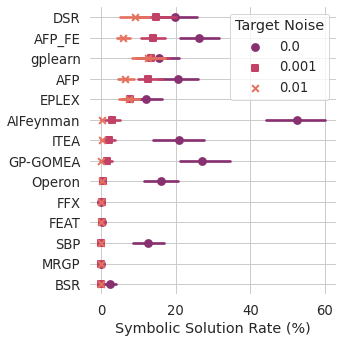

<Figure size 432x288 with 0 Axes>

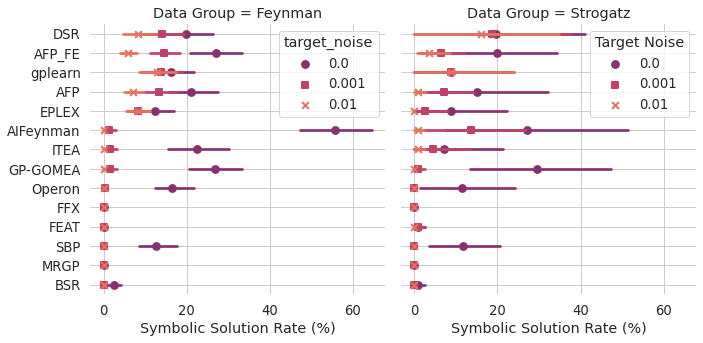

<Figure size 432x288 with 0 Axes>

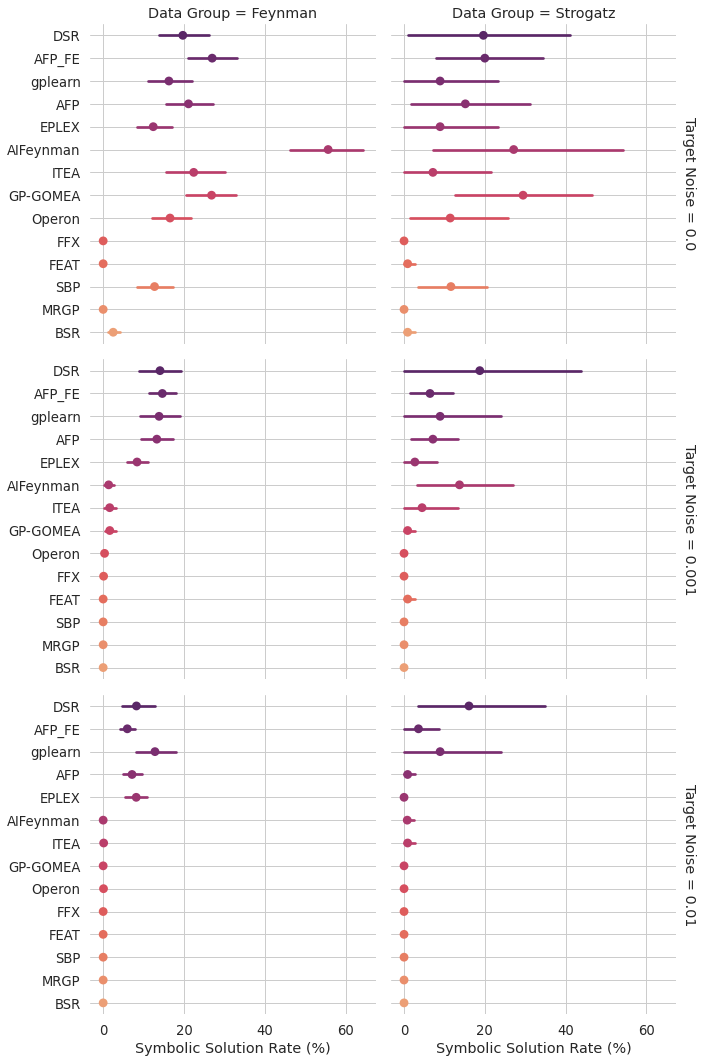

<Figure size 432x288 with 0 Axes>

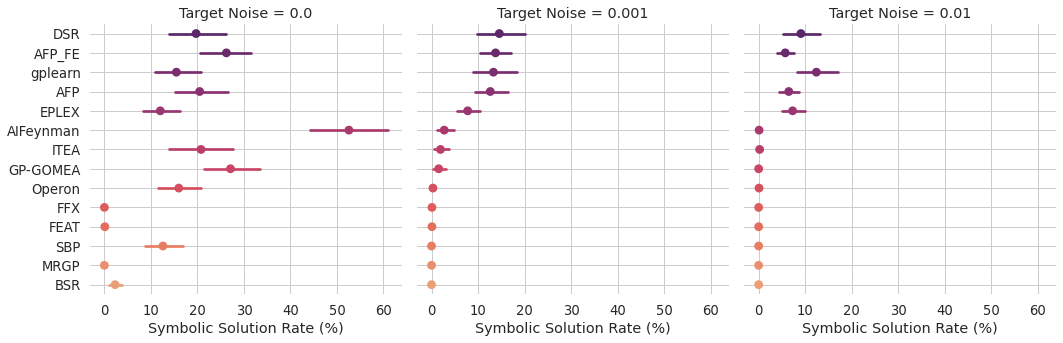

<Figure size 432x288 with 0 Axes>

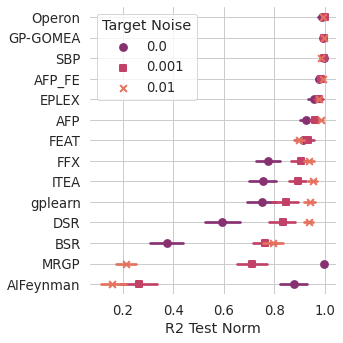

<Figure size 432x288 with 0 Axes>

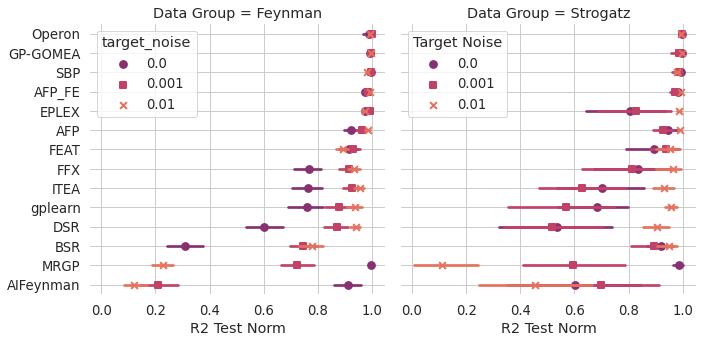

<Figure size 432x288 with 0 Axes>

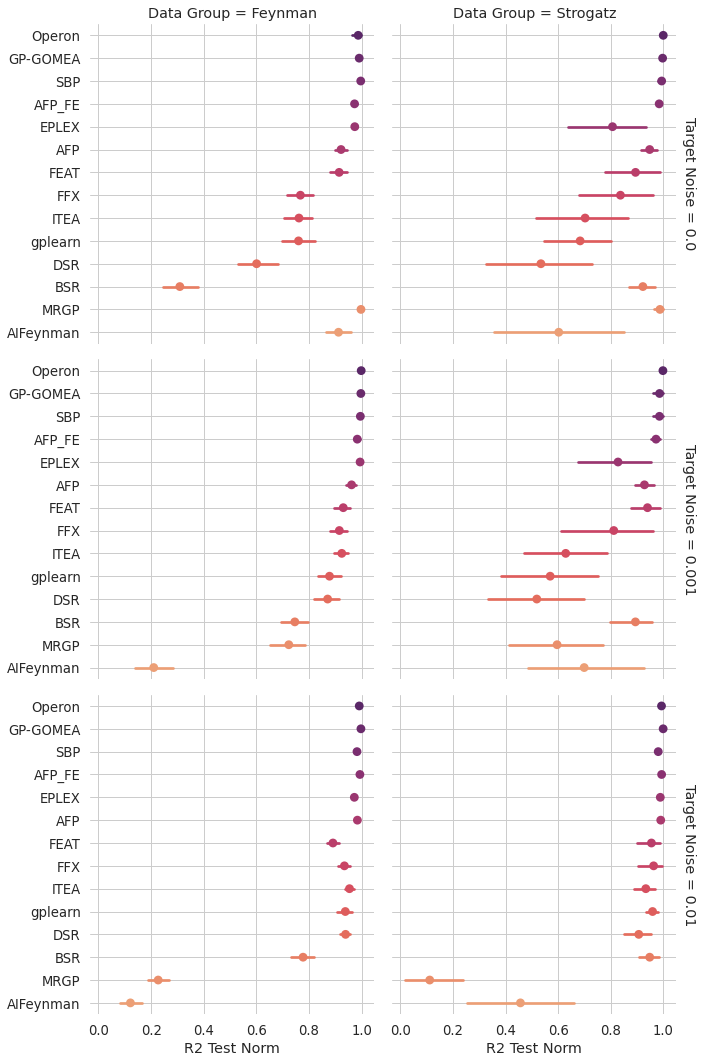

<Figure size 432x288 with 0 Axes>

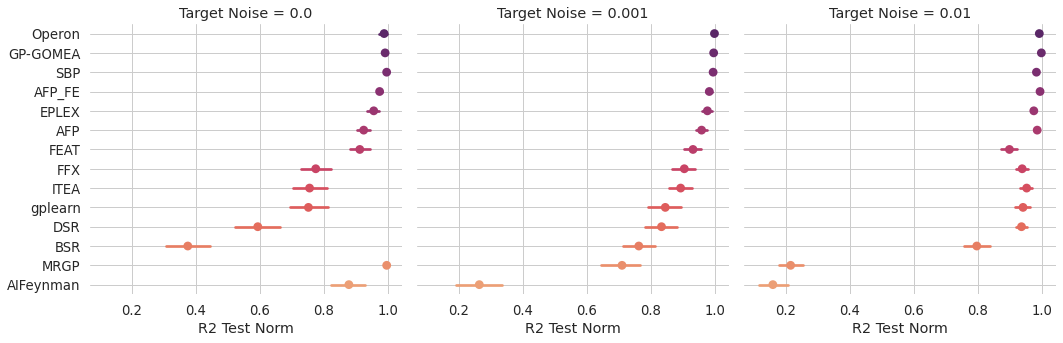

<Figure size 432x288 with 0 Axes>

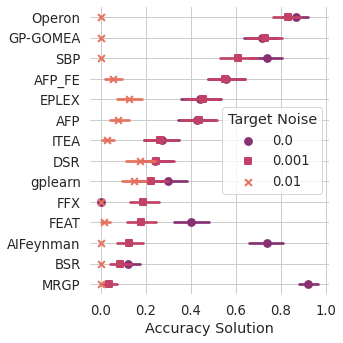

<Figure size 432x288 with 0 Axes>

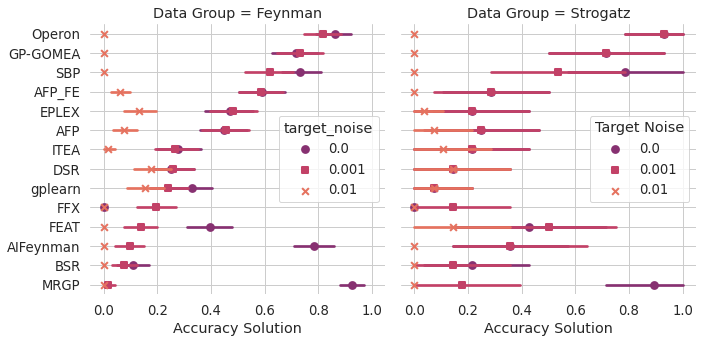

<Figure size 432x288 with 0 Axes>

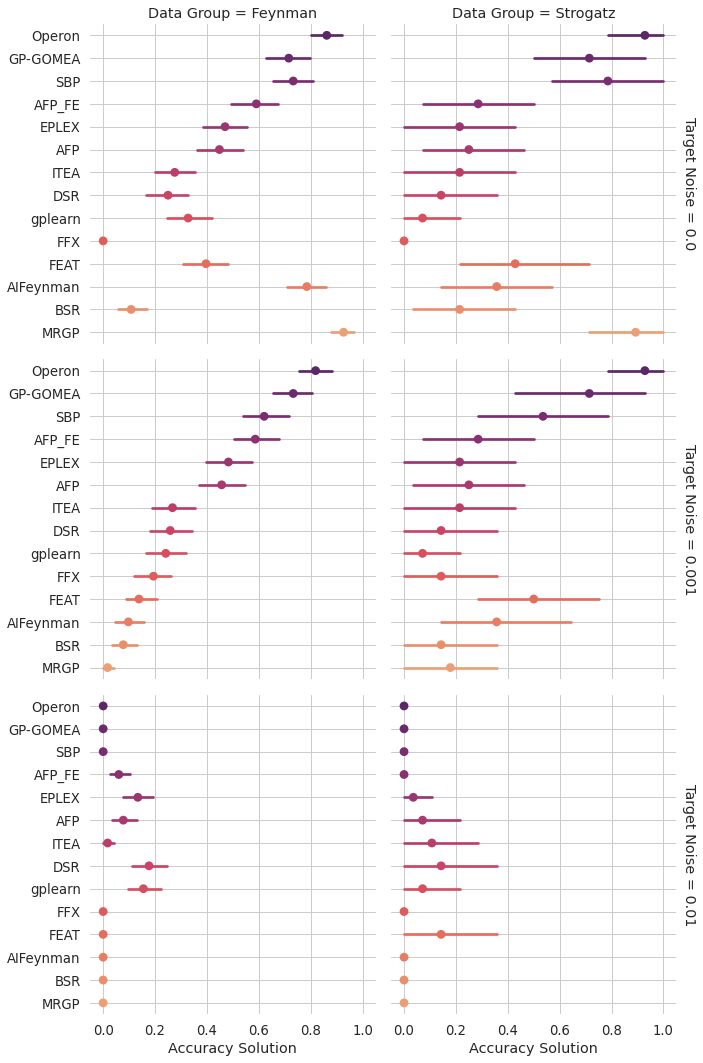

<Figure size 432x288 with 0 Axes>

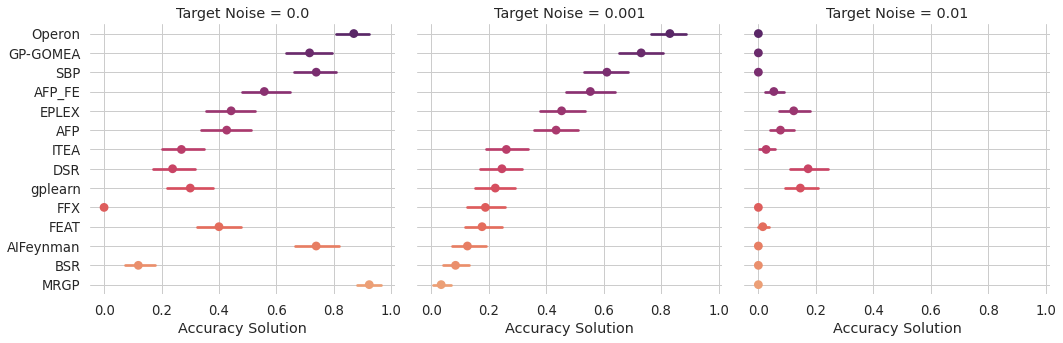

In [23]:
for metric in ['symbolic_solution_rate_(%)','r2_test_norm','accuracy_solution']:
# for metric in ['r2_test']:
    for kind in ['point']: #,'strip']:
        args =dict(df_compare=df_sum, x=metric, est=np.mean, orient='h',
                   kind=kind) 
        if kind=='point': 
            args['join'] = False 
            args['markers']=['o','s','x']
        if metric == 'r2_test':
            args['xlim'] = [-1, 1]
        compare(**args,
                hue='target_noise', 
                col=None,
                ) 
        compare(**args, 
                hue='target_noise', 
                col='data_group',
                ) 
        compare(**args, 
                row='target_noise', 
                col='data_group',
                ) 
        compare(**args,
                col='target_noise', 
                ) 
# compare(df_sum, x='r2_test', hue='target_noise', est=np.mean, orient='h',kind=kind) #, scale='log') 
# for kind in ['point']:
#     compare(df_sum, x='r2_test', est=np.mean, orient='h',xlim=[0.0,1], kind=kind)
#     compare(df_sum, x='r2_test', row='target_noise', col='data_group',est=np.mean, orient='h',
#             xlim=[0.0,1], kind=kind)  
#     compare(df_sum, x='r2_test_rank', row='target_noise', col='data_group',est=np.mean, orient='h',
#             kind=kind) 
# compare(df_sum, x='mse_test', col='target_noise', xlim=[0,10]) #, scale='log') 
# compare(df_sum, x='r2_test', col='target_noise', xlim=[0,1])
# compare(df_sum, x='training time (s)', scale='log', col='target_noise')
# compare(df_sum, x='model_size', scale='log', col='target_noise')
# compare(df_sum, x='mse_test_rank', col='target_noise') 
# compare(df_sum, x='r2_test_rank', col='target_noise')

# scores on symbolic datasets

In [24]:

df_plot = df_sum.copy()
tmp = df_plot.groupby(['target_noise','algorithm'])['symbolic_solution_rate'].mean().unstack().median()
# tmp.median()
display(tmp)
order = tmp.sort_values(ascending=False).index
order

algorithm
AFP          0.126236
AFP_FE       0.137607
AIFeynman    0.027275
BSR          0.000000
DSR          0.145742
EPLEX        0.077747
FEAT         0.000962
FFX          0.000000
GP-GOMEA     0.015522
ITEA         0.019231
MRGP         0.000000
Operon       0.003077
SBP          0.000000
gplearn      0.133104
dtype: float64

Index(['DSR', 'AFP_FE', 'gplearn', 'AFP', 'EPLEX', 'AIFeynman', 'ITEA',
       'GP-GOMEA', 'Operon', 'FEAT', 'SBP', 'MRGP', 'FFX', 'BSR'],
      dtype='object', name='algorithm')

saving pairgrid_symbolic_solution_rate_(pct)_r2_test_simplified_complexity.pdf


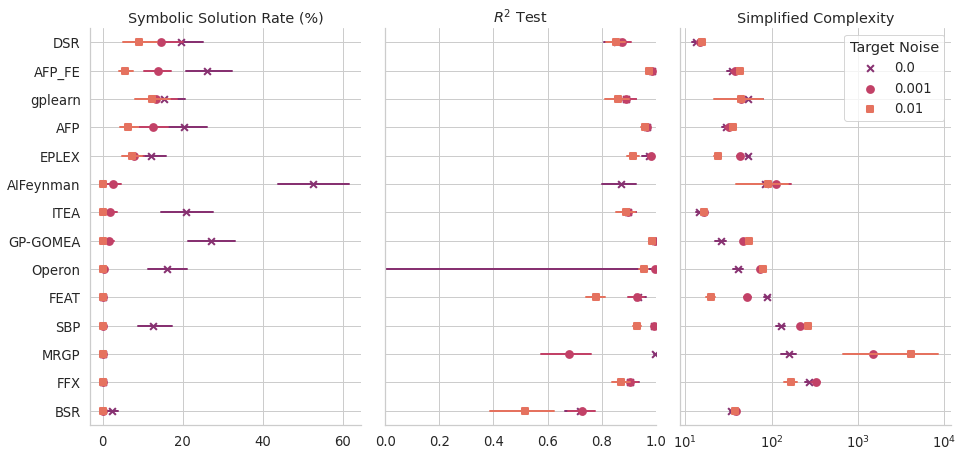

In [25]:
# Make the PairGrid
df_plot = df_sum.copy()
# df_plot['norm_r2_test'] = df_plot.groupby('dataset')['r2_test'].apply(lambda x: (x-x.min())/(x.max()-x.min()))
# df_plot['*algorithm*'] = df_plot['algorithm'].apply(lambda x: '*'+x+'*' if x in symbolic_algs else x)
# order = df_plot.groupby('algorithm')['symbolic_solution_rate'].mean().sort_values(ascending=False).index
# order = df_plot.loc[df_plot.target_noise==0.001].groupby('algorithm')['r2_test'].median().sort_values(ascending=False).index
# tmp = df_plot.groupby(['algorithm','target_noise'])['symbolic_solution_rate'].mean()
tmp = df_plot.groupby(['target_noise','algorithm'])['symbolic_solution_rate'].mean().unstack().median()
order = tmp.sort_values(ascending=False).index
# order = df_plot.groupby('algorithm')['symbolic_solution_rate'].mean().sort_values(ascending=False).index
# order = df_plot.loc[df_plot.target_noise==0.001].groupby('algorithm')['symbolic_solution_rate'].mean().sort_values(ascending=False).index
df_plot['size_diff'] = df_plot['model_size']-df_plot['simplified_complexity']+1
x_vars=[
#         'accuracy_solution_rate_(%)',
#         'mse_test',
#         'r2_test_rank',
#         'r2_test_norm',
        'symbolic_solution_rate_(%)',
        'r2_test',
        'simplified_complexity',
#         'size_diff',
#         'model_size',
#         'training time (s)',
#         'solution'
]
g = sns.PairGrid(df_plot, 
                 x_vars=x_vars,
                 y_vars=['algorithm'],
                 height=6.5, 
                 aspect=0.7,
                 hue='target_noise',
#                  hue_order=[0.01,0.001,0]
#                  hue='dataset'
                )
g.map(sns.pointplot, 
#       size=10,
      orient="h",
      jitter=False,
      order=order,
      palette="flare_r",
      errwidth=2,
      linewidth=0.01,
      markeredgecolor='w',
      join=False,
      estimator=np.mean,
      n_boot=1000,
      linestyles=[':','--','-'],
      markers=['x','o','s'],
      markeralpha=0.5
     )
plt.legend(title='Target Noise')
# Use the same x axis limits on all columns and add better labels
# g.set(xlim=(0, 25), xlabel="Crashes", ylabel="")

# # Use semantically meaningful titles for the columns
# titles = ["Total crashes", "Speeding crashes", "Alcohol crashes",
#           "Not distracted crashes", "No previous crashes"]
titles = [x.replace('_',' ').title().replace('(S)','(s)') for x in x_vars]

for ax, title in zip(g.axes.flat, titles):

    # remove xlabel
    ax.set_xlabel('')
    ax.set_ylabel('')
    # Set a different title for each axes
    ax.set(title=title)
    
#     if any([n in title.lower() for n in ['size','time']]):
    if any([n in title.lower() for n in ['size','complexity','time']]):
        ax.set_xscale('log')
    if 'R2' in title and 'Rank' not in title:
        ax.set(title=title.replace('R2','$R^2$'))
        ax.set_xlim([0,1])

    # Make the grid horizontal instead of vertical
#     ax.xaxis.grid(True)
    ax.yaxis.grid(True)
# g.tight_layout()
# sns.despine(left=True, bottom=True)
save(g, 'pairgrid_'+'_'.join(x_vars))

## Pareto plot

In [26]:
np.random.seed(42)
def bootstrap(val, n = 1000, fn=np.mean):
    val_samples = []
    for i in range(n):
        sample = np.random.randint(0,len(val)-1, size=len(val))
        val_samples.append( fn(val[sample]) )
    m = np.mean(val_samples)
    sd = np.std(val_samples)
    ci_upper  = np.quantile(val_samples,0.95)
    ci_lower  = np.quantile(val_samples,0.05)
    return m, sd, ci_upper,ci_lower

saving pareto_plot_r2_test_rank_model_size_rank.pdf


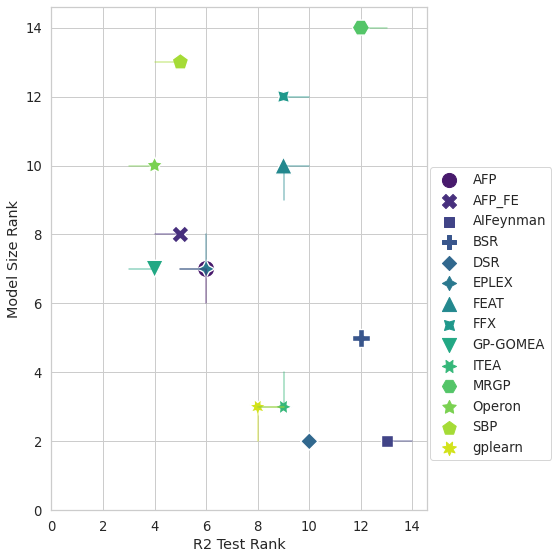

In [27]:
plt.figure(figsize=(8,8))
data = df_sum.copy()
xcol = 'r2_test_rank'
# xcol = 'symbolic_solution_rate_rank'
ycol = 'model_size_rank'
palette = 'viridis'
cmap = sns.color_palette(palette=palette, n_colors=data.algorithm.nunique(), desat=None, as_cmap=False)
Z = 1.96 # 95% confidence 
i = 0
for alg, dg in data.groupby('algorithm'):
    x = dg[xcol].median() 
    y = dg[ycol].median()
    _, sdx, ciux, cilx = bootstrap(dg[xcol].values, fn=np.median, n=1000)
    _, sdy, ciuy, cily = bootstrap(dg[ycol].values, fn=np.median, n=1000)
    plt.plot(
#              [x-sdx,x+sdx],
             [cilx, ciux],
             [y, y],
             alpha=0.5,
             color=cmap[i]
            )
    plt.plot(
             [x, x],
#              [y-sdy,y+sdy],
             [cily, ciuy],
             alpha=0.5,
             color=cmap[i]
            )
    i += 1
ax = sns.scatterplot(
    ax = plt.gca(),
#     ax = g.ax_joint,
    data = data.groupby('algorithm').median(),
    x = xcol,
    y = ycol,
    style='algorithm',
    hue = 'algorithm',
    s=300,
    palette=palette,
    #     edgecolor='k'
)
handles = ax.get_legend_handles_labels()[0]
for lh in handles: 
    lh.set_alpha(1)
    lh._sizes = [200] 
ax.legend(handles=handles, loc=[1.01,0.1])
# ax.set_yscale('log')
ax.set_xlim(left=0)
ax.set_ylim(bottom=0)
plt.xlabel(xcol.replace('_',' ').title())
plt.ylabel(ycol.replace('_',' ').title())
save(plt.gcf(), name='pareto_plot_'+xcol+'_'+ycol)

saving cat-barplot-Symbolic-Solution-Rate-(pct)-by-Algorithm_Dataset.pdf


<Figure size 432x288 with 0 Axes>

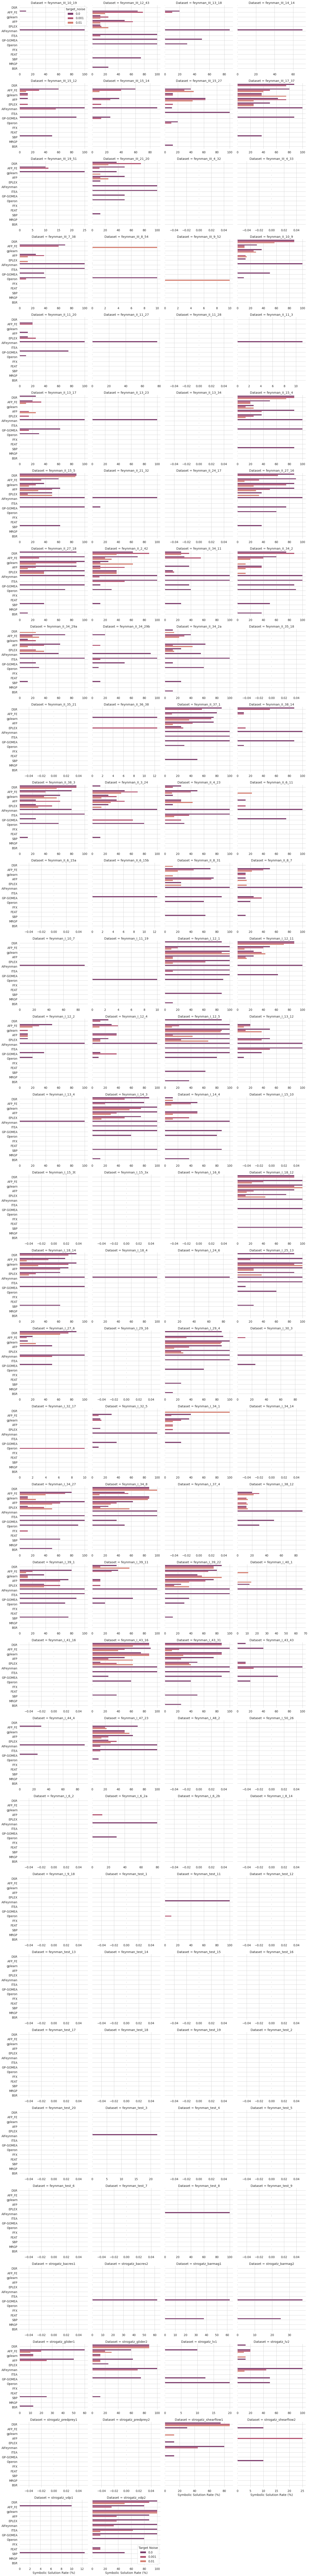

In [28]:
compare(df_sum, x='symbolic_solution_rate_(%)', hue='target_noise', col='dataset',est=np.mean, orient='h',
       sharex=False, kind='bar') #, scale='log') 